# Deep Q Network for different environments

## 1. Import the libraries

In [13]:
import numpy as np
import matplotlib.pyplot as plt #plotting library
from matplotlib import animation #animated visualizations library
from collections import namedtuple, deque 
#nametuple creates tuple subclasses with name fields, access elements by names instead of index
#deque (double-ended queue) for adding and removing elements from both ends
from tqdm import tqdm
#add progress bars to Python code for easy monitoring progress of loops and tasks
# %matplotlib inline 
import gym #environments for agents
from datetime import datetime #manipulating dates and times
import pandas as pd #work with structured data
import torch #Pytorch supports tensor computations and neural networks
import torch.nn as nn #Pytorch supports building neural networks
import torch.nn.functional as Function 
#common functions in neural network operations 
    # Activation functions (ReLU, sigmoid, tanh)
    # Loss functions (cross_entropy, mse_loss)
    #Utility functions for tensor manipulation (softmax, dropout, batch_norm, etc.)
import torch.optim as optim #optimization algorithms for training neural networks
import random #generate random numbers/selections
from collections import namedtuple, deque 
import itertools 
# provides various functions for creating iterators and combining them for complex interators
# includes cycle, chain, zip, etc.

## 2. Neural network model for approximating Q-values 

In [14]:
class QNetwork(nn.Module):
    #Actor Model

    def __init__(self, state_size, action_size, seed, fc1_units=10, fc2_units=10):
        #Parameters
#             state_size (int): Dimensionality of input state space
#             action_size (int): Dimensionality of output action space
#             seed (int): Random seed for reproducibility
#             fc1_units (int): Number of neurons (units) in first fully connected hidden layer
#             fc2_units (int): Number of neurons (unit) in second fully connected hidden layer  
        
        #Initialization
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed) # Set the random seed :
        state_size = env.observation_space.shape[0]
        #Ensure random numbers generate are reproducible
        #Running same code with the same seed will produce the same sequence of random numbers
        
        # nn.Linear creates fully connected layers (input units, output units)
        self.fc1 = nn.Linear(state_size, fc1_units) 
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        # Network to map state with action values (Q-values)
        #inside method, input state pass through each layer
        #ReLU activation functions are applied to the outputs of hidden layers
#         print('state:', state.shape)
        #x output of 1 layer is input to the next
        x = Function.relu(self.fc1(state))
        x = Function.relu(self.fc2(x))
        return self.fc3(x)

## 3. Implement the replay buffer

In [15]:
device = torch.device("cpu") #Device Initialization

class ReplayBuffer: #Fixed-size buffer to store experience tuples.
    # Initialize a ReplayBuffer object.
    def __init__(self, state_size, action_size, buffer_size, batch_size, priority=False):
            #state_size(int): dimension of each state
            #action_size (int): dimension of each action 
            #buffer_size (int): max size of buffer 
            #batch_size (int): size of 1 training batch
            #seed (int): random seed
                
        #Pointer to keep track of position within the replay buffer where next experiene will be added
        # ptr = 0, new experience added -> increment to ptr = 1
        self. ptr = 0
        #Check if buffer have been filled
        self.n = 0 
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.state_size = state_size
        
        state_size = env.observation_space.shape[0]

        #create states tensor full of zeros with {buffer_size} rows & {state_size} columns
        #store in device CPU, allocate RAM to it 
        self.states = torch.zeros((buffer_size,)+(state_size,)).to(device)
        
        #Similar to above 
        self.next_states = torch.zeros((buffer_size,)+(state_size,)).to(device)
        
        #Only 1 action taken per experience tuple stored
        # => action size = buffer size rows but 1 column only needed to store
        self.actions = torch.zeros(buffer_size,1, dtype=torch.long).to(device)
        
        # Reward same with action
        self.rewards = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        
        # Flag to indicate transition/end between an episode ('done' flag)
        # True/False floating values (0.0 False, 1.0 True)
        self.dones = torch.zeros(buffer_size, 1, dtype=torch.float).to(device) 
        
        # Error in case implement prioritize replay
        self.error = np.zeros((buffer_size, 1), dtype=float)
        
        # Priority
        self.priority = priority
    
  # Add new experience to buffer
    def add(self, state, action, reward, next_state, done, state_size):
        
        state_size = env.observation_space.shape[0]
        
        
        # Function to flatten ragged nested sequences into a flat array of compatible type
        def flatten_nested_sequence(elem):
            flattened = []
            for e in elem:
                if isinstance(e, (list, tuple)):
                    flattened.extend(flatten_nested_sequence(e))
                elif isinstance(e, np.ndarray):
                    if e.dtype == np.object_:
                        raise ValueError("Cannot handle np.ndarray of type numpy.object_")
                    else:
                        flattened.append(e)
                else:
                    flattened.append(e)
            return flattened

        # Convert state and next_state to appropriate types
        if isinstance(state, np.ndarray):
            state = flatten_nested_sequence(state)
            state = torch.as_tensor(state, dtype=torch.float32).to(device)
        elif isinstance(state, torch.Tensor):
            state = state.to(device)
        else:
            state = torch.zeros((1, state_size), dtype=torch.float32).to(device)

        if isinstance(next_state, np.ndarray):
            next_state = flatten_nested_sequence(next_state)
            next_state = torch.as_tensor(next_state, dtype=torch.float32).to(device)
        elif isinstance(next_state, torch.Tensor):
            next_state = next_state.to(device)
        else:
            next_state = torch.zeros((1, state_size), dtype=torch.float32).to(device) 
        # Convert action, reward, and done flag to tensors
        action = torch.as_tensor(action, dtype=torch.float32).to(device)
        reward = torch.as_tensor(reward, dtype=torch.float32).to(device)
        done = torch.as_tensor(done, dtype=torch.bool).to(device)

        # Store the data in the replay buffer
        self.states[self.ptr] = state
        self.next_states[self.ptr] = next_state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.dones[self.ptr] = done

        # Increment the pointer
        self.ptr = (self.ptr + 1) % self.buffer_size

        # Reset pointer and flag when buffer is filled
        if self.ptr == 0:
            self.n = self.buffer_size
        
    #Sample a batch of experience from memory
    def sample(self, get_all=False):
        n = len(self) # Length of the Buffer
        
        # Return all experience stored in buffer, no sampling
        if get_all:
            return self.states[:n], self.actions[:n], self.rewards[:n], self.next_states[:n], self.dones[:n]
        
        # else, do sampling: 
        else:
            if self.priority:     
            #enable prioritized experience replay
            #experience are sampled based on priorities probability distribution p = self.error
                idx = np.random.choice(n, self.batch_size, replace=False, p=self.error)
            else: #uniform sampling
                idx = np.random.choice(n, self.batch_size, replace=False)
            #Replace = False to only sample once for each element
            
            #Retrieve sampled experiences 
            states = self.states[idx]
            next_states = self.next_states[idx]
            actions = self.actions[idx]
            rewards = self.rewards[idx]
            dones = self.dones[idx]
        
            return (states, actions, rewards, next_states, dones), idx
    
    # Update the error associated with experiences in replay buffer
    def update_error(self, error, idx=None): #specify index number, if not specify, all are updated
        error = torch.abs(error.detach()) #absolute value of errors, detach to prevent gradient computation to be attached to error tensor
        error = error / error.sum() #Normalize, ensure all errors add up to 1
        if idx is not None: #index are specified, then only update specified indices
            self.error[idx] = error.cpu().numpy()
        else: # not specify index, all are updated
            self.error[:len(self)] = error.cpu().numpy()
    
    # 
    def __len__(self): 
        if self.n == 0:
            return self.ptr
        else:
            return self.n #when buffer is filled self.n stored that size

## 4. Set the parameters 

In [16]:
buffer_size = 100000 #Replay buffer size
batch_size = 4 #Minibatch size
gamma = 0.99 #Discount factor
tau = 1 #Soft update target parameters, tau = 1 = copy completely
alpha = 0.0005 #learning rate
update_every = 4 #How often to update the network

## 5. Agent learning implementation

In [17]:
class Agent(): #Learning by interacting with the environment
    def __init__(self, state_size, action_size, seed=1, ddqn=True, priority=False):
        self.state_size = state_size #Dimension of each state
        self.action_size = action_size #Dimension of action
        self.seed = random.seed(seed) #Choose the random seed
        self.ddqn = ddqn #Store whether agent uses DDQN
        self.priority = priority #Whether uses experience replay
        
        #Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        #Initializes optimizer for updating the weights of local Q-Network
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=alpha)

        # Replay memory
        self.memory = ReplayBuffer(state_size, (action_size,), buffer_size, batch_size)
        # Initialize timestep (to keep track timesteps for updating target)
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done, step_size):
        
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done, step_size)
        
        
        self.t_step = self.t_step + 1  
        ## Update Q-network after each step in DQN case
        
        if not self.ddqn: #DQN case
            
            if len(self.memory) > batch_size:
                experiences, idx = self.memory.sample() #sample batch of experience from replay memory
                error = self.learn(experiences) #update Q-network based on sampled experiences
                                #outputs the error (difference) between predicted Q-value and target Q-value during training
                self.memory.update_error(error,idx)
                
        else: #DDQN case, only update after a period
            if len(self.memory) > batch_size:
                experiences, idx = self.memory.sample() #sample batch of experience from replay memory
                error = self.learn(experiences) #update Q-network based on sampled experiences
                                #outputs the error (difference) between predicted Q-value and target Q-value during training
            #if there is no remainder we update
            if (self.t_step % update_every) == 0 and len(self.memory) > batch_size:
                self.memory.update_error(error, idx) #update
 
    def act(self, state, epsilon):
        if isinstance(state, np.ndarray):
            if state.dtype == np.object_:
                # Convert elements of the NumPy array to compatible types
                state = np.array([self.convert_to_compatible_type(elem) for elem in state])
            # Convert the modified NumPy array to a PyTorch tensor for neural network input
            state = torch.as_tensor(state, dtype=torch.float32).to(device)
        elif isinstance(state, list) or isinstance(state, tuple):
            # Convert the state to a NumPy array and handle ragged nested sequences
            state = self.handle_ragged_nested_sequence(state)
            # Convert the modified NumPy array to a PyTorch tensor for neural network input
            state = torch.as_tensor(state, dtype=torch.float32).to(device)
        elif isinstance(state, torch.Tensor):
            # Ensure the tensor is in the correct device and data type
            state = state.to(device)
        else:
            raise TypeError("Input state should be a NumPy array, list, tuple, or torch.Tensor.")

        # Ensure the state has the correct shape for the neural network input
        state = state.unsqueeze(0)  # Add a batch dimension

        self.qnetwork_local.eval()  # Evaluation mode
        with torch.no_grad():  # Disable gradient calculation when choosing action
            action_values = self.qnetwork_local(state)  # Pass preprocessed states into local Q-network
        self.qnetwork_local.train()  # Set local Q network back to training mode after inference is complete

        # Epsilon-greedy action selection
        if random.random() > epsilon:
            # Return action with highest Q-value
            action = np.argmax(action_values.cpu().data.numpy())
        else:
            # Select a random action
            action = random.choice(range(self.action_size))
        action = min(max(action, 0), self.action_size - 1) # Ensure action is within valid range
        
        return action

    def convert_to_compatible_type(self, elem):
        # Convert the element to a compatible type if it is a numpy.object_
        if isinstance(elem, str):
            return float(elem)
        elif isinstance(elem, np.ndarray):
            return elem.astype(np.float32)
        else:
            return float(elem)

    def handle_ragged_nested_sequence(self, state):
        if not state:
            return np.array([])  # Return an empty NumPy array if the state is empty
        else:
            # Convert dictionaries to lists of values
            state = [list(d.values()) if isinstance(d, dict) else d for d in state]
            # Determine the maximum length among all nested sequences
            max_length = max(len(sublist) for sublist in state)
            # Pad shorter sequences with zeros to make them of equal length
            state = [sublist + [0] * (max_length - len(sublist)) if len(sublist) < max_length else sublist for sublist in state]
            # Convert the nested sequence to a NumPy array
            state = np.array(state)
            return state
    
    #Error update for prioritization experience replay
    def update_error(self):
        #Sample experience from replay memory
        states, actions, rewards, next_states, dones = self.memory.sample(get_all=True)
        with torch.no_grad(): #no gradient computations within block
            if self.ddqn: #DDQN is enabled, use Q Network for both local and target
                #Q values of action taken in current state
                old_val = self.qnetwork_local(states).gather(-1, actions)
                #Determine actions with highest Q values in next states using local Q-network
                actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                # Compute Q-values of selected actions from target Q-network for next states
                maxQ = self.qnetwork_target(next_states).gather(-1, actions)
                #Calculate target as the normal formula
                #dones is a binary tensor indicating the next state is terminal or not (store done flags)
                #Use 1-dones to ensure discounted future rewards are considered only for non-terminal states
                #At terminal done = 1, so 1 - dones = 0, cancels out the maxQ => Q terminal = 0
                target = rewards+gamma*maxQ*(1-dones)
            else: # Normal DQN
                #Difference in this DQN is obtained directly from target Q-network using max function
                #instead of considering the action from local state
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+gamma*maxQ*(1-dones)
                old_val = self.qnetwork_local(states).gather(-1, actions)
            error = old_val - target
            self.memory.update_error(error)      
            
    #Update value parameters using batch of experience tuples
    def learn(self, experiences):
        #experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
        #gamma (float): discount factor
      
        states, actions, rewards, next_states, dones = experiences

        ## compute and minimize the loss
        self.optimizer.zero_grad() #Resets all gradients to zero, gradients from previous batches do not accumulate
        if i_episode < 3 or i_episode > 1998:
            print("Current state: ", state)
            print(" ")
            print("Experiences: ")
            print("States: ", states)
            print("Actions: ", actions)
            print("Rewards: ", rewards)
            print("Next states: ", next_states)
            print(" ")
        #Same as explained above
        if self.ddqn: #DDQN
            old_val = self.qnetwork_local(states).gather(-1, actions)
            if i_episode < 3 or i_episode > 1998:
                print("Q_current: ", old_val)
                print(" ")
            with torch.no_grad():
                if i_episode < 3 or i_episode > 1998:
                    print("All Q values for next_states in order to choose actions, estimate with local network: ")
                    print(self.qnetwork_local(next_states))
                    print(" ")
                next_actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                
                if i_episode < 3 or i_episode > 1998:
                    print("Actions, chose with local network = ", next_actions)
                    print(" ")
                    print("All Q values for next_states, estimate with target network: ")
                    print(self.qnetwork_target(next_states))
                    print(" ")
                maxQ = self.qnetwork_target(next_states).gather(-1, next_actions)
                
                if i_episode < 3 or i_episode > 1998:
                    print("Chosen maximum Q - value from actions gathered above = ", maxQ)
                    print(" ")
                target = rewards+gamma*maxQ*(1-dones)
                
                if i_episode < 3 or i_episode > 1998:
                    print("Q_target = ", target)
                    print(" ")
                    
        else: # Normal DQN
            old_val = self.qnetwork_local(states).gather(-1, actions)
            
            if i_episode < 3 or i_episode > 1998:
                print("Q_current: ", old_val)
                print(" ")
                print("Actions = ", actions)
                print(" ")
            
            with torch.no_grad():
                
                if i_episode < 3 or i_episode > 1998:
                    print("All Q values for next_states = ")
                    print(self.qnetwork_target(next_states))
                    print(" ")
                
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                
                if i_episode < 3 or i_episode > 1998:
                    print("Chosen maximum Q - value= ", maxQ)
                    print(" ")
                
                target = rewards+gamma*maxQ*(1-dones)
                
                if i_episode < 3 or i_episode > 1998:
                    print("Q_target = ", target)
                    print(" ")
               
        if i_episode < 3 or i_episode > 1998:
            print("Error(Q_target - Q_current): ", target - old_val)
            print(" ")
        loss = Function.mse_loss(old_val, target) #Calculate loss of current and target Q-values
        loss.backward() #Gradient of loss with respect to Q-network parameters are computed
                        #and used to update the parameters
        self.optimizer.step() #update the neural network
                                #step method applies optimization to update parameters
                                #steps:
                                #1. Optimizer uses computed gradients to update parameters
                                #2. Adam optimizer is applied to each parameter based on the gradients and learning rate
                                #3. Gradients are cleared back to zero as first step for next training iteration

        ##UPDATE THE TARGET NETWORK##
        if not self.ddqn:  # If DQN, update after each episode
            self.soft_update(self.qnetwork_local, self.qnetwork_target, tau) 
        else:  # If DDQN, update after every update_every episodes
            if (self.t_step % update_every) == 0:
                self.soft_update(self.qnetwork_local, self.qnetwork_target, tau)
        
        return old_val - target #temporal difference TD error between old Q and target Q to monitor training progress

    
    def soft_update(self, local_model, target_model, tau):
        #local_model: online model, actively being trained. Weights will be copied from here
        #target_model: use to generate target Q-values during training. Weights will be copied to here
        #tau: interpolation parameters determine rate at which parameters of target models are updated
        #small tau slower update, big tau faster update, less stable
        
        #function iterates over parameters of both target model and local model using zip
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            #for each target param - local param pair, update target param by the formula
            # target_param = tau*local_param + (1-tau)*target_local 
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    # Function to simulate a model in an environment
    def simulate_model(env_name, model_path):
        # Load the environment
        env = gym.make(env_name)

        # Get environment parameters
        state_size = env.observation_space.shape[0]
        action_size = env.action_space.n

        # Initialize the agent
        agent = Agent(state_size, action_size, seed) 

        # Load the model weights
        agent.qnetwork_local.load_state_dict(torch.load(model_path))
        agent.qnetwork_local.eval()

        # Simulate the model in the environment
        scores = []
        n_episodes = 100  # Number of episodes for simulation
        max_t = 1000  # Maximum number of timesteps per episode

        for i_episode in tqdm(range(1, n_episodes+1)):
            state = env.reset()
            score = 0

            for t in range(max_t):
                action = agent.act(state, epsilon=0.)  # Greedy action selection, no exploration
                state, reward, done, _ = env.step(action)
                score += reward
                if done:
                    break

            scores.append(score)

        # Close the environment
        env.close()

        # Print average score
        print("Average score:", np.mean(scores))

## 6. Training parameters and environments

In [18]:
envs = ['LunarLander-v2'] #list of environments 'MountainCar-v0',
#list of implementing algos, each element consists of [DDQN is enabled?, Prioritized experience replay enabled?, type of algo]
algos = [[True, False, 'DDQN']] #,, [True, True, 'PriorityDDQN'], [False, False, 'DQN'], 
seed = 1
n_episodes = 2000 #number of training episodes
max_t = 1000 #maximum number of timesteps
epsilon_start = 0.7 #starting value of epsilon greedy
epsilon_end = 0.01 #minimum value of epsilon
epsilon_decay = 0.995 #rate at which epsilon decays

## 7. Training implementation

In [19]:
print("Seed = 1")
for i in envs:
    print("ENVIRONMENT:-----------", i)
    env = gym.make(i)
    res=[]
    for j in algos:
        print("Algorithm:", j[2])
        rewards = []
        aver_reward = []
        aver = deque(maxlen=100)
        state_size = env.observation_space.shape[0]
        action_size=env.action_space.n
        agent = Agent(state_size, action_size, seed, ddqn=j[0], priority=j[1])
        epsilon = epsilon_start                    # initialize epsilon
        
        for i_episode in tqdm(range(1, n_episodes+1)):
            if i_episode < 3 or i_episode > 1998:
                print("Iteration number: ", i_episode-1)
            state = env.reset()
            score = 0
            for t in range(max_t):
                action = agent.act(state, epsilon)
                step_result = env.step(action)
                next_state, reward, done, _ = step_result[:4]
                agent.step(state, action, reward, next_state, done, state_size)
                state = next_state
                score = score + reward
                if done:
                    break 

            aver.append(score)     
            aver_reward.append(np.mean(aver))
            rewards.append(score)
            epsilon = max(epsilon_end, epsilon_decay*epsilon) # decrease epsilon
            
        reward="model/"+i+"_"+j[2]+"_"+str(n_episodes)+"_"+str(datetime.now().strftime("%Y%m%d%H%M%S"))
        torch.save(agent.qnetwork_local.state_dict(),reward+'.pt')
        res.append(aver_reward)
        print("----------------End Algorithm--------------------")
    
    fig=plt.figure()   
    
    reward='plots/'+i+'_result'+str(datetime.now().strftime("%Y%m%d%H%M%S"))
    df=pd.DataFrame({'DQN':res[0],'DDQN':res[1],'PriorityDDQN':res[2]})
    df.to_csv(reward+'.csv')
    print("------------------------End Environment-------------------")
    
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(df['DQN'], 'r', label='DQN')

    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(df['DDQN'], 'orange',label='DDQN')

    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(df['PriorityDDQN'],'b',label='PER')
    
    plt.title('Learning Curve '+i)

    #Insert the legends in the plot
    fig.legend(loc='lower right')
    fig.savefig(reward+'.png', dpi=100)
    
        

Seed = 1
ENVIRONMENT:----------- LunarLander-v2
Algorithm: DDQN


  0%|                                                                                                      | 0/2000 [00:00<?, ?it/s]

Iteration number:  0
Current state:  [-0.03805723  1.363322   -0.7615739  -0.44018617  0.03308926  0.07225109
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0381,  1.3633, -0.7616, -0.4402,  0.0331,  0.0723,  0.0000,  0.0000],
        [-0.0153,  1.3926, -0.7725, -0.4201,  0.0175,  0.1732,  0.0000,  0.0000],
        [-0.0305,  1.3732, -0.7721, -0.4139,  0.0295,  0.1148,  0.0000,  0.0000]])
Actions:  tensor([[0],
        [2],
        [3],
        [3]])
Rewards:  tensor([[-1.0298],
        [ 1.5651],
        [ 0.0682],
        [ 0.2253]])
Next states:  tensor([[-0.0153,  1.3926, -0.7725, -0.4201,  0.0175,  0.1732,  0.0000,  0.0000],
        [-0.0455,  1.3536, -0.7510, -0.4318,  0.0373,  0.0847,  0.0000,  0.0000],
        [-0.0228,  1.3825, -0.7604, -0.4471,  0.0237,  0.1245,  0.0000,  0.0000],
        [-0.0381,  1.3633, -0.7616, -0.4402,  0.0331,  0.0723,  0.0000,  0.0000]])
 
Q_current:  ten

Error(Q_target - Q_current):  tensor([[ 1.5564],
        [ 0.4460],
        [-0.1240],
        [ 0.1820]], grad_fn=<SubBackward0>)
 
Current state:  [-0.16378507  1.2078114  -0.82640517 -0.38035363  0.08914235  0.04977776
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.1149,  1.2648, -0.7951, -0.4529,  0.0693,  0.0578,  0.0000,  0.0000],
        [-0.0680,  1.3224, -0.7568, -0.4771,  0.0496,  0.0809,  0.0000,  0.0000],
        [-0.0757,  1.3126, -0.7668, -0.4392,  0.0534,  0.0758,  0.0000,  0.0000],
        [-0.1393,  1.2347, -0.8282, -0.4317,  0.0795,  0.0742,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [2],
        [2]])
Rewards:  tensor([[-0.1168],
        [ 1.3645],
        [ 0.9480],
        [ 2.3441]])
Next states:  tensor([[-0.1229,  1.2549, -0.8070, -0.4414,  0.0718,  0.0500,  0.0000,  0.0000],
        [-0.0757,  1.3126, -0.7668, -0.4392,  0.0534,  0.0758,  0.0000,  0.0000],
        [-0.0834,  1.3034, -0.7753, -0.4083,  0.0570,  0.0719,  0.0000

Error(Q_target - Q_current):  tensor([[-0.8166],
        [-0.4955],
        [ 0.4631],
        [ 0.3576]], grad_fn=<SubBackward0>)
 
Current state:  [-0.37740058  0.9907538  -0.92277396 -0.4958771   0.15912524  0.02586259
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.2502,  1.1258, -0.9053, -0.3130,  0.1309,  0.0818,  0.0000,  0.0000],
        [-0.2862,  1.0930, -0.9142, -0.3587,  0.1416,  0.0433,  0.0000,  0.0000],
        [-0.2322,  1.1402, -0.8864, -0.3681,  0.1231,  0.0804,  0.0000,  0.0000],
        [-0.1886,  1.1815, -0.8408, -0.3792,  0.1023,  0.1014,  0.0000,  0.0000]])
Actions:  tensor([[3],
        [0],
        [2],
        [2]])
Rewards:  tensor([[ 0.2531],
        [-0.6197],
        [-0.4837],
        [-1.4489]])
Next states:  tensor([[-0.2591,  1.1182, -0.8961, -0.3394,  0.1331,  0.0452,  0.0000,  0.0000],
        [-0.2953,  1.0844, -0.9142, -0.3853,  0.1438,  0.0433,  0.0000,  0.0000],
        [-0.2412,  1.1329, -0.9060, -0.3272,  0.1268,  0.0736,  0.0000

States:  tensor([[-0.1149,  1.2648, -0.7951, -0.4529,  0.0693,  0.0578,  0.0000,  0.0000],
        [-0.0530,  1.3433, -0.7510, -0.4584,  0.0416,  0.0846,  0.0000,  0.0000],
        [-0.1070,  1.2750, -0.7951, -0.4262,  0.0664,  0.0579,  0.0000,  0.0000],
        [-0.0381,  1.3633, -0.7616, -0.4402,  0.0331,  0.0723,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [0],
        [2]])
Rewards:  tensor([[-0.1168],
        [ 0.1897],
        [-0.6340],
        [ 1.5651]])
Next states:  tensor([[-0.1229,  1.2549, -0.8070, -0.4414,  0.0718,  0.0500,  0.0000,  0.0000],
        [-0.0605,  1.3332, -0.7568, -0.4504,  0.0456,  0.0809,  0.0000,  0.0000],
        [-0.1149,  1.2648, -0.7951, -0.4529,  0.0693,  0.0578,  0.0000,  0.0000],
        [-0.0455,  1.3536, -0.7510, -0.4318,  0.0373,  0.0847,  0.0000,  0.0000]])
 
Q_current:  tensor([[ 0.3370],
        [ 0.3282],
        [-0.2195],
        [ 0.3273]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose a

Q_target =  tensor([[ 0.9387],
        [-0.3733],
        [-1.3023],
        [ 0.7115]])
 
Error(Q_target - Q_current):  tensor([[ 0.5911],
        [-0.7524],
        [-1.2511],
        [ 0.3618]], grad_fn=<SubBackward0>)
 
Current state:  [-0.54044235  0.7621113  -1.0080788  -0.6840101   0.2025741   0.14262572
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.3682,  1.0019, -0.9274, -0.4945,  0.1578,  0.0157,  0.0000,  0.0000],
        [-0.0381,  1.3633, -0.7616, -0.4402,  0.0331,  0.0723,  0.0000,  0.0000],
        [-0.0305,  1.3732, -0.7721, -0.4139,  0.0295,  0.1148,  0.0000,  0.0000],
        [-0.5204,  0.7930, -1.0012, -0.6634,  0.1888,  0.1015,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [3],
        [1]])
Rewards:  tensor([[ 0.6316],
        [ 1.5651],
        [ 0.2253],
        [-2.1181]])
Next states:  tensor([[-0.3774,  0.9908, -0.9228, -0.4959,  0.1591,  0.0259,  0.0000,  0.0000],
        [-0.0455,  1.3536, -0.7510, -0.4318,  0.0373,  0.0847

Current state:  [-0.5911778   0.68311685 -1.0386742  -0.7267164   0.23951273  0.14180249
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.3682,  1.0019, -0.9274, -0.4945,  0.1578,  0.0157,  0.0000,  0.0000],
        [-0.4617,  0.8786, -0.9579, -0.5899,  0.1699,  0.0071,  0.0000,  0.0000],
        [-0.2233,  1.1485, -0.8904, -0.3670,  0.1191,  0.0721,  0.0000,  0.0000],
        [-0.0834,  1.3034, -0.7753, -0.4083,  0.0570,  0.0719,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [2],
        [0]])
Rewards:  tensor([[ 0.6316],
        [ 0.4748],
        [ 0.2724],
        [-0.7099]])
Next states:  tensor([[-0.3774,  0.9908, -0.9228, -0.4959,  0.1591,  0.0259,  0.0000,  0.0000],
        [-0.4714,  0.8657, -0.9663, -0.5733,  0.1704,  0.0097,  0.0000,  0.0000],
        [-0.2322,  1.1402, -0.8864, -0.3681,  0.1231,  0.0804,  0.0000,  0.0000],
        [-0.0911,  1.2936, -0.7753, -0.4350,  0.0606,  0.0718,  0.0000,  0.0000]])
 
Q_current:  tensor([[ 0.3773],
     

tensor([[-0.2455, -0.0729,  0.3425,  0.1175],
        [-0.2148, -0.0664,  0.4019,  0.1335],
        [-0.2001, -0.0540,  0.4318,  0.1403],
        [-0.2102, -0.0625,  0.4125,  0.1359]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[-0.2447, -0.0718,  0.3429,  0.1166],
        [-0.2138, -0.0652,  0.4027,  0.1326],
        [-0.1990, -0.0526,  0.4329,  0.1394],
        [-0.2091, -0.0612,  0.4134,  0.1350]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[0.3429],
        [0.4027],
        [0.4329],
        [0.4134]])
 
Q_target =  tensor([[ 1.9045],
        [-1.1894],
        [-2.9601],
        [-1.1817]])
 
Error(Q_target - Q_current):  tensor([[ 1.5610],
        [-0.9739],
        [-3.3898],
        [-1.5928]], grad_fn=<SubBackward0>)
 
Current state:  [-0.7789147   0.42114717 -1.3179001  -0.7198368   0.38845122  0.23511632
  0.          0.        ]
 
E

  0%|                                                                                              | 1/2000 [00:00<30:14,  1.10it/s]

tensor([[0.2253],
        [0.3280],
        [0.7425],
        [0.6411]])
Next states:  tensor([[-0.0381,  1.3633, -0.7616, -0.4402,  0.0331,  0.0723,  0.0000,  0.0000],
        [-0.2502,  1.1258, -0.9053, -0.3130,  0.1309,  0.0818,  0.0000,  0.0000],
        [-0.1638,  1.2078, -0.8264, -0.3804,  0.0891,  0.0498,  0.0000,  0.0000],
        [-0.0305,  1.3732, -0.7721, -0.4139,  0.0295,  0.1148,  0.0000,  0.0000]])
 
Q_current:  tensor([[0.1202],
        [0.3597],
        [0.3511],
        [0.3371]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-0.2505, -0.0805,  0.3390,  0.1204],
        [-0.2394, -0.0860,  0.3592,  0.1306],
        [-0.2438, -0.0834,  0.3509,  0.1260],
        [-0.2519, -0.0804,  0.3374,  0.1202]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[-0.2505, -0.0805,  0.3390,  0.12

Q_target =  tensor([[ 0.5186],
        [-0.3505],
        [-0.9576],
        [-1.2039]])
 
Error(Q_target - Q_current):  tensor([[ 0.1871],
        [-0.1114],
        [-1.3056],
        [-1.5936]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.03376751  1.4942716   0.3468551   0.34216177 -0.03984073 -0.03555067
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.3226,  1.0557, -0.9126, -0.4260,  0.1489,  0.0532,  0.0000,  0.0000],
        [-0.5912,  0.6831, -1.0387, -0.7267,  0.2395,  0.1418,  0.0000,  0.0000],
        [-0.6016,  0.6662, -1.0499, -0.7549,  0.2489,  0.1882,  0.0000,  0.0000],
        [-0.7275,  0.4864, -1.2454, -0.7374,  0.3426,  0.1792,  0.0000,  0.0000]])
Actions:  tensor([[0],
        [1],
        [2],
        [1]])
Rewards:  tensor([[-0.7211],
        [-2.9371],
        [-2.1364],
        [-3.6969]])
Next states:  tensor([[-0.3317,  1.0455, -0.9126, -0.4527,  0.1516,  0.0532,  0.0000,  0.0000],
        [-0.6016,  0.6662, -1.0499, -0.7549,  0.2489,  0.1882

Next states:  tensor([[-0.4617,  0.8786, -0.9579, -0.5899,  0.1699,  0.0071,  0.0000,  0.0000],
        [-0.7919,  0.4045, -1.3064, -0.7438,  0.3977,  0.1846,  0.0000,  0.0000],
        [-0.1229,  1.2549, -0.8070, -0.4414,  0.0718,  0.0500,  0.0000,  0.0000],
        [ 0.0507,  1.5289,  0.3243,  0.3037, -0.0361,  0.0415,  0.0000,  0.0000]])
 
Q_current:  tensor([[0.1460],
        [0.1551],
        [0.3341],
        [0.3134]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-0.2430, -0.0984,  0.3666,  0.1456],
        [-0.2250, -0.0831,  0.4045,  0.1554],
        [-0.2606, -0.1003,  0.3352,  0.1378],
        [-0.2782, -0.0943,  0.3127,  0.1355]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[-0.2420, -0.0969,  0.3675,  0.1445],
        [-0.2238, -0.0815,  0.4056,  0.1541],
        [-0.2596, -0.0

Next states:  tensor([[-0.0530,  1.3433, -0.7510, -0.4584,  0.0416,  0.0846,  0.0000,  0.0000],
        [ 0.0338,  1.4943,  0.3469,  0.3422, -0.0398, -0.0356,  0.0000,  0.0000],
        [-0.6016,  0.6662, -1.0499, -0.7549,  0.2489,  0.1882,  0.0000,  0.0000],
        [-0.6451,  0.6008, -1.1360, -0.6856,  0.2848,  0.1749,  0.0000,  0.0000]])
 
Q_current:  tensor([[-0.2636],
        [ 0.2951],
        [-0.1022],
        [ 0.3724]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-0.2633, -0.1038,  0.3125,  0.1289],
        [-0.2748, -0.0971,  0.2958,  0.1290],
        [-0.2334, -0.1019,  0.3688,  0.1451],
        [-0.2305, -0.0992,  0.3738,  0.1459]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[-0.2640, -0.1033,  0.3146,  0.1294],
        [-0.2753, -0.0969,  0.2989,  0.1300],
        [-0.2342, 

States:  tensor([[ 0.1192,  1.6179,  0.3973,  0.1702, -0.0567,  0.0085,  0.0000,  0.0000],
        [-0.5505,  0.7470, -1.0138, -0.6710,  0.2100,  0.1489,  0.0000,  0.0000],
        [ 0.1232,  1.6211,  0.4072,  0.1436, -0.0583, -0.0309,  0.0000,  0.0000],
        [ 0.0239,  1.4712,  0.3054,  0.3010, -0.0325, -0.0707,  0.0000,  0.0000]])
Actions:  tensor([[3],
        [0],
        [2],
        [2]])
Rewards:  tensor([[-0.4919],
        [-1.5881],
        [-0.0238],
        [-4.8242]])
Next states:  tensor([[ 0.1232,  1.6211,  0.4072,  0.1436, -0.0583, -0.0309,  0.0000,  0.0000],
        [-0.5606,  0.7314, -1.0138, -0.6976,  0.2175,  0.1489,  0.0000,  0.0000],
        [ 0.1272,  1.6244,  0.3974,  0.1458, -0.0604, -0.0429,  0.0000,  0.0000],
        [ 0.0270,  1.4788,  0.3189,  0.3362, -0.0355, -0.0602,  0.0000,  0.0000]])
 
Q_current:  tensor([[ 0.1143],
        [-0.2332],
        [ 0.2518],
        [ 0.2535]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose a

tensor([[-0.2352, -0.1212,  0.2973,  0.1257],
        [-0.2367, -0.1217,  0.2925,  0.1245],
        [-0.2617, -0.1098,  0.2444,  0.1088],
        [-0.2218, -0.1143,  0.3248,  0.1295]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[0.2973],
        [0.2925],
        [0.2444],
        [0.3248]])
 
Q_target =  tensor([[-1.9669],
        [ 0.4366],
        [ 0.4672],
        [-2.6550]])
 
Error(Q_target - Q_current):  tensor([[-1.8443],
        [ 0.3126],
        [ 0.3592],
        [-2.9752]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.26836625  1.6453977   0.4133381  -0.07810321  0.04233463 -0.00490144
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.4425,  0.9045, -0.9549, -0.5751,  0.1673,  0.0475,  0.0000,  0.0000],
        [-0.2145,  1.1567, -0.8693, -0.3838,  0.1155,  0.0852,  0.0000,  0.0000],
        [ 0.1232,  1.6211,  0.4072,  0.1436, -0.0583, -0.0309,  0.0000,  0.0000],
        [-0.6229,  0.6324, -1.0823, -0.7493,  0.2669,  0.1794,  0.0000, 

Current state:  [ 0.35058776  1.5818847   0.36903554 -0.06629623 -0.018178   -0.02970434
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.1033,  1.6035,  0.4023,  0.1966, -0.0590, -0.0398,  0.0000,  0.0000],
        [-0.7789,  0.4211, -1.3179, -0.7198,  0.3885,  0.2351,  0.0000,  0.0000],
        [-0.0834,  1.3034, -0.7753, -0.4083,  0.0570,  0.0719,  0.0000,  0.0000],
        [ 0.1311,  1.6271,  0.3974,  0.1192, -0.0625, -0.0429,  0.0000,  0.0000]])
Actions:  tensor([[1],
        [3],
        [0],
        [2]])
Rewards:  tensor([[ 1.8139],
        [-1.4865],
        [-0.7099],
        [-3.2867]])
Next states:  tensor([[ 0.1072,  1.6073,  0.3902,  0.1700, -0.0586,  0.0084,  0.0000,  0.0000],
        [-0.7919,  0.4045, -1.3064, -0.7438,  0.3977,  0.1846,  0.0000,  0.0000],
        [-0.0911,  1.2936, -0.7753, -0.4350,  0.0606,  0.0718,  0.0000,  0.0000],
        [ 0.1353,  1.6301,  0.4187,  0.1354, -0.0638, -0.0261,  0.0000,  0.0000]])
 
Q_current:  tensor([[-0.0677],
     

Current state:  [ 0.4023575   1.5490274   0.36917362 -0.11193208 -0.00353797  0.05519529
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.3331,  1.5936,  0.3445, -0.1074, -0.0121, -0.0386,  0.0000,  0.0000],
        [ 0.1434,  1.6344,  0.3967,  0.0828, -0.0598,  0.0620,  0.0000,  0.0000],
        [-0.4617,  0.8786, -0.9579, -0.5899,  0.1699,  0.0071,  0.0000,  0.0000],
        [ 0.3617,  1.5789,  0.3732, -0.0505, -0.0177,  0.0247,  0.0000,  0.0000]])
Actions:  tensor([[1],
        [2],
        [2],
        [0]])
Rewards:  tensor([[ 0.0159],
        [-1.6426],
        [ 0.4748],
        [-0.2407]])
Next states:  tensor([[ 0.3364,  1.5905,  0.3365, -0.1344, -0.0125, -0.0065,  0.0000,  0.0000],
        [ 0.1475,  1.6366,  0.4087,  0.0954, -0.0563,  0.0702,  0.0000,  0.0000],
        [-0.4714,  0.8657, -0.9663, -0.5733,  0.1704,  0.0097,  0.0000,  0.0000],
        [ 0.3654,  1.5771,  0.3732, -0.0772, -0.0164,  0.0247,  0.0000,  0.0000]])
 
Q_current:  tensor([[-0.0567],
     

Current state:  [ 0.46256512  1.487762    0.3431166  -0.20369159  0.14192772  0.20216246
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.3950,  1.5545,  0.3644, -0.1059, -0.0085,  0.0132,  0.0000,  0.0000],
        [-0.7528,  0.4528, -1.2962, -0.7331,  0.3649,  0.2202,  0.0000,  0.0000],
        [ 0.2514,  1.6540,  0.4213, -0.0646,  0.0391,  0.0554,  0.0000,  0.0000],
        [ 0.3841,  1.5627,  0.3711, -0.1506, -0.0106,  0.0215,  0.0000,  0.0000]])
Actions:  tensor([[1],
        [2],
        [0],
        [2]])
Rewards:  tensor([[ 0.2833],
        [-1.8062],
        [-0.6237],
        [ 1.7399]])
Next states:  tensor([[ 0.3986,  1.5515,  0.3568, -0.1322, -0.0063,  0.0436,  0.0000,  0.0000],
        [-0.7658,  0.4373, -1.3179, -0.6932,  0.3767,  0.2351,  0.0000,  0.0000],
        [ 0.2556,  1.6519,  0.4213, -0.0913,  0.0419,  0.0554,  0.0000,  0.0000],
        [ 0.3877,  1.5601,  0.3647, -0.1153, -0.0099,  0.0143,  0.0000,  0.0000]])
 
Q_current:  tensor([[-0.0384],
     

tensor([[-0.2835, -0.0395,  0.0936,  0.0516],
        [-0.2798, -0.0244,  0.0864,  0.0433],
        [-0.2810, -0.0263,  0.0872,  0.0445],
        [-0.2779, -0.0202,  0.0859,  0.0405]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[-0.2835, -0.0395,  0.0936,  0.0516],
        [-0.2798, -0.0244,  0.0864,  0.0433],
        [-0.2810, -0.0263,  0.0872,  0.0445],
        [-0.2779, -0.0202,  0.0859,  0.0405]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[0.0936],
        [0.0864],
        [0.0872],
        [0.0859]])
 
Q_target =  tensor([[-2.2959],
        [ 2.1771],
        [-0.4498],
        [-2.4985]])
 
Error(Q_target - Q_current):  tensor([[-2.3486],
        [ 2.1981],
        [-0.1688],
        [-2.5856]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.532612    1.3991038   0.26654905 -0.24185488  0.21573155 -0.03219375
  0.          0.        ]
 
E

States:  tensor([[-0.2681,  1.1099, -0.9043, -0.3670,  0.1370,  0.0784,  0.0000,  0.0000],
        [ 0.3051,  1.6154,  0.3855, -0.1542,  0.0200, -0.0953,  0.0000,  0.0000],
        [-0.5707,  0.7157, -1.0219, -0.6972,  0.2249,  0.1496,  0.0000,  0.0000],
        [-0.1229,  1.2549, -0.8070, -0.4414,  0.0718,  0.0500,  0.0000,  0.0000]])
Actions:  tensor([[3],
        [2],
        [0],
        [1]])
Rewards:  tensor([[ 0.0643],
        [ 2.6058],
        [-1.6496],
        [-1.4346]])
Next states:  tensor([[-0.2771,  1.1011, -0.8968, -0.3928,  0.1394,  0.0477,  0.0000,  0.0000],
        [ 0.3088,  1.6125,  0.3720, -0.1287,  0.0147, -0.1069,  0.0000,  0.0000],
        [-0.5809,  0.6994, -1.0219, -0.7238,  0.2324,  0.1496,  0.0000,  0.0000],
        [-0.1310,  1.2444, -0.8147, -0.4680,  0.0758,  0.0805,  0.0000,  0.0000]])
 
Q_current:  tensor([[ 0.0865],
        [ 0.0772],
        [-0.2372],
        [-0.0907]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose a

Rewards:  tensor([[-1.5910],
        [-2.9765],
        [-0.2653],
        [ 2.4663]])
Next states:  tensor([[-0.6229,  0.6324, -1.0823, -0.7493,  0.2669,  0.1794,  0.0000,  0.0000],
        [-0.7028,  0.5189, -1.2044, -0.7254,  0.3265,  0.1535,  0.0000,  0.0000],
        [-0.2862,  1.0930, -0.9142, -0.3587,  0.1416,  0.0433,  0.0000,  0.0000],
        [ 0.4626,  1.4878,  0.3431, -0.2037,  0.1419,  0.2022,  0.0000,  0.0000]])
 
Q_current:  tensor([[0.2057],
        [0.2183],
        [0.1608],
        [0.0646]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-0.2381, -0.1034,  0.2073,  0.0952],
        [-0.2309, -0.1034,  0.2213,  0.0977],
        [-0.2598, -0.0888,  0.1614,  0.0735],
        [-0.2944, -0.0131,  0.0648,  0.0242]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[-0.2381, -0.1034, 

Q_target =  tensor([[-0.2819],
        [-0.8911],
        [ 1.1877],
        [-1.7755]])
 
Error(Q_target - Q_current):  tensor([[-0.2796],
        [-0.8943],
        [ 1.1301],
        [-1.6946]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.5694475   1.1467565  -0.0411099  -0.34337145  0.28423056  0.00738548
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.1311,  1.6271,  0.3974,  0.1192, -0.0625, -0.0429,  0.0000,  0.0000],
        [ 0.2931,  1.6266,  0.4207, -0.1550,  0.0320, -0.0643,  0.0000,  0.0000],
        [-0.1229,  1.2549, -0.8070, -0.4414,  0.0718,  0.0500,  0.0000,  0.0000],
        [ 0.2767,  1.6401,  0.4167, -0.1321,  0.0389, -0.0183,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [0],
        [1],
        [0]])
Rewards:  tensor([[-3.2867],
        [-0.3413],
        [-1.4346],
        [-0.5041]])
Next states:  tensor([[ 0.1353,  1.6301,  0.4187,  0.1354, -0.0638, -0.0261,  0.0000,  0.0000],
        [ 0.2973,  1.6225,  0.4207, -0.1817,  0.0288, -0.0643

tensor([[-0.2986,  0.0061,  0.0448, -0.0063],
        [-0.2969,  0.0022,  0.0497, -0.0047],
        [-0.2976,  0.0066,  0.0461, -0.0070],
        [-0.2957,  0.0128,  0.0419, -0.0112]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[0.0448],
        [0.0497],
        [0.0461],
        [0.0419]])
 
Q_target =  tensor([[-0.5941],
        [-0.5271],
        [ 1.5088],
        [-1.8173]])
 
Error(Q_target - Q_current):  tensor([[-0.2954],
        [-0.2300],
        [ 1.4632],
        [-1.8593]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.5507797   1.0375009  -0.22461514 -0.42081842  0.3193748   0.00340761
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.0303,  1.4866,  0.3295,  0.3450, -0.0381, -0.0515,  0.0000,  0.0000],
        [-0.8602,  0.3182, -1.4195, -0.7791,  0.4562,  0.2548,  0.0000,  0.0000],
        [ 0.0993,  1.5990,  0.4111,  0.2231, -0.0570, -0.0752,  0.0000,  0.0000],
        [ 0.2642,  1.6472,  0.4266, -0.0947,  0.0426,  0.0052,  0.0000, 

Q_current:  tensor([[-0.2916],
        [ 0.0567],
        [-0.0250],
        [ 0.0707]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-0.2915, -0.0023,  0.0459, -0.0172],
        [-0.2940, -0.0235,  0.0570, -0.0030],
        [-0.2909, -0.0292,  0.0651, -0.0007],
        [-0.2911, -0.0377,  0.0706,  0.0047]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[-0.2919, -0.0011,  0.0450, -0.0169],
        [-0.2943, -0.0222,  0.0561, -0.0028],
        [-0.2912, -0.0279,  0.0641, -0.0005],
        [-0.2914, -0.0365,  0.0696,  0.0049]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[0.0450],
        [0.0561],
        [0.0641],
        [0.0696]])
 
Q_target =  tensor([[-0.5791],
        [ 1.6093],
        [-0.7267],
        [ 2.9855]])
 
Error(Q_target - Q_current):  tensor([[-0.2875

States:  tensor([[ 0.5004,  0.8416, -0.3215, -0.5896,  0.2743, -0.1228,  0.0000,  0.0000],
        [ 0.0993,  1.5990,  0.4111,  0.2231, -0.0570, -0.0752,  0.0000,  0.0000],
        [ 0.3469,  1.5834,  0.3511, -0.0904, -0.0167, -0.0459,  0.0000,  0.0000],
        [ 0.0914,  1.5895,  0.3923,  0.1595, -0.0487, -0.0848,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [1],
        [2],
        [2]])
Rewards:  tensor([[ 1.4595],
        [ 1.3019],
        [-1.6189],
        [-2.9044]])
Next states:  tensor([[ 0.4969,  0.8285, -0.3398, -0.5813,  0.2680, -0.1260,  0.0000,  0.0000],
        [ 0.1033,  1.6035,  0.4023,  0.1966, -0.0590, -0.0398,  0.0000,  0.0000],
        [ 0.3506,  1.5819,  0.3690, -0.0663, -0.0182, -0.0297,  0.0000,  0.0000],
        [ 0.0952,  1.5940,  0.3913,  0.2017, -0.0533, -0.0906,  0.0000,  0.0000]])
 
Q_current:  tensor([[0.1552],
        [0.0072],
        [0.0526],
        [0.0423]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actio

Q_target =  tensor([[-3.5406],
        [-1.0780],
        [ 1.3921],
        [-1.9009]])
 
Error(Q_target - Q_current):  tensor([[-3.5844],
        [-1.0484],
        [ 1.2467],
        [-1.6731]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.3892762   0.46942973 -0.45028272 -0.6293368   0.09852217 -0.20343988
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.5709,  1.2298,  0.0283, -0.3609,  0.2683,  0.1200,  0.0000,  0.0000],
        [ 0.5638,  1.0995, -0.1638, -0.3205,  0.3029,  0.0681,  0.0000,  0.0000],
        [-0.3317,  1.0455, -0.9126, -0.4527,  0.1516,  0.0532,  0.0000,  0.0000],
        [ 0.5683,  1.1304, -0.0663, -0.3547,  0.2887,  0.0458,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [1],
        [2],
        [2]])
Rewards:  tensor([[ 2.1262],
        [-2.6703],
        [-0.1499],
        [ 1.5270]])
Next states:  tensor([[ 0.5710,  1.2222,  0.0042, -0.3387,  0.2742,  0.1162,  0.0000,  0.0000],
        [ 0.5621,  1.0917, -0.1719, -0.3488,  0.3081,  0.1029

Current state:  [ 0.3311306   0.2848496  -0.46824145 -0.69959366 -0.00652193 -0.17065369
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.0239,  1.4712,  0.3054,  0.3010, -0.0325, -0.0707,  0.0000,  0.0000],
        [-0.0605,  1.3332, -0.7568, -0.4504,  0.0456,  0.0809,  0.0000,  0.0000],
        [ 0.5221,  0.9326, -0.2942, -0.5200,  0.3179, -0.0927,  0.0000,  0.0000],
        [ 0.3985,  0.4972, -0.4503, -0.5760,  0.1189, -0.2034,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [0],
        [3],
        [0]])
Rewards:  tensor([[-4.8242],
        [-0.7637],
        [ 0.2945],
        [ 0.2434]])
Next states:  tensor([[ 0.0270,  1.4788,  0.3189,  0.3362, -0.0355, -0.0602,  0.0000,  0.0000],
        [-0.0680,  1.3224, -0.7568, -0.4771,  0.0496,  0.0809,  0.0000,  0.0000],
        [ 0.5192,  0.9203, -0.2833, -0.5440,  0.3109, -0.1405,  0.0000,  0.0000],
        [ 0.3939,  0.4836, -0.4503, -0.6027,  0.1087, -0.2034,  0.0000,  0.0000]])
 
Q_current:  tensor([[ 0.0453],
     

  0%|                                                                                            | 2/2000 [00:04<1:27:16,  2.62s/it]

Actions, chose with local network =  tensor([[2],
        [2],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[-0.2392, -0.1508,  0.1961,  0.0789],
        [-0.2469, -0.1460,  0.1836,  0.0730],
        [-0.2863, -0.0136,  0.0517, -0.0312],
        [-0.2795, -0.1195,  0.1411,  0.0524]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[0.1961],
        [0.1836],
        [0.0517],
        [0.1411]])
 
Q_target =  tensor([[-0.5259],
        [ 0.8134],
        [ 0.9896],
        [ 1.6667]])
 
Error(Q_target - Q_current):  tensor([[-0.2867],
        [ 0.6283],
        [ 1.2752],
        [ 1.5249]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.27295226  0.08069266 -0.48418078 -0.75822747 -0.1032877  -0.15982291
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.4908,  0.8380, -0.9773, -0.6281,  0.1736,  0.0551,  0.0000,  0.0000],
        [ 0.5194,  1.4235,  0.2973, -0.2398,  0.2205,  0.0130,  0.0000,  0.0000],
 

100%|████████████████████████████████████████████████████████████████████████████████████████▉| 1998/2000 [1:40:33<00:07,  3.69s/it]

Iteration number:  1998
Current state:  (array([-0.00357161,  1.4149063 , -0.36178198,  0.17716135,  0.00414542,
        0.08194908,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[-0.0775,  1.4264,  0.0487, -0.0149,  0.0264, -0.0749,  0.0000,  0.0000],
        [-0.4168,  1.0920, -0.0684, -0.0207,  0.0348, -0.0443,  0.0000,  0.0000],
        [ 0.2781,  1.3539,  0.1462, -0.0118,  0.0635, -0.0034,  0.0000,  0.0000],
        [-0.8818,  1.2902, -0.1431, -0.0280,  0.0151, -0.0767,  0.0000,  0.0000]])
Actions:  tensor([[1],
        [2],
        [2],
        [2]])
Rewards:  tensor([[-0.2920],
        [-1.8049],
        [ 0.5053],
        [ 1.3802]])
Next states:  tensor([[-0.0772,  1.4255,  0.0369, -0.0419,  0.0250, -0.0278,  0.0000,  0.0000],
        [-0.4177,  1.0922, -0.0887,  0.0083,  0.0317, -0.0611,  0.0000,  0.0000],
        [ 0.2795,  1.3542,  0.1375,  0.0156,  0.0632, -0.0069,  0.0000,  0.0000],
        [-0.8832,  1.2896, -0.1290, -0.0274,  0.0119, -0

Rewards:  tensor([[-0.6768],
        [-0.3920],
        [ 1.1317],
        [ 1.0929]])
Next states:  tensor([[-0.2811,  1.1184, -0.0049, -0.0179,  0.0391, -0.0278,  0.0000,  0.0000],
        [ 0.5313,  1.2670, -0.2169, -0.0255,  0.0114, -0.0920,  0.0000,  0.0000],
        [ 0.0211,  1.2779,  0.0312,  0.0125,  0.0578,  0.0019,  0.0000,  0.0000],
        [ 0.3869,  1.2730, -0.0108, -0.0061, -0.0530, -0.0020,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -8.4663],
        [ -3.1065],
        [ -7.7633],
        [-10.5416]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -9.5728,  -8.4337,  -8.3102,  -9.9787],
        [ -3.7487,  -2.9264,  -2.2840,  -2.3809],
        [ -8.7264,  -9.3267,  -9.8263,  -9.3869],
        [-11.4181, -11.2821, -11.3926, -12.1089]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [0],
        [1]])
 
All Q values for next_states, estimate with target network: 
ten

tensor([[ 17.0594,  19.1928,  18.9063,  19.8775],
        [ -4.3915,  -2.8879,  -2.5635,  -4.6691],
        [-12.4972, -12.2784, -11.7553, -12.1652],
        [ -8.7190,  -8.5224, -10.7304, -10.3093]])
 
Actions, chose with local network =  tensor([[3],
        [2],
        [2],
        [1]])
 
All Q values for next_states, estimate with target network: 
tensor([[ 17.0569,  19.1849,  18.9082,  19.8875],
        [ -4.4016,  -2.9022,  -2.5666,  -4.6663],
        [-12.5095, -12.2948, -11.7612, -12.1652],
        [ -8.7323,  -8.5403, -10.7376, -10.3099]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ 19.8875],
        [ -2.5666],
        [-11.7612],
        [ -8.5403]])
 
Q_target =  tensor([[ 18.6079],
        [ -3.7838],
        [-11.8058],
        [-10.0241]])
 
Error(Q_target - Q_current):  tensor([[-1.6981],
        [ 0.9325],
        [-0.2434],
        [-0.5921]], grad_fn=<SubBackward0>)
 
Current state:  [-1.18836306e-01  1.41726661e+00 -1.49100766e-01 -2.624042

Actions:  tensor([[2],
        [1],
        [0],
        [2]])
Rewards:  tensor([[-0.3077],
        [-1.2764],
        [ 0.6183],
        [ 1.4249]])
Next states:  tensor([[ 0.6018,  1.3744,  0.0731, -0.0257,  0.0082,  0.0023,  0.0000,  0.0000],
        [ 0.2092,  1.3796, -0.0681, -0.0258, -0.0451,  0.0087,  0.0000,  0.0000],
        [-0.3645,  1.5125,  0.0462, -0.0047, -0.0098,  0.0245,  0.0000,  0.0000],
        [ 0.3156,  1.2222, -0.0032,  0.0136,  0.0032, -0.0191,  0.0000,  0.0000]])
 
Q_current:  tensor([[-10.3317],
        [-11.1051],
        [-12.4986],
        [-10.0920]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-11.9060, -12.0390, -10.3702, -11.2208],
        [-10.7356, -10.8924,  -9.5220,  -9.4401],
        [-13.4663, -13.8721, -13.5836, -13.5194],
        [-10.7204, -10.9306, -12.3193, -12.2501]])
 
Actions, chose with local network =  tensor([[2],
        [3],
        [0],
        [0]])
 
A

Current state:  [-0.14063969  1.4034815   0.04702603 -0.02338875 -0.09099873  0.06628675
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.0446,  1.0666,  0.0492,  0.0159,  0.0525,  0.0183,  0.0000,  0.0000],
        [-0.1414,  1.4576, -0.0510, -0.0258,  0.0280, -0.0526,  0.0000,  0.0000],
        [ 0.3037,  1.2845,  0.0038, -0.0301, -0.0035, -0.0061,  0.0000,  0.0000],
        [ 0.0132,  1.3730, -0.0641, -0.0318,  0.0359, -0.0044,  0.0000,  0.0000]])
Actions:  tensor([[0],
        [2],
        [2],
        [2]])
Rewards:  tensor([[0.0661],
        [0.8328],
        [0.3137],
        [0.9351]])
Next states:  tensor([[-0.0441,  1.0663,  0.0492, -0.0108,  0.0534,  0.0183,  0.0000,  0.0000],
        [-0.1418,  1.4580, -0.0453,  0.0148,  0.0257, -0.0444,  0.0000,  0.0000],
        [ 0.3038,  1.2840,  0.0124, -0.0214, -0.0034,  0.0021,  0.0000,  0.0000],
        [ 0.0127,  1.3730, -0.0590, -0.0021,  0.0361,  0.0035,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -4.4088],
        

Next states:  tensor([[ 0.1116,  1.3816,  0.2756, -0.0081,  0.0795,  0.0351,  0.0000,  0.0000],
        [ 0.0145,  1.3365, -0.0193,  0.0026, -0.0163, -0.0187,  0.0000,  0.0000],
        [-0.2863,  1.2229, -0.1315, -0.0587, -0.0551, -0.0187,  0.0000,  0.0000],
        [-0.0921,  1.3986, -0.1287,  0.0021, -0.1266, -0.0245,  0.0000,  0.0000]])
 
Q_current:  tensor([[  3.8687],
        [-11.1323],
        [ -5.1186],
        [ -6.0074]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[  2.2414,   2.4963,   2.6197,   1.9535],
        [-12.1808, -12.0974, -12.7073, -13.1296],
        [ -9.9022,  -8.4387,  -5.7499,  -7.5552],
        [ -7.5255,  -6.6759,  -6.9716,  -7.6121]])
 
Actions, chose with local network =  tensor([[2],
        [1],
        [2],
        [1]])
 
All Q values for next_states, estimate with target network: 
tensor([[  2.2306,   2.4912,   2.6509,   1.9561],
        [-12.1711, -12.0795, -12.6557, -

States:  tensor([[ 0.1248,  1.1999,  0.0447, -0.0197,  0.0062,  0.0066,  0.0000,  0.0000],
        [-0.0413,  1.0694, -0.1168, -0.0393, -0.0098, -0.0433,  0.0000,  0.0000],
        [-0.8941,  1.2738, -0.0828, -0.0273, -0.0046,  0.0096,  0.0000,  0.0000],
        [ 0.3132,  1.3414,  0.1207, -0.0259,  0.0404,  0.0088,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [2],
        [2]])
Rewards:  tensor([[ 1.3865],
        [-1.4993],
        [ 1.5993],
        [ 0.6633]])
Next states:  tensor([[ 0.1250,  1.1995,  0.0271, -0.0186,  0.0057, -0.0103,  0.0000,  0.0000],
        [-0.0426,  1.0692, -0.1322, -0.0079, -0.0128, -0.0590,  0.0000,  0.0000],
        [-0.8948,  1.2736, -0.0685, -0.0089, -0.0034,  0.0231,  0.0000,  0.0000],
        [ 0.3144,  1.3414,  0.1133, -0.0027,  0.0406,  0.0045,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -8.2309],
        [ -5.0591],
        [-10.0559],
        [ -5.6471]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choo

tensor([[-11.5224, -11.4902, -12.2443, -12.1930],
        [-13.6312, -12.5043, -10.2523, -11.7696],
        [-11.7154, -12.2057, -10.5289, -10.6533],
        [  9.0401,   8.5469,   8.6640,   9.5688]])
 
Actions, chose with local network =  tensor([[1],
        [2],
        [2],
        [3]])
 
All Q values for next_states, estimate with target network: 
tensor([[-11.5301, -11.5039, -12.2632, -12.1874],
        [-13.6367, -12.5157, -10.2698, -11.7633],
        [-11.7347, -12.2321, -10.5591, -10.6591],
        [  9.0197,   8.5187,   8.6308,   9.5609]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[-11.5039],
        [-10.2698],
        [-10.5591],
        [  9.5609]])
 
Q_target =  tensor([[-11.6418],
        [-10.1732],
        [-10.6292],
        [  9.6625]])
 
Error(Q_target - Q_current):  tensor([[-0.3102],
        [-0.8008],
        [ 0.1446],
        [-0.4012]], grad_fn=<SubBackward0>)
 
Current state:  [-0.08353748  1.3929411   0.09958343  0.00771334  0.030798

Current state:  [-0.07323599  1.3905787   0.04967846 -0.00230239  0.03335207  0.01328075
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.0747,  1.3174,  0.0497, -0.0276,  0.0265,  0.0207,  0.0000,  0.0000],
        [-0.2681,  1.5135,  0.1125, -0.0112,  0.0583,  0.0021,  0.0000,  0.0000],
        [ 0.4607,  1.1753, -0.0376, -0.0180, -0.0146, -0.0459,  0.0000,  0.0000],
        [ 0.2306,  1.3671, -0.1318, -0.0328, -0.0817, -0.0527,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [2],
        [2]])
Rewards:  tensor([[2.1550],
        [1.2901],
        [1.5536],
        [0.2644]])
Next states:  tensor([[-7.4415e-02,  1.3173e+00,  3.2076e-02, -1.1735e-03,  2.6812e-02,
          5.6666e-03,  0.0000e+00,  0.0000e+00],
        [-2.6716e-01,  1.5138e+00,  9.6385e-02,  1.4492e-02,  5.7848e-02,
         -9.0320e-03,  0.0000e+00,  0.0000e+00],
        [ 4.6047e-01,  1.1753e+00, -2.1671e-02,  2.6814e-04, -1.6132e-02,
         -3.1415e-02,  0.0000e+00,  0.0000e+00],
  

Current state:  [-0.07204209  1.3871142  -0.02107154 -0.02119625  0.02450167 -0.01421603
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.1415,  1.1740, -0.0284, -0.0189, -0.0079, -0.0170,  0.0000,  0.0000],
        [-0.2688,  1.1472, -0.1383, -0.0337, -0.0802, -0.0222,  0.0000,  0.0000],
        [ 0.7064,  1.3742,  0.0577,  0.0338,  0.0265,  0.0357,  0.0000,  0.0000],
        [ 0.0724,  1.2319, -0.1237, -0.0271, -0.0665, -0.0185,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [0],
        [2]])
Rewards:  tensor([[-1.0596],
        [ 0.5627],
        [ 0.6518],
        [ 0.1741]])
Next states:  tensor([[ 0.1411,  1.1739, -0.0402, -0.0041, -0.0094, -0.0289,  0.0000,  0.0000],
        [-0.2702,  1.1471, -0.1323, -0.0049, -0.0813, -0.0228,  0.0000,  0.0000],
        [ 0.7070,  1.3744,  0.0577,  0.0071,  0.0283,  0.0357,  0.0000,  0.0000],
        [ 0.0712,  1.2317, -0.1209, -0.0075, -0.0675, -0.0203,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -9.1003],
    

Current state:  [-7.3411658e-02  1.3841066e+00 -1.1922024e-02 -7.4521550e-03
  3.8672477e-04  5.6116665e-03  0.0000000e+00  0.0000000e+00]
 
Experiences: 
States:  tensor([[ 0.2539,  1.2486,  0.0032,  0.0317,  0.0532, -0.0080,  0.0000,  0.0000],
        [-0.3489,  1.0111, -0.0866, -0.0258,  0.0058, -0.0250,  0.0000,  0.0000],
        [ 0.0475,  1.4465, -0.0257, -0.0051, -0.0357, -0.0197,  0.0000,  0.0000],
        [ 0.2711,  1.3462, -0.1494,  0.0066, -0.0474, -0.0692,  0.0000,  0.0000]])
Actions:  tensor([[0],
        [2],
        [2],
        [0]])
Rewards:  tensor([[ 2.6178],
        [ 0.4376],
        [-0.2179],
        [-0.3914]])
Next states:  tensor([[ 0.2540,  1.2487,  0.0032,  0.0050,  0.0528, -0.0080,  0.0000,  0.0000],
        [-0.3497,  1.0106, -0.0804, -0.0250,  0.0049, -0.0187,  0.0000,  0.0000],
        [ 0.0472,  1.4463, -0.0240, -0.0053, -0.0367, -0.0193,  0.0000,  0.0000],
        [ 0.2696,  1.3458, -0.1494, -0.0200, -0.0509, -0.0692,  0.0000,  0.0000]])
 
Q_current:  

Chosen maximum Q - value from actions gathered above =  tensor([[ -9.2378],
        [ -3.9960],
        [ -4.1575],
        [-10.2326]])
 
Q_target =  tensor([[-9.6661],
        [-5.3357],
        [-4.5936],
        [-8.8025]])
 
Error(Q_target - Q_current):  tensor([[ 0.4467],
        [-1.1542],
        [ 0.2990],
        [ 1.5742]], grad_fn=<SubBackward0>)
 
Current state:  [-0.07468624  1.3795387   0.00215982 -0.01550445  0.00817469  0.02119678
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 4.2678e-01,  1.3483e+00, -9.8613e-03, -2.4575e-02,  1.1583e-01,
         -5.7256e-02,  0.0000e+00,  0.0000e+00],
        [ 3.9706e-01,  1.1820e+00, -1.1390e-01, -1.9437e-02, -6.5703e-02,
          2.4553e-04,  0.0000e+00,  0.0000e+00],
        [-3.2419e-01,  1.1378e+00, -1.2671e-01, -4.0214e-02, -1.0932e-02,
          6.5850e-03,  0.0000e+00,  0.0000e+00],
        [ 6.4343e-01,  1.3516e+00,  9.5754e-03, -3.1751e-02,  2.8075e-02,
         -2.8084e-03,  0.0000e+00,  0.0000e+00]])
Acti

Current state:  [-0.07108936  1.3752342  -0.01837488 -0.0233661   0.01501494 -0.02309911
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.0258,  1.4288, -0.0455, -0.0375, -0.0192, -0.0150,  0.0000,  0.0000],
        [-0.6885,  1.2651, -0.0992,  0.0183, -0.0241, -0.0257,  0.0000,  0.0000],
        [-0.3907,  1.3953, -0.0488,  0.0149, -0.0355, -0.0031,  0.0000,  0.0000],
        [-0.1719,  1.2848, -0.0084,  0.0026, -0.0203,  0.0270,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [1],
        [0],
        [0]])
Rewards:  tensor([[ 0.7556],
        [-0.6738],
        [ 0.0793],
        [-1.4876]])
Next states:  tensor([[-0.0263,  1.4283, -0.0412, -0.0254, -0.0198, -0.0119,  0.0000,  0.0000],
        [-0.6896,  1.2649, -0.1070, -0.0078, -0.0238,  0.0055,  0.0000,  0.0000],
        [-0.3912,  1.3951, -0.0488, -0.0118, -0.0356, -0.0031,  0.0000,  0.0000],
        [-0.1719,  1.2843, -0.0084, -0.0241, -0.0189,  0.0270,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -9.9567],
    

Current state:  [-0.06786547  1.3728592   0.04319847 -0.0239443   0.01870645 -0.00150957
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.4014,  1.3789, -0.0399, -0.0233, -0.0015, -0.0088,  0.0000,  0.0000],
        [ 0.2174,  1.3546,  0.0499,  0.0118, -0.0610, -0.0019,  0.0000,  0.0000],
        [-0.4326,  1.1967, -0.0958, -0.0114, -0.0580,  0.0249,  0.0000,  0.0000],
        [ 0.3874,  0.9238, -0.0936,  0.0083,  0.0265,  0.0193,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [0],
        [2],
        [3]])
Rewards:  tensor([[ 1.4880],
        [-0.0618],
        [-1.4179],
        [ 0.8492]])
Next states:  tensor([[-4.0165e-01,  1.3789e+00, -2.8376e-02, -1.3405e-03, -1.3866e-03,
          2.2761e-03,  0.0000e+00,  0.0000e+00],
        [ 2.1794e-01,  1.3543e+00,  4.9926e-02, -1.4835e-02, -6.1060e-02,
         -1.8777e-03,  0.0000e+00,  0.0000e+00],
        [-4.3369e-01,  1.1969e+00, -1.0713e-01,  1.0093e-02, -5.7475e-02,
          9.9034e-03,  0.0000e+00,  0.0000e+00]

States:  tensor([[ 1.7204e-01,  1.1095e+00, -1.3676e-02, -2.0473e-02,  7.0727e-02,
          1.1055e-02,  0.0000e+00,  0.0000e+00],
        [ 5.4189e-01,  1.1595e+00, -2.7956e-03,  6.8809e-03, -1.1599e-03,
         -6.9129e-03,  0.0000e+00,  0.0000e+00],
        [ 1.9956e-01,  1.2054e+00,  3.9822e-02, -3.9295e-02,  1.0436e-01,
         -4.0724e-02,  0.0000e+00,  0.0000e+00],
        [ 3.4986e-01,  1.3679e+00,  8.3686e-02,  2.4779e-02, -1.1500e-02,
          3.1721e-02,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[2],
        [0],
        [2],
        [0]])
Rewards:  tensor([[-0.9335],
        [-1.2484],
        [ 1.0070],
        [ 0.4986]])
Next states:  tensor([[ 0.1718,  1.1099, -0.0237,  0.0187,  0.0711,  0.0082,  0.0000,  0.0000],
        [ 0.5419,  1.1590, -0.0028, -0.0198, -0.0015, -0.0069,  0.0000,  0.0000],
        [ 0.2000,  1.2050,  0.0412, -0.0176,  0.1028, -0.0321,  0.0000,  0.0000],
        [ 0.3507,  1.3679,  0.0837, -0.0019, -0.0099,  0.0317,  0.0000,  0.0000]])
 
Q_c

Current state:  [-0.08229923  1.3592548  -0.05268429 -0.04432248  0.00331835 -0.04428493
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 6.7897e-02,  1.0887e+00, -1.4553e-01,  1.2304e-02, -3.7414e-02,
         -2.2266e-02,  0.0000e+00,  0.0000e+00],
        [ 1.1927e-01,  1.2710e+00,  5.5588e-02, -1.4823e-02,  1.9395e-02,
          4.8555e-02,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.9745e-01,  1.1738e+00, -1.7651e-02,  1.3220e-02, -7.8990e-04,
         -5.8604e-03,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[0],
        [3],
        [3],
        [0]])
Rewards:  tensor([[-0.0889],
        [-2.0007],
        [-0.1833],
        [-0.0102]])
Next states:  tensor([[ 6.6431e-02,  1.0883e+00, -1.4553e-01, -1.4363e-02, -3.8528e-02,
         -2.2266e-02,  0.0000e+00,  0.0000e+00],
        [ 1.1993e-01,  1.2701e+00,  6.5814e-02, -4.1344e-02,  1.9774e-02,
      

Current state:  [-0.09534407  1.3488365  -0.04756374 -0.02429192 -0.01223583 -0.05188072
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 1.8902e-01,  1.3053e+00, -4.8227e-03, -2.4537e-02,  1.3120e-02,
          2.5553e-02,  0.0000e+00,  0.0000e+00],
        [-2.7395e-01,  1.4070e+00, -1.2769e-02, -2.3440e-02, -1.2207e-01,
          7.1104e-02,  0.0000e+00,  0.0000e+00],
        [-3.0487e-01,  1.0260e+00,  5.6071e-03, -2.7239e-02,  4.5973e-03,
         -1.1546e-03,  0.0000e+00,  0.0000e+00],
        [ 3.9038e-01,  1.2533e+00,  9.4538e-02, -2.7156e-02,  6.5699e-02,
          1.8455e-04,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[2],
        [2],
        [2],
        [2]])
Rewards:  tensor([[0.4808],
        [0.9288],
        [0.6468],
        [0.0879]])
Next states:  tensor([[ 1.8890e-01,  1.3055e+00, -1.2937e-02,  9.5183e-03,  1.4062e-02,
          1.8833e-02,  0.0000e+00,  0.0000e+00],
        [-2.7375e-01,  1.4073e+00,  1.5151e-02,  1.0740e-02, -1.1771e-01,
          

States:  tensor([[ 0.6389,  1.3492, -0.0130,  0.0144, -0.0181, -0.0388,  0.0000,  0.0000],
        [-0.1483,  1.4350,  0.0191, -0.0189,  0.0516, -0.0015,  0.0000,  0.0000],
        [-0.3517,  1.3907, -0.0282, -0.0291,  0.0088, -0.0346,  0.0000,  0.0000],
        [ 0.1813,  1.4500,  0.1991, -0.0183,  0.0950,  0.0152,  0.0000,  0.0000]])
Actions:  tensor([[1],
        [2],
        [2],
        [2]])
Rewards:  tensor([[-0.5420],
        [-0.8661],
        [-0.0819],
        [ 1.6985]])
Next states:  tensor([[ 0.6387,  1.3489, -0.0209, -0.0127, -0.0185, -0.0069,  0.0000,  0.0000],
        [-0.1480,  1.4347,  0.0301, -0.0116,  0.0522,  0.0118,  0.0000,  0.0000],
        [-0.3521,  1.3905, -0.0398, -0.0085,  0.0065, -0.0452,  0.0000,  0.0000],
        [ 0.1831,  1.4502,  0.1790,  0.0111,  0.0952,  0.0035,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -9.8933],
        [-10.7970],
        [-12.0339],
        [ -1.0462]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choo

Next states:  tensor([[-0.3277,  1.0180, -0.0735,  0.0228,  0.0103, -0.0340,  0.0000,  0.0000],
        [ 0.5483,  1.3102, -0.0645,  0.0108,  0.1603, -0.0876,  0.0000,  0.0000],
        [-0.8531,  1.3291, -0.0608, -0.0145, -0.0808, -0.0043,  0.0000,  0.0000],
        [ 0.2852,  1.3218, -0.0326,  0.0131,  0.0901, -0.0607,  0.0000,  0.0000]])
 
Q_current:  tensor([[-6.9847],
        [-6.6267],
        [-8.4465],
        [-9.3048]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -6.9041,  -6.3150,  -8.8766,  -9.0715],
        [ -6.7991,  -7.1104,  -7.7806,  -7.2069],
        [-10.5918,  -8.8863,  -7.8839, -10.1481],
        [ -9.1356,  -9.2246, -10.3351, -10.2470]])
 
Actions, chose with local network =  tensor([[1],
        [0],
        [2],
        [0]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -6.9229,  -6.3200,  -8.8771,  -9.0811],
        [ -6.8273,  -7.1208,  -7.7879,  -7.2

Error(Q_target - Q_current):  tensor([[-0.0801],
        [ 0.3880],
        [-0.0727],
        [-0.0744]], grad_fn=<SubBackward0>)
 
Current state:  [-0.07236747  1.3365109   0.07391809 -0.01176273  0.04307577  0.04259191
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.8603,  1.2151, -0.0301, -0.0174,  0.0467, -0.0073,  0.0000,  0.0000],
        [-0.1686,  1.2510,  0.0609, -0.0110,  0.0057,  0.0501,  0.0000,  0.0000],
        [ 0.5446,  1.4289,  0.2560,  0.0352,  0.0568,  0.0518,  0.0000,  0.0000],
        [ 0.2693,  1.3162,  0.1142, -0.0293, -0.0308,  0.0638,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [0],
        [2]])
Rewards:  tensor([[-1.8149],
        [-1.1028],
        [-0.1423],
        [-0.6560]])
Next states:  tensor([[-0.8608,  1.2147, -0.0477, -0.0185,  0.0455, -0.0226,  0.0000,  0.0000],
        [-0.1679,  1.2515,  0.0631,  0.0221,  0.0083,  0.0528,  0.0000,  0.0000],
        [ 0.5471,  1.4291,  0.2560,  0.0086,  0.0594,  0.0518,  0.0000

tensor([[ -7.1775,  -6.3489,  -5.6367,  -7.1158],
        [  4.7706,  13.9276,  12.8783,   3.5310],
        [ -9.6982,  -9.7519,  -9.8960, -10.0175],
        [ -7.5331,  -7.6778,  -6.3721,  -6.8112]])
 
Actions, chose with local network =  tensor([[2],
        [1],
        [0],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -7.1775,  -6.3489,  -5.6367,  -7.1158],
        [  4.7706,  13.9276,  12.8783,   3.5310],
        [ -9.6982,  -9.7519,  -9.8960, -10.0175],
        [ -7.5331,  -7.6778,  -6.3721,  -6.8112]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[-5.6367],
        [13.9276],
        [-9.6982],
        [-6.3721]])
 
Q_target =  tensor([[-6.9270],
        [13.0217],
        [-8.9426],
        [-6.5109]])
 
Error(Q_target - Q_current):  tensor([[ 0.3101],
        [-0.3562],
        [-0.0858],
        [ 0.0608]], grad_fn=<SubBackward0>)
 
Current state:  [-0.06601868  1.3319685   0.0289389  -0.01733527  0.04720785  0.01

Current state:  [-0.06793384  1.3272364  -0.05081309 -0.01456236  0.03779544 -0.03285658
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.2211,  1.4745,  0.0408, -0.0237,  0.0601, -0.0083,  0.0000,  0.0000],
        [-0.1198,  0.9698, -0.0801, -0.0276,  0.0223,  0.0261,  0.0000,  0.0000],
        [ 0.3064,  1.4278,  0.0402, -0.0136,  0.1442, -0.0652,  0.0000,  0.0000],
        [ 0.2196,  1.3179,  0.0155,  0.0196, -0.0351,  0.0308,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [2],
        [0]])
Rewards:  tensor([[-0.6082],
        [-0.6355],
        [ 0.3330],
        [ 0.9595]])
Next states:  tensor([[-0.2206,  1.4749,  0.0463,  0.0183,  0.0602,  0.0030,  0.0000,  0.0000],
        [-0.1206,  0.9699, -0.0864,  0.0073,  0.0234,  0.0220,  0.0000,  0.0000],
        [ 0.3066,  1.4284,  0.0289,  0.0256,  0.1411, -0.0623,  0.0000,  0.0000],
        [ 0.2198,  1.3177,  0.0155, -0.0071, -0.0335,  0.0308,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -9.9635],
    

Current state:  [-0.07870732  1.3215429  -0.05951903 -0.05358471  0.01570758 -0.02573131
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.3672,  1.0289, -0.0335, -0.0081,  0.0067,  0.0464,  0.0000,  0.0000],
        [ 0.1660,  1.1837, -0.0046,  0.0219, -0.0418,  0.0212,  0.0000,  0.0000],
        [ 0.2604,  1.4249,  0.0759,  0.0095, -0.0238,  0.0040,  0.0000,  0.0000],
        [ 0.2371,  1.3833,  0.4865, -0.0077,  0.2108,  0.0884,  0.0000,  0.0000]])
Actions:  tensor([[3],
        [0],
        [0],
        [2]])
Rewards:  tensor([[-0.6620],
        [ 1.6914],
        [-0.0890],
        [-1.2092]])
Next states:  tensor([[-0.3674,  1.0281, -0.0224, -0.0347,  0.0068,  0.0020,  0.0000,  0.0000],
        [ 0.1660,  1.1836, -0.0046, -0.0048, -0.0408,  0.0212,  0.0000,  0.0000],
        [ 0.2612,  1.4245,  0.0759, -0.0172, -0.0236,  0.0040,  0.0000,  0.0000],
        [ 0.2421,  1.3832,  0.4899, -0.0074,  0.2158,  0.0998,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -9.0682],
    

Q_target =  tensor([[-10.5271],
        [ -4.4499],
        [-11.7965],
        [ -9.0121]])
 
Error(Q_target - Q_current):  tensor([[-0.0230],
        [ 0.8518],
        [ 1.0129],
        [ 1.2717]], grad_fn=<SubBackward0>)
 
Current state:  [-0.09021644  1.3157487  -0.09309344 -0.04135291 -0.00924761 -0.06467529
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.2612,  1.4362,  0.2837, -0.0223,  0.1886,  0.0451,  0.0000,  0.0000],
        [-0.5160,  1.0348, -0.0589, -0.0368, -0.0051,  0.0038,  0.0000,  0.0000],
        [ 0.3713,  1.2958, -0.0138, -0.0037,  0.0905, -0.0242,  0.0000,  0.0000],
        [-0.0431,  1.3839,  0.0190, -0.0195,  0.0203, -0.0028,  0.0000,  0.0000]])
Actions:  tensor([[3],
        [2],
        [2],
        [2]])
Rewards:  tensor([[-1.2453],
        [ 2.0644],
        [-2.0602],
        [ 0.3387]])
Next states:  tensor([[ 2.6411e-01,  1.4352e+00,  2.9309e-01, -4.7620e-02,  1.8886e-01,
          6.1828e-03,  0.0000e+00,  0.0000e+00],
        [-5.1641

States:  tensor([[-7.4780e-02,  1.4193e+00, -1.2707e-01,  1.0581e-02, -9.5523e-02,
         -3.4366e-02,  0.0000e+00,  0.0000e+00],
        [ 3.0353e-01,  1.1611e+00, -8.4154e-02, -2.6598e-02,  2.5799e-03,
          7.4252e-04,  0.0000e+00,  0.0000e+00],
        [ 4.9045e-02,  1.4246e+00,  1.1146e-02, -1.9610e-02, -1.0036e-02,
         -2.1820e-02,  0.0000e+00,  0.0000e+00],
        [-4.0196e-01,  1.0830e+00, -9.4153e-02,  1.4985e-02,  2.2258e-02,
         -1.0009e-02,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[1],
        [2],
        [2],
        [0]])
Rewards:  tensor([[-0.9292],
        [-0.1503],
        [ 0.0832],
        [ 0.0880]])
Next states:  tensor([[-7.6139e-02,  1.4190e+00, -1.3595e-01, -1.5688e-02, -9.5458e-02,
          1.3055e-03,  0.0000e+00,  0.0000e+00],
        [ 3.0269e-01,  1.1605e+00, -8.3637e-02, -2.5581e-02,  2.6471e-03,
          1.3448e-03,  0.0000e+00,  0.0000e+00],
        [ 4.9153e-02,  1.4243e+00,  1.1899e-02, -1.3432e-02, -1.1114e-02,
         -2.15

Next states:  tensor([[ 4.6140e-01,  1.2230e+00, -9.1698e-03, -1.3943e-02,  2.7272e-02,
         -2.6933e-02,  0.0000e+00,  0.0000e+00],
        [ 4.9566e-01,  9.6755e-01,  3.2102e-02, -3.0209e-02,  6.3297e-03,
          5.1167e-03,  0.0000e+00,  0.0000e+00],
        [ 9.4690e-04,  1.2507e+00, -4.3303e-02,  4.7980e-03,  5.8231e-02,
         -1.0521e-02,  0.0000e+00,  0.0000e+00],
        [ 1.7044e-01,  1.3222e+00,  8.3519e-02, -7.1695e-04,  4.0785e-02,
          1.4960e-02,  0.0000e+00,  0.0000e+00]])
 
Q_current:  tensor([[-9.5341],
        [-7.0585],
        [-8.8495],
        [-6.1677]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-10.3992, -10.0343,  -9.5847, -10.8243],
        [ -6.9789,  -6.0857,  -4.8937,  -6.9107],
        [ -9.7264, -10.1733, -10.3585, -10.1160],
        [ -7.6775,  -7.9950,  -7.8985,  -8.2365]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [0],
       

Q_target =  tensor([[ -8.6371],
        [-13.4462],
        [ -8.6394],
        [ -7.9375]])
 
Error(Q_target - Q_current):  tensor([[ 0.7310],
        [-0.7784],
        [ 0.3316],
        [-0.0787]], grad_fn=<SubBackward0>)
 
Current state:  [-0.12665424  1.2940011  -0.11765324 -0.02334622 -0.0381654   0.02990832
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.1363,  1.3917, -0.0202, -0.0178,  0.0626, -0.0021,  0.0000,  0.0000],
        [ 0.4703,  1.1643,  0.0353,  0.0231,  0.0318,  0.0296,  0.0000,  0.0000],
        [-0.7180,  1.4000,  0.0242,  0.0105,  0.0092, -0.0122,  0.0000,  0.0000],
        [ 0.5022,  1.4758, -0.1454, -0.0311, -0.0430, -0.0565,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [0],
        [1],
        [2]])
Rewards:  tensor([[ 0.5103],
        [ 0.5135],
        [ 0.3486],
        [-1.1845]])
Next states:  tensor([[ 1.3612e-01,  1.3920e+00, -1.4733e-02,  1.0587e-02,  6.3053e-02,
          8.1839e-03,  0.0000e+00,  0.0000e+00],
        [ 4.7066

States:  tensor([[ 0.0262,  1.2644, -0.0787, -0.0245, -0.0402,  0.0282,  0.0000,  0.0000],
        [ 0.2879,  1.2226, -0.1783, -0.0043, -0.0786, -0.0651,  0.0000,  0.0000],
        [ 0.1074,  1.1962, -0.0577,  0.0043, -0.0067,  0.0160,  0.0000,  0.0000],
        [ 0.4717,  1.0510, -0.0707, -0.0159, -0.0726,  0.0363,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [1],
        [0],
        [2]])
Rewards:  tensor([[-0.3867],
        [-1.4301],
        [-0.2664],
        [-0.0017]])
Next states:  tensor([[ 0.0254,  1.2641, -0.0835, -0.0141, -0.0392,  0.0214,  0.0000,  0.0000],
        [ 0.2860,  1.2219, -0.1902, -0.0303, -0.0795, -0.0172,  0.0000,  0.0000],
        [ 0.1069,  1.1957, -0.0577, -0.0223, -0.0059,  0.0160,  0.0000,  0.0000],
        [ 0.4710,  1.0507, -0.0709, -0.0104, -0.0709,  0.0327,  0.0000,  0.0000]])
 
Q_current:  tensor([[-7.2698],
        [-3.3533],
        [-7.9388],
        [-5.5175]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose a

Current state:  [-0.15002927  1.2804738  -0.01745538 -0.01154347 -0.01245474  0.03192179
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.2105,  1.3802, -0.0757, -0.0101, -0.0442, -0.0405,  0.0000,  0.0000],
        [-0.7045,  1.1403, -0.0084, -0.0103,  0.0416,  0.0132,  0.0000,  0.0000],
        [ 0.1839,  1.1871, -0.0525,  0.0100, -0.0181, -0.0107,  0.0000,  0.0000],
        [ 0.3425,  1.3105,  0.0523, -0.0251, -0.0792,  0.0118,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [0],
        [2]])
Rewards:  tensor([[ 1.2791],
        [-0.3724],
        [-0.1700],
        [-1.5159]])
Next states:  tensor([[ 2.0985e-01,  1.3802e+00, -5.9271e-02,  4.3654e-04, -4.5576e-02,
         -2.6982e-02,  0.0000e+00,  0.0000e+00],
        [-7.0461e-01,  1.1404e+00, -1.1951e-02,  5.6000e-03,  4.2180e-02,
          1.2289e-02,  0.0000e+00,  0.0000e+00],
        [ 1.8333e-01,  1.1868e+00, -5.2462e-02, -1.6621e-02, -1.8608e-02,
         -1.0669e-02,  0.0000e+00,  0.0000e+00]

Q_current:  tensor([[-13.4422],
        [ -5.7233],
        [ -4.5833],
        [-12.2642]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-14.9374, -14.3845, -13.4345, -14.8431],
        [ -6.7313,  -6.5397,  -5.5604,  -6.7907],
        [ -5.8877,  -5.1319,  -4.9442,  -5.8971],
        [-11.7201, -12.2567, -13.6210, -12.9966]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [2],
        [0]])
 
All Q values for next_states, estimate with target network: 
tensor([[-14.9374, -14.3845, -13.4345, -14.8431],
        [ -6.7313,  -6.5397,  -5.5604,  -6.7907],
        [ -5.8877,  -5.1319,  -4.9442,  -5.8971],
        [-11.7201, -12.2567, -13.6210, -12.9966]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[-13.4345],
        [ -5.5604],
        [ -4.9442],
        [-11.7201]])
 
Q_target =  tensor([[-13.7728],
        [ -5.5956],
        [ -4.5820],
        [-13.2661]])


Current state:  [-1.6286688e-01  1.2754676e+00 -3.9770249e-02 -1.7370602e-02
 -3.0633796e-03  9.0189918e-04  0.0000000e+00  0.0000000e+00]
 
Experiences: 
States:  tensor([[ 0.3131,  1.1965,  0.0287, -0.0067, -0.0296,  0.0067,  0.0000,  0.0000],
        [-0.5657,  1.2858, -0.0530, -0.0598, -0.0087, -0.0038,  0.0000,  0.0000],
        [ 0.2568,  1.2552,  0.0033,  0.0091,  0.0029,  0.0025,  0.0000,  0.0000],
        [ 0.2913,  1.3838,  0.4325, -0.0137,  0.2537,  0.0407,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [0],
        [2]])
Rewards:  tensor([[ 0.0362],
        [ 1.2189],
        [-0.7854],
        [ 1.8467]])
Next states:  tensor([[ 0.3134,  1.1966,  0.0252,  0.0061, -0.0295,  0.0017,  0.0000,  0.0000],
        [-0.5662,  1.2846, -0.0424, -0.0504, -0.0084,  0.0060,  0.0000,  0.0000],
        [ 0.2569,  1.2548,  0.0033, -0.0175,  0.0031,  0.0025,  0.0000,  0.0000],
        [ 0.2955,  1.3840,  0.4084,  0.0074,  0.2555,  0.0356,  0.0000,  0.0000]])
 
Q_current:  

Q_target =  tensor([[-8.6748],
        [-8.3911],
        [-9.0067],
        [-0.3341]])
 
Error(Q_target - Q_current):  tensor([[0.8894],
        [0.0048],
        [0.0420],
        [0.3763]], grad_fn=<SubBackward0>)
 
Current state:  [-0.17086668  1.2695477  -0.0256923  -0.00319148 -0.00415687  0.02078308
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.0503,  1.4914,  0.2104, -0.0390,  0.0873,  0.0420,  0.0000,  0.0000],
        [ 0.4644,  1.2713,  0.4282, -0.0192,  0.2957, -0.0033,  0.0000,  0.0000],
        [ 0.1821,  1.2792,  0.0372, -0.0316, -0.0303,  0.0101,  0.0000,  0.0000],
        [ 0.1839,  1.3226, -0.0839, -0.0118,  0.0062, -0.0365,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [2],
        [1]])
Rewards:  tensor([[-0.3854],
        [ 2.1434],
        [ 1.8996],
        [-1.8317]])
Next states:  tensor([[-0.0481,  1.4911,  0.2122, -0.0144,  0.0898,  0.0503,  0.0000,  0.0000],
        [ 0.4685,  1.2711,  0.4034, -0.0087,  0.2951, -0.0106,  0

Current state:  [-0.17471209  1.263552   -0.03123609 -0.00343688  0.00415866  0.01752465
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.2254,  1.2203,  0.0042, -0.0439,  0.0394, -0.0109,  0.0000,  0.0000],
        [ 0.2931,  1.2663,  0.0914, -0.0257,  0.0637,  0.0186,  0.0000,  0.0000],
        [ 0.2646,  1.3005, -0.0551,  0.0087, -0.0370, -0.0174,  0.0000,  0.0000],
        [-0.0096,  1.3242, -0.0589, -0.0252,  0.0031,  0.0018,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [0],
        [2]])
Rewards:  tensor([[ 0.5655],
        [ 1.0719],
        [-0.2517],
        [-1.0975]])
Next states:  tensor([[-0.2253,  1.2195,  0.0100, -0.0350,  0.0392, -0.0032,  0.0000,  0.0000],
        [ 0.2939,  1.2666,  0.0792,  0.0122,  0.0643,  0.0127,  0.0000,  0.0000],
        [ 0.2640,  1.3001, -0.0551, -0.0179, -0.0378, -0.0174,  0.0000,  0.0000],
        [-0.0103,  1.3237, -0.0698, -0.0211,  0.0027, -0.0087,  0.0000,  0.0000]])
 
Q_current:  tensor([[-6.6941],
     

Q_current:  tensor([[ -7.3847],
        [ -3.6456],
        [ 12.0270],
        [-10.7953]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -8.3863,  -7.8549,  -7.9811,  -9.2010],
        [ -2.2900,  -3.0325,  -4.7348,  -3.9956],
        [  8.7764,  11.1855,  11.9017,  12.2972],
        [-10.9623, -11.1372, -12.6913, -12.5392]])
 
Actions, chose with local network =  tensor([[1],
        [0],
        [3],
        [0]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -8.3806,  -7.8472,  -7.9807,  -9.2046],
        [ -2.2837,  -3.0248,  -4.7348,  -3.9994],
        [  8.8110,  11.2213,  11.9275,  12.3190],
        [-10.9420, -11.1136, -12.6754, -12.5274]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -7.8472],
        [ -2.2837],
        [ 12.3190],
        [-10.9420]])
 
Q_target =  tensor([[ -7.7558],
        [ -3.6547],
        [ 11.5990],
        [-10.0600]])


Next states:  tensor([[ 2.1671e-01,  1.4320e+00,  1.1889e-01, -4.6104e-02,  3.6795e-02,
          4.8079e-02,  0.0000e+00,  0.0000e+00],
        [-9.2008e-01,  1.2670e+00, -6.8796e-02,  1.7030e-02,  3.3143e-02,
         -5.4298e-03,  0.0000e+00,  0.0000e+00],
        [ 6.3226e-01,  1.1174e+00,  1.0268e-01,  4.0981e-03,  7.5728e-02,
         -9.0899e-03,  0.0000e+00,  0.0000e+00],
        [ 4.2307e-02,  1.0874e+00, -1.4334e-01, -3.8683e-02, -5.4634e-02,
         -1.3344e-04,  0.0000e+00,  0.0000e+00]])
 
Q_current:  tensor([[ -6.0651],
        [-10.3594],
        [ -1.8249],
        [ -0.5697]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -8.0710,  -8.3773,  -5.0268,  -5.9875],
        [ -9.6929,  -9.8730, -11.5265, -10.9672],
        [ -1.0309,  -1.0374,  -1.9678,  -2.3795],
        [ -3.9910,  -3.1388,  -1.8726,  -2.5907]])
 
Actions, chose with local network =  tensor([[2],
        [0],
        [0],
   

States:  tensor([[ 0.4557,  1.2192, -0.0595, -0.0130,  0.0152, -0.0037,  0.0000,  0.0000],
        [-0.0753,  1.4111, -0.0161, -0.0068, -0.0085,  0.0119,  0.0000,  0.0000],
        [ 0.5400,  1.4915,  0.0396, -0.0028,  0.1616, -0.0962,  0.0000,  0.0000],
        [-0.0355,  1.3823, -0.0271,  0.0097,  0.0091, -0.0463,  0.0000,  0.0000]])
Actions:  tensor([[3],
        [2],
        [1],
        [0]])
Rewards:  tensor([[-0.1273],
        [-0.0883],
        [ 0.0103],
        [-0.0520]])
Next states:  tensor([[ 0.4552,  1.2183, -0.0509, -0.0401,  0.0133, -0.0382,  0.0000,  0.0000],
        [-0.0754,  1.4112, -0.0145,  0.0064, -0.0079,  0.0130,  0.0000,  0.0000],
        [ 0.5402,  1.4908,  0.0302, -0.0302,  0.1587, -0.0582,  0.0000,  0.0000],
        [-0.0358,  1.3819, -0.0271, -0.0170,  0.0068, -0.0463,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -6.1050],
        [-11.0897],
        [ -6.9775],
        [-10.6271]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choo

Current state:  [-0.25821772  1.2315954  -0.15760987 -0.01448581 -0.05962376 -0.02983354
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.6247,  1.4179, -0.0418, -0.0183,  0.0263, -0.0350,  0.0000,  0.0000],
        [-0.1666,  1.2522,  0.0621,  0.0382,  0.0136,  0.0530,  0.0000,  0.0000],
        [ 0.1501,  1.4514,  0.0830,  0.0053,  0.0582, -0.0311,  0.0000,  0.0000],
        [ 0.2570,  1.3026,  0.0486, -0.0044, -0.0040,  0.0224,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [0],
        [0],
        [0]])
Rewards:  tensor([[ 1.2760],
        [ 0.6925],
        [-0.0602],
        [-0.7163]])
Next states:  tensor([[ 0.6244,  1.4181, -0.0294,  0.0093,  0.0253, -0.0210,  0.0000,  0.0000],
        [-0.1660,  1.2525,  0.0621,  0.0115,  0.0162,  0.0530,  0.0000,  0.0000],
        [ 0.1509,  1.4509,  0.0830, -0.0214,  0.0566, -0.0311,  0.0000,  0.0000],
        [ 0.2575,  1.3019,  0.0486, -0.0310, -0.0029,  0.0224,  0.0000,  0.0000]])
 
Q_current:  tensor([[-7.2727],
     

Current state:  [-0.2838305   1.2262052  -0.14998445 -0.0233617  -0.06778401  0.03969629
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 4.2627e-01,  1.3558e+00, -3.3076e-03, -2.3570e-02, -3.8593e-03,
         -1.1810e-02,  0.0000e+00,  0.0000e+00],
        [ 1.6648e-01,  1.2054e+00, -8.4480e-02,  1.4251e-02,  1.7449e-02,
         -1.3411e-03,  0.0000e+00,  0.0000e+00],
        [-3.7621e-01,  1.2852e+00,  3.3437e-02, -2.4598e-02,  5.8448e-02,
         -3.7519e-02,  0.0000e+00,  0.0000e+00],
        [ 3.1521e-01,  1.2926e+00,  1.2123e-01, -2.9035e-02,  5.1396e-02,
          1.9512e-02,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[2],
        [0],
        [2],
        [2]])
Rewards:  tensor([[ 0.4731],
        [ 0.0745],
        [ 2.1462],
        [-1.2908]])
Next states:  tensor([[ 4.2616e-01,  1.3556e+00, -1.0082e-02, -1.1672e-02, -4.7889e-03,
         -1.8593e-02,  0.0000e+00,  0.0000e+00],
        [ 1.6564e-01,  1.2051e+00, -8.4480e-02, -1.2416e-02,  1.7382e-02,
      

Current state:  [-0.30287868  1.2170601  -0.12686965 -0.04598884 -0.06122372  0.00815081
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.2998,  1.2866, -0.0395,  0.0069, -0.0124, -0.0206,  0.0000,  0.0000],
        [-0.6837,  1.4340, -0.0144, -0.0206, -0.0331,  0.0300,  0.0000,  0.0000],
        [ 0.3308,  1.3479, -0.0558, -0.0251, -0.0037, -0.0470,  0.0000,  0.0000],
        [-0.3090,  1.0262, -0.0409, -0.0032,  0.0180,  0.0168,  0.0000,  0.0000]])
Actions:  tensor([[1],
        [2],
        [2],
        [2]])
Rewards:  tensor([[-1.2159],
        [ 0.5377],
        [-0.9760],
        [-0.8138]])
Next states:  tensor([[ 0.2993,  1.2862, -0.0499, -0.0195, -0.0114,  0.0209,  0.0000,  0.0000],
        [-0.6838,  1.4338, -0.0148, -0.0107, -0.0317,  0.0279,  0.0000,  0.0000],
        [ 0.3302,  1.3475, -0.0626, -0.0201, -0.0064, -0.0538,  0.0000,  0.0000],
        [-0.3095,  1.0262, -0.0453, -0.0039,  0.0187,  0.0132,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -7.8792],
    

States:  tensor([[-2.8862e-01,  1.5554e+00,  1.4185e-01, -1.4943e-02,  6.2458e-02,
          3.6124e-02,  0.0000e+00,  0.0000e+00],
        [-2.3153e-01,  1.4630e+00, -7.2968e-02, -3.8125e-02, -2.3475e-04,
         -6.8777e-03,  0.0000e+00,  0.0000e+00],
        [ 7.2926e-02,  1.2670e+00,  8.7662e-02, -4.5148e-02,  5.1423e-02,
          4.3301e-03,  0.0000e+00,  0.0000e+00],
        [-1.2947e-02,  1.2653e+00, -8.9158e-04,  1.7983e-02,  2.1504e-02,
          1.2417e-03,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[2],
        [2],
        [2],
        [0]])
Rewards:  tensor([[ 0.0116],
        [-1.1111],
        [ 0.6836],
        [ 0.9410]])
Next states:  tensor([[-2.8722e-01,  1.5551e+00,  1.3775e-01, -1.2339e-02,  6.4198e-02,
          3.4807e-02,  0.0000e+00,  0.0000e+00],
        [-2.3243e-01,  1.4627e+00, -8.8744e-02, -1.1101e-02, -1.3442e-03,
         -2.2189e-02,  0.0000e+00,  0.0000e+00],
        [ 7.3739e-02,  1.2662e+00,  8.1311e-02, -3.7462e-02,  5.1460e-02,
          7.40

Next states:  tensor([[ 0.4976,  1.2183,  0.0763,  0.0047,  0.0795, -0.0126,  0.0000,  0.0000],
        [-0.3714,  1.5188, -0.0441,  0.0184, -0.0410, -0.0136,  0.0000,  0.0000],
        [ 0.0243,  1.3015,  0.0558,  0.0136,  0.0078,  0.0269,  0.0000,  0.0000],
        [-0.0815,  1.4228, -0.1104, -0.0233, -0.0659, -0.0475,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -3.9966],
        [-12.9328],
        [ -8.3699],
        [ -6.8025]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -5.0132,  -5.4082,  -5.6646,  -5.3370],
        [-12.5542, -12.9798, -14.4313, -13.6342],
        [ -8.4968,  -9.3047,  -9.9459,  -9.1143],
        [-10.3279,  -9.4350,  -8.9560,  -9.6830]])
 
Actions, chose with local network =  tensor([[0],
        [0],
        [0],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -4.9025,  -5.2969,  -5.5466,  -5.3029],
        [-12.4657, -12.8915, -14.3333, -

Current state:  [-3.2816958e-01  1.1981801e+00  9.5343310e-04 -2.7871404e-02
 -2.6903225e-02 -2.3483111e-02  0.0000000e+00  0.0000000e+00]
 
Experiences: 
States:  tensor([[ 0.2552,  1.2653,  0.1038, -0.0133,  0.0266,  0.0444,  0.0000,  0.0000],
        [ 0.4709,  1.1753, -0.0283, -0.0044, -0.0816, -0.0176,  0.0000,  0.0000],
        [ 0.1990,  1.3514,  0.3347, -0.0059,  0.1443,  0.0591,  0.0000,  0.0000],
        [ 0.1840,  1.1647,  0.0525,  0.0110,  0.0260,  0.0442,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [0],
        [2],
        [0]])
Rewards:  tensor([[ 0.0769],
        [-1.3491],
        [-0.6411],
        [-0.3109]])
Next states:  tensor([[ 0.2562,  1.2651,  0.0983, -0.0115,  0.0286,  0.0402,  0.0000,  0.0000],
        [ 0.4706,  1.1746, -0.0283, -0.0310, -0.0825, -0.0176,  0.0000,  0.0000],
        [ 0.2024,  1.3515,  0.3342,  0.0042,  0.1476,  0.0663,  0.0000,  0.0000],
        [ 0.1846,  1.1643,  0.0525, -0.0157,  0.0282,  0.0442,  0.0000,  0.0000]])
 
Q_current:  

Actions, chose with local network =  tensor([[2],
        [0],
        [2],
        [3]])
 
All Q values for next_states, estimate with target network: 
tensor([[-10.4406,  -9.0924,  -7.1411,  -8.5102],
        [ -6.8886,  -7.6323,  -8.2328,  -7.5294],
        [ -4.5949,  -4.5512,  -3.3115,  -3.5003],
        [ -6.6167,  -6.9370,  -6.5443,  -5.8765]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[-7.1411],
        [-6.8886],
        [-3.3115],
        [-5.8765]])
 
Q_target =  tensor([[-6.7462],
        [-5.4999],
        [-3.2703],
        [-5.4381]])
 
Error(Q_target - Q_current):  tensor([[-0.4651],
        [ 0.4127],
        [ 0.3012],
        [ 0.2622]], grad_fn=<SubBackward0>)
 
Current state:  [-0.32979816  1.193209   -0.01576455  0.01012446 -0.01135442  0.02599835
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.8139,  1.1731, -0.1071, -0.0264, -0.0544, -0.0121,  0.0000,  0.0000],
        [ 0.3024,  1.1715, -0.0592, -0.0188, -0.0120, -0.0313, 

Current state:  [-0.33253366  1.1900954  -0.03611954 -0.00689428 -0.00542003  0.01688178
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.3252,  1.1434, -0.0467,  0.0109, -0.0021,  0.0085,  0.0000,  0.0000],
        [-0.0723,  1.3783,  0.0423,  0.0131,  0.0176,  0.0240,  0.0000,  0.0000],
        [ 0.2363,  1.4342,  0.0180,  0.0074, -0.0215, -0.0225,  0.0000,  0.0000],
        [ 0.2588,  1.3409,  0.0836, -0.0268, -0.0036,  0.0101,  0.0000,  0.0000]])
Actions:  tensor([[0],
        [0],
        [0],
        [2]])
Rewards:  tensor([[-0.0428],
        [-0.1014],
        [-0.7674],
        [-1.3504]])
Next states:  tensor([[ 0.3248,  1.1431, -0.0467, -0.0157, -0.0016,  0.0085,  0.0000,  0.0000],
        [-0.0719,  1.3780,  0.0423, -0.0136,  0.0188,  0.0240,  0.0000,  0.0000],
        [ 0.2365,  1.4337,  0.0180, -0.0193, -0.0226, -0.0225,  0.0000,  0.0000],
        [ 0.2598,  1.3405,  0.0978, -0.0197, -0.0025,  0.0236,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -6.0625],
    

Q_current:  tensor([[-11.7230],
        [ -8.0855],
        [ -7.1165],
        [ -3.9735]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-12.8466, -11.7926, -10.7775, -12.6456],
        [-10.8544, -10.6443,  -9.0368,  -9.9299],
        [ -8.7100,  -8.0666,  -7.0733,  -8.0114],
        [ -6.9376,  -5.9624,  -5.7432,  -6.3972]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[-12.8802, -11.8768, -10.8138, -12.6652],
        [-10.8792, -10.7232,  -9.0645,  -9.9397],
        [ -8.7341,  -8.1403,  -7.1010,  -8.0222],
        [ -6.9626,  -6.0350,  -5.7719,  -6.4087]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[-10.8138],
        [ -9.0645],
        [ -7.1010],
        [ -5.7719]])
 
Q_target =  tensor([[-13.0692],
        [ -8.4993],
        [ -7.2980],
        [ -4.4669]])


States:  tensor([[ 6.5282e-01,  1.3477e+00,  1.0753e-01,  2.1711e-02,  2.0889e-02,
          9.6578e-03,  0.0000e+00,  0.0000e+00],
        [-3.1378e-01,  1.4603e+00, -1.4340e-03,  6.3296e-03,  7.0607e-02,
         -2.5289e-02,  0.0000e+00,  0.0000e+00],
        [-3.1682e-01,  1.2478e+00, -1.1812e-01, -1.8262e-02,  6.3591e-03,
         -7.7030e-03,  0.0000e+00,  0.0000e+00],
        [ 3.9684e-01,  1.3028e+00,  3.2096e-01, -1.1096e-03,  2.4878e-01,
          4.7110e-02,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[0],
        [0],
        [3],
        [3]])
Rewards:  tensor([[ 0.1202],
        [-1.2190],
        [ 0.7072],
        [-1.2788]])
Next states:  tensor([[ 6.5390e-01,  1.3476e+00,  1.0753e-01, -4.9559e-03,  2.1372e-02,
          9.6579e-03,  0.0000e+00,  0.0000e+00],
        [-3.1381e-01,  1.4598e+00, -1.4340e-03, -2.0337e-02,  6.9343e-02,
         -2.5289e-02,  0.0000e+00,  0.0000e+00],
        [-3.1792e-01,  1.2468e+00, -1.0640e-01, -4.5197e-02,  3.6273e-03,
         -5.46

Current state:  [-0.33597007  1.1755695  -0.01630381 -0.00603629  0.03764032 -0.01586414
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.3363,  1.3544,  0.0896, -0.0057, -0.0208,  0.0187,  0.0000,  0.0000],
        [ 0.3048,  1.4991,  0.2200, -0.0133,  0.1495, -0.0069,  0.0000,  0.0000],
        [-0.3001,  1.3794, -0.0343,  0.0043,  0.0444, -0.0195,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
Actions:  tensor([[0],
        [2],
        [0],
        [3]])
Rewards:  tensor([[-0.4073],
        [ 0.1782],
        [-0.5004],
        [ 0.1462]])
Next states:  tensor([[ 3.3725e-01,  1.3537e+00,  8.9596e-02, -3.2407e-02, -1.9851e-02,
          1.8689e-02,  0.0000e+00,  0.0000e+00],
        [ 3.0698e-01,  1.4991e+00,  2.1534e-01,  3.3023e-04,  1.4940e-01,
         -2.6975e-03,  0.0000e+00,  0.0000e+00],
        [-3.0049e-01,  1.3789e+00, -3.4292e-02, -2.2387e-02,  4.3385e-02,
         -1.9452e-02,  0.0000e+00,  0.0000e+00]

Rewards:  tensor([[-2.1244],
        [ 1.4369],
        [ 0.5358],
        [-1.4267]])
Next states:  tensor([[-0.4490,  1.4127,  0.0189, -0.0239,  0.0152, -0.0070,  0.0000,  0.0000],
        [ 0.4512,  1.3164, -0.0237, -0.0017,  0.0386, -0.0713,  0.0000,  0.0000],
        [-0.1349,  1.3667,  0.0274, -0.0052, -0.0635,  0.0469,  0.0000,  0.0000],
        [ 0.2718,  1.2423,  0.9041, -0.1560, -0.0807,  0.1137,  0.0000,  0.0000]])
 
Q_current:  tensor([[-11.9331],
        [ -8.2628],
        [-12.1518],
        [ 21.8521]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-12.3301, -11.4749, -10.7029, -12.2752],
        [ -9.2452,  -8.3605,  -9.2229, -10.5751],
        [-12.6978, -12.8916, -12.5858, -13.0940],
        [ 15.9088,  23.0291,  22.4588,  12.9482]])
 
Actions, chose with local network =  tensor([[2],
        [1],
        [2],
        [1]])
 
All Q values for next_states, estimate with target network: 
ten

Current state:  [-0.3395769   1.1699548  -0.03843212 -0.02463632  0.06317882  0.01271335
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.4786,  1.2230,  0.1302, -0.0226,  0.0828,  0.0245,  0.0000,  0.0000],
        [-0.0613,  1.4087, -0.1722, -0.0237, -0.1163, -0.0437,  0.0000,  0.0000],
        [-0.3716,  1.4527,  0.0059, -0.0113, -0.0066,  0.0070,  0.0000,  0.0000],
        [-0.3549,  1.4015,  0.0525, -0.0046,  0.0039,  0.0285,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [2],
        [0]])
Rewards:  tensor([[ 0.9746],
        [ 0.9673],
        [ 0.0161],
        [-0.8991]])
Next states:  tensor([[ 0.4798,  1.2227,  0.1178, -0.0119,  0.0836,  0.0170,  0.0000,  0.0000],
        [-0.0629,  1.4089, -0.1584,  0.0111, -0.1183, -0.0408,  0.0000,  0.0000],
        [-0.3717,  1.4526, -0.0085, -0.0036, -0.0070, -0.0074,  0.0000,  0.0000],
        [-0.3544,  1.4008,  0.0525, -0.0312,  0.0053,  0.0285,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -0.8543],
    

tensor([[ -5.3057,  -5.4150,  -5.1595,  -6.1778],
        [ -8.5943,  -7.0917,  -5.3826,  -7.4691],
        [ -7.2842,  -7.8226,  -8.5567,  -8.5794],
        [ -9.8291,  -9.3109, -10.0649, -11.4821]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[-5.1595],
        [-5.3826],
        [-7.2842],
        [-9.3109]])
 
Q_target =  tensor([[-4.9654],
        [-6.1659],
        [-6.8562],
        [-9.0329]])
 
Error(Q_target - Q_current):  tensor([[-0.6084],
        [-0.9148],
        [ 0.4065],
        [ 0.7317]], grad_fn=<SubBackward0>)
 
Current state:  [-0.343577    1.1680154  -0.04153409  0.01371343  0.06204915 -0.02136353
  0.          0.        ]
 
Experiences: 
States:  tensor([[-1.7810e-01,  1.4716e+00, -9.6003e-03, -1.9606e-02,  2.1537e-02,
         -1.6660e-02,  0.0000e+00,  0.0000e+00],
        [ 1.7013e-01,  1.2949e+00, -1.3215e-03, -4.6203e-03,  3.6238e-02,
         -2.6055e-03,  0.0000e+00,  0.0000e+00],
        [-4.1612e-01,  1.4464e+00, -3.1199e-03, -9.5

Chosen maximum Q - value from actions gathered above =  tensor([[-0.2168],
        [-4.0599],
        [-5.9959],
        [-5.1812]])
 
Q_target =  tensor([[-0.4182],
        [-3.7505],
        [-5.5785],
        [-3.6689]])
 
Error(Q_target - Q_current):  tensor([[ 0.5141],
        [-0.4744],
        [-0.5677],
        [ 0.9396]], grad_fn=<SubBackward0>)
 
Current state:  [-0.34985232  1.1659878  -0.09553185 -0.01258827  0.06202924  0.00182977
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 1.7767e-01,  1.2011e+00, -5.9631e-02, -2.3920e-02, -3.0702e-02,
         -6.7280e-04,  0.0000e+00,  0.0000e+00],
        [-7.4831e-02,  1.0207e+00,  2.5256e-02, -3.3593e-02,  1.3408e-02,
          9.8768e-03,  0.0000e+00,  0.0000e+00],
        [-1.4161e-01,  1.1431e+00, -3.9145e-02,  1.5912e-02,  3.4657e-02,
          3.3386e-03,  0.0000e+00,  0.0000e+00],
        [ 1.8130e-01,  1.2491e+00, -2.4351e-02, -2.9756e-02,  4.6469e-03,
         -2.6380e-03,  0.0000e+00,  0.0000e+00]])
Actions:

States:  tensor([[ 5.6954e-02,  1.2340e+00, -5.1927e-02, -3.5548e-02, -2.7297e-03,
         -1.5573e-02,  0.0000e+00,  0.0000e+00],
        [ 5.2794e-02,  1.3980e+00, -1.4591e-02,  2.1904e-03,  2.9852e-02,
         -9.4424e-03,  0.0000e+00,  0.0000e+00],
        [ 4.7746e-01,  9.9521e-01,  8.4370e-03,  1.2138e-02,  2.9577e-02,
          1.9889e-02,  0.0000e+00,  0.0000e+00],
        [ 2.6057e-01,  1.2298e+00,  6.9343e-04,  2.4599e-02, -5.3341e-03,
          5.0168e-03,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[2],
        [0],
        [0],
        [0]])
Rewards:  tensor([[-1.8823e-03],
        [-1.2713e+00],
        [-2.7597e-01],
        [ 2.2721e+00]])
Next states:  tensor([[ 5.6368e-02,  1.2337e+00, -5.7543e-02, -1.4032e-02, -3.7908e-03,
         -2.1222e-02,  0.0000e+00,  0.0000e+00],
        [ 5.2643e-02,  1.3975e+00, -1.4591e-02, -2.4476e-02,  2.9380e-02,
         -9.4424e-03,  0.0000e+00,  0.0000e+00],
        [ 4.7755e-01,  9.9488e-01,  8.4370e-03, -1.4529e-02,  3.0571e-02

States:  tensor([[-0.2650,  1.4432,  0.0349, -0.0020,  0.0330,  0.0240,  0.0000,  0.0000],
        [ 0.3737,  1.3631,  0.0629,  0.0156,  0.0156,  0.0186,  0.0000,  0.0000],
        [ 0.2305,  1.2478,  0.1244,  0.0181,  0.0084,  0.0353,  0.0000,  0.0000],
        [ 0.0459,  1.4440, -0.0015,  0.0043, -0.0473,  0.0201,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [0],
        [0],
        [0]])
Rewards:  tensor([[-1.1570],
        [ 0.0084],
        [-0.0794],
        [-1.6441]])
Next states:  tensor([[-0.2646,  1.4436,  0.0376,  0.0180,  0.0345,  0.0289,  0.0000,  0.0000],
        [ 0.3743,  1.3629,  0.0629, -0.0111,  0.0165,  0.0186,  0.0000,  0.0000],
        [ 0.2318,  1.2476,  0.1244, -0.0086,  0.0102,  0.0353,  0.0000,  0.0000],
        [ 0.0459,  1.4435, -0.0015, -0.0224, -0.0463,  0.0201,  0.0000,  0.0000]])
 
Q_current:  tensor([[-10.6754],
        [ -8.1054],
        [ -3.1058],
        [-11.6415]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choo

Current state:  [-0.4012073   1.1509993  -0.17594482 -0.02767625 -0.00320374 -0.02476951
  0.          0.        ]
 
Experiences: 
States:  tensor([[-8.1894e-02,  1.3169e+00, -8.0922e-03,  9.2850e-03,  1.1580e-02,
         -1.2211e-02,  0.0000e+00,  0.0000e+00],
        [-3.2873e-01,  1.4054e+00, -2.6584e-02, -2.9248e-02,  2.4335e-02,
         -9.2634e-04,  0.0000e+00,  0.0000e+00],
        [-8.5866e-01,  1.3294e+00,  6.5405e-02, -3.2341e-03,  8.5822e-03,
          2.3484e-02,  0.0000e+00,  0.0000e+00],
        [-2.2820e-01,  1.2885e+00, -6.9994e-01,  1.7032e-02, -6.6286e-03,
         -1.2557e-01,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[0],
        [2],
        [1],
        [2]])
Rewards:  tensor([[-0.5861],
        [-0.8664],
        [-0.1270],
        [-1.7628]])
Next states:  tensor([[-0.0820,  1.3165, -0.0081, -0.0174,  0.0110, -0.0122,  0.0000,  0.0000],
        [-0.3292,  1.4055, -0.0456,  0.0046,  0.0235, -0.0172,  0.0000,  0.0000],
        [-0.8581,  1.3287,  0.0573, -0.

Q_current:  tensor([[ -8.7719],
        [ -6.2833],
        [ -6.7280],
        [-11.9621]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -8.9017,  -8.4486,  -6.8966,  -7.6626],
        [ -5.8671,  -5.8056,  -7.7294,  -7.4529],
        [ -8.0055,  -8.4217,  -8.3166,  -8.1360],
        [-13.0006, -12.3286, -13.0668, -14.8617]])
 
Actions, chose with local network =  tensor([[2],
        [1],
        [0],
        [1]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -8.8846,  -8.4018,  -6.8155,  -7.6432],
        [ -5.8462,  -5.7513,  -7.6372,  -7.4302],
        [ -7.9669,  -8.3471,  -8.2066,  -8.0967],
        [-12.9737, -12.2698, -12.9709, -14.8317]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -6.8155],
        [ -5.7513],
        [ -7.9669],
        [-12.2698]])
 
Q_target =  tensor([[ -8.3075],
        [ -7.5581],
        [ -6.1945],
        [-11.7345]])


Q_current:  tensor([[-4.4053],
        [-6.9956],
        [-3.0540],
        [-9.4873]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -5.3612,  -5.3304,  -5.2959,  -5.2803],
        [ -7.8404,  -8.5350,  -7.9746,  -7.2734],
        [ -3.9171,  -1.9046,  -2.0804,  -0.5681],
        [-10.4450, -11.0387,  -9.9559, -10.0547]])
 
Actions, chose with local network =  tensor([[3],
        [3],
        [3],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -5.3612,  -5.3304,  -5.2959,  -5.2803],
        [ -7.8404,  -8.5350,  -7.9746,  -7.2734],
        [ -3.9171,  -1.9046,  -2.0804,  -0.5681],
        [-10.4450, -11.0387,  -9.9559, -10.0547]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[-5.2803],
        [-7.2734],
        [-0.5681],
        [-9.9559]])
 
Q_target =  tensor([[ -5.4015],
        [ -6.6298],
        [  0.5600],
        [-10.1199]])
 
Error(

States:  tensor([[-7.3951e-01,  1.3696e+00, -1.1018e-01, -3.4996e-02,  7.0948e-03,
          2.0151e-03,  0.0000e+00,  0.0000e+00],
        [-1.4766e-01,  1.2977e+00, -7.2028e-02,  2.0672e-02, -3.4194e-02,
         -1.0349e-02,  0.0000e+00,  0.0000e+00],
        [ 3.8739e-01,  1.2508e+00, -3.3942e-02, -1.5364e-02, -3.6739e-02,
         -3.9399e-02,  0.0000e+00,  0.0000e+00],
        [ 7.7910e-02,  1.3695e+00,  4.9221e-02, -3.5999e-03, -4.2230e-04,
          8.0728e-03,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[2],
        [0],
        [0],
        [1]])
Rewards:  tensor([[ 0.6406],
        [ 0.2193],
        [-1.7729],
        [-0.2604]])
Next states:  tensor([[-0.7406,  1.3693, -0.1048, -0.0131,  0.0075,  0.0078,  0.0000,  0.0000],
        [-0.1484,  1.2975, -0.0720, -0.0060, -0.0347, -0.0103,  0.0000,  0.0000],
        [ 0.3870,  1.2499, -0.0339, -0.0420, -0.0387, -0.0394,  0.0000,  0.0000],
        [ 0.0783,  1.3688,  0.0416, -0.0298,  0.0015,  0.0384,  0.0000,  0.0000]])
 
Q_c

States:  tensor([[-7.4192e-02,  1.1366e+00, -1.3175e-01, -8.6067e-03,  2.3502e-02,
         -3.5050e-02,  0.0000e+00,  0.0000e+00],
        [-3.7982e-01,  1.5182e+00,  5.8126e-02,  9.7314e-03,  5.0951e-02,
          4.1470e-02,  0.0000e+00,  0.0000e+00],
        [ 4.1313e-01,  1.2385e+00,  5.9270e-02, -3.3900e-02, -1.8594e-02,
          3.9428e-02,  0.0000e+00,  0.0000e+00],
        [ 2.1705e-01,  1.2445e+00,  3.5126e-02, -3.0560e-03, -8.1530e-03,
          2.2747e-04,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[3],
        [0],
        [2],
        [0]])
Rewards:  tensor([[ 1.1568],
        [-0.3167],
        [-0.8195],
        [-1.0145]])
Next states:  tensor([[-7.5433e-02,  1.1358e+00, -1.1997e-01, -3.5022e-02,  1.9390e-02,
         -8.2246e-02,  0.0000e+00,  0.0000e+00],
        [-3.7922e-01,  1.5178e+00,  5.8126e-02, -1.6936e-02,  5.3024e-02,
          4.1470e-02,  0.0000e+00,  0.0000e+00],
        [ 4.1387e-01,  1.2379e+00,  7.1649e-02, -2.6315e-02, -1.6068e-02,
          5.05

Current state:  [-0.46936092  1.1189255  -0.05885962  0.01134664 -0.01863588  0.00811606
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.0821,  1.1903,  0.0201,  0.0296,  0.0229,  0.0230,  0.0000,  0.0000],
        [-0.1425,  1.4048,  0.0082, -0.0192, -0.0156,  0.0058,  0.0000,  0.0000],
        [ 0.1093,  1.2876, -0.0140, -0.0172, -0.0601,  0.0065,  0.0000,  0.0000],
        [-0.6517,  1.1854,  0.0775,  0.0152,  0.1019,  0.0138,  0.0000,  0.0000]])
Actions:  tensor([[0],
        [2],
        [2],
        [0]])
Rewards:  tensor([[1.4222],
        [1.2115],
        [1.1231],
        [0.0556]])
Next states:  tensor([[ 8.2343e-02,  1.1903e+00,  2.0095e-02,  2.9098e-03,  2.4044e-02,
          2.3010e-02,  0.0000e+00,  0.0000e+00],
        [-1.4260e-01,  1.4047e+00, -4.6430e-03, -2.8287e-03, -1.6003e-02,
         -7.6287e-03,  0.0000e+00,  0.0000e+00],
        [ 1.0926e-01,  1.2878e+00, -1.3710e-03,  8.3286e-03, -5.9369e-02,
          1.4183e-02,  0.0000e+00,  0.0000e+00],
  

Chosen maximum Q - value from actions gathered above =  tensor([[ -6.0344],
        [-10.7132],
        [ -5.5433],
        [-12.5256]])
 
Q_target =  tensor([[ -6.0685],
        [-11.3409],
        [ -6.7467],
        [-13.4542]])
 
Error(Q_target - Q_current):  tensor([[-0.4463],
        [-0.7136],
        [-0.4139],
        [ 0.4713]], grad_fn=<SubBackward0>)
 
Current state:  [-0.47779042  1.1129024  -0.08098449 -0.01514921 -0.00466025  0.05437103
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.2049,  1.2013,  0.0090, -0.0026, -0.0273,  0.0427,  0.0000,  0.0000],
        [-0.4262,  1.3001, -0.0068, -0.0194,  0.0267,  0.0196,  0.0000,  0.0000],
        [-0.0608,  1.4517, -0.0305, -0.0272, -0.0514, -0.0083,  0.0000,  0.0000],
        [ 0.3121,  1.1941, -0.0031,  0.0021, -0.0213,  0.0038,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [2],
        [0]])
Rewards:  tensor([[ 0.3408],
        [ 0.1406],
        [ 1.2512],
        [-2.0273]])
Next states:  

Current state:  [-0.48634177  1.1069567  -0.05015808 -0.04670984  0.00597487  0.03130068
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.2083,  0.9316, -0.1255, -0.0162, -0.0234,  0.0329,  0.0000,  0.0000],
        [ 0.2199,  1.4067,  0.5472, -0.0096,  0.2277,  0.0994,  0.0000,  0.0000],
        [ 0.4087,  1.2424,  0.0356, -0.0175, -0.0314,  0.0284,  0.0000,  0.0000],
        [-0.0328,  1.1666, -0.0443, -0.0224, -0.0185,  0.0279,  0.0000,  0.0000]])
Actions:  tensor([[3],
        [2],
        [0],
        [2]])
Rewards:  tensor([[ 0.2696],
        [-0.5491],
        [-1.4812],
        [-0.3975]])
Next states:  tensor([[-0.2094,  0.9306, -0.1163, -0.0431, -0.0236, -0.0040,  0.0000,  0.0000],
        [ 0.2254,  1.4071,  0.5425,  0.0186,  0.2333,  0.1130,  0.0000,  0.0000],
        [ 0.4091,  1.2414,  0.0356, -0.0441, -0.0300,  0.0284,  0.0000,  0.0000],
        [-0.0333,  1.1662, -0.0488, -0.0183, -0.0173,  0.0227,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -2.1148],
    

States:  tensor([[-2.6177e-01,  1.3892e+00, -8.1793e-02, -3.1970e-03, -7.2282e-02,
          2.1937e-03,  0.0000e+00,  0.0000e+00],
        [-1.1605e-02,  1.4498e+00,  3.1441e-02, -2.6375e-02, -2.2784e-02,
          2.3854e-02,  0.0000e+00,  0.0000e+00],
        [-2.6874e-01,  1.3856e+00, -4.2821e-02,  1.0836e-02, -7.2423e-02,
          1.0234e-02,  0.0000e+00,  0.0000e+00],
        [ 1.2801e-02,  1.4139e+00, -1.2382e-02,  1.9841e-03, -2.4643e-02,
          5.1483e-04,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[0],
        [2],
        [0],
        [0]])
Rewards:  tensor([[-0.4600],
        [-0.2794],
        [-0.0702],
        [-1.4492]])
Next states:  tensor([[-2.6258e-01,  1.3885e+00, -8.1793e-02, -2.9864e-02, -7.2173e-02,
          2.1937e-03,  0.0000e+00,  0.0000e+00],
        [-1.1174e-02,  1.4495e+00,  4.1423e-02, -1.0252e-02, -2.1178e-02,
          3.2122e-02,  0.0000e+00,  0.0000e+00],
        [-2.6917e-01,  1.3853e+00, -4.2821e-02, -1.5831e-02, -7.1911e-02,
          1.02

States:  tensor([[-6.4077e-02,  1.3455e+00,  2.1303e-03,  6.4089e-03,  4.0126e-02,
         -1.3572e-03,  0.0000e+00,  0.0000e+00],
        [ 5.3246e-02,  1.1354e+00,  4.2919e-02, -2.0621e-02,  5.7579e-02,
          4.6687e-02,  0.0000e+00,  0.0000e+00],
        [ 9.7377e-03,  1.3870e+00,  4.9178e-01, -5.1588e-01, -1.1273e-02,
         -1.1258e-01,  0.0000e+00,  0.0000e+00],
        [-5.9825e-01,  1.4017e+00, -1.7074e-02, -2.8631e-03, -1.1495e-02,
          1.0613e-02,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[0],
        [3],
        [2],
        [1]])
Rewards:  tensor([[-1.3092],
        [-2.1874],
        [-0.2913],
        [-2.0679]])
Next states:  tensor([[-6.4056e-02,  1.3451e+00,  2.1303e-03, -2.0258e-02,  4.0058e-02,
         -1.3572e-03,  0.0000e+00,  0.0000e+00],
        [ 5.3768e-02,  1.1343e+00,  5.1634e-02, -4.6723e-02,  5.8159e-02,
          1.1592e-02,  0.0000e+00,  0.0000e+00],
        [ 1.4673e-02,  1.3754e+00,  4.9892e-01, -5.1766e-01, -1.6559e-02,
         -1.05

100%|████████████████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [1:40:46<00:06,  6.53s/it]

tensor([[ 1.5825],
        [ 0.3774],
        [-1.2487],
        [-0.2371]])
Next states:  tensor([[ 0.4701,  1.2206,  0.1229, -0.0102,  0.0863, -0.0119,  0.0000,  0.0000],
        [ 0.4449,  1.2085,  0.0484, -0.0039,  0.0484,  0.0210,  0.0000,  0.0000],
        [ 0.4553,  1.2809,  0.0841, -0.0255,  0.0657, -0.0054,  0.0000,  0.0000],
        [ 0.2351,  1.2135, -0.0423,  0.0221,  0.0287, -0.0180,  0.0000,  0.0000]])
 
Q_current:  tensor([[-0.2570],
        [-5.8151],
        [-5.2734],
        [-6.6948]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-1.9430, -1.3989, -1.2253, -2.0282],
        [-6.7850, -7.3160, -6.4718, -6.2164],
        [-6.0933, -5.6578, -4.1467, -5.1624],
        [-6.6793, -6.9998, -8.6379, -7.8398]])
 
Actions, chose with local network =  tensor([[2],
        [3],
        [2],
        [0]])
 
All Q values for next_states, estimate with target network: 
tensor([[-1.9702, -1.4254, -1.273

tensor([[-10.7627, -10.1410,  -8.6212,  -9.9544],
        [ -6.9771,  -6.6272,  -7.6059,  -7.3431],
        [-12.1995, -11.5808, -11.3572, -12.3425],
        [ -8.9555,  -8.7460,  -8.8579,  -9.0922]])
 
Actions, chose with local network =  tensor([[2],
        [1],
        [2],
        [1]])
 
All Q values for next_states, estimate with target network: 
tensor([[-10.8483, -10.1838,  -8.6358,  -9.9835],
        [ -7.0717,  -6.6822,  -7.6332,  -7.3822],
        [-12.2893, -11.6317, -11.3790, -12.3776],
        [ -9.0440,  -8.7951,  -8.8793,  -9.1269]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -8.6358],
        [ -6.6822],
        [-11.3790],
        [ -8.7951]])
 
Q_target =  tensor([[ -7.9441],
        [ -6.4654],
        [-11.3487],
        [ -8.2759]])
 
Error(Q_target - Q_current):  tensor([[ 0.1789],
        [ 0.0958],
        [-0.0760],
        [-0.2402]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.12942772  1.3243034   0.68602276 -0.14224108 -0.093307

States:  tensor([[ 0.4914,  1.1695,  0.1087, -0.0149, -0.0202,  0.0484,  0.0000,  0.0000],
        [ 0.2058,  1.3261,  0.0438, -0.0214,  0.0309,  0.0220,  0.0000,  0.0000],
        [-0.0842,  1.3153, -0.0061, -0.0090,  0.0449,  0.0043,  0.0000,  0.0000],
        [ 0.3209,  1.4177,  0.0840, -0.0107,  0.0638,  0.0078,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [2],
        [2]])
Rewards:  tensor([[-1.0084],
        [ 1.6241],
        [-0.5948],
        [ 0.4006]])
Next states:  tensor([[ 0.4926,  1.1691,  0.1187, -0.0136, -0.0174,  0.0573,  0.0000,  0.0000],
        [ 0.2061,  1.3261,  0.0289, -0.0034,  0.0314,  0.0095,  0.0000,  0.0000],
        [-0.0841,  1.3155,  0.0077,  0.0099,  0.0460,  0.0206,  0.0000,  0.0000],
        [ 0.3216,  1.4179,  0.0765,  0.0091,  0.0641,  0.0049,  0.0000,  0.0000]])
 
Q_current:  tensor([[-3.6891],
        [-7.5052],
        [-9.7502],
        [-6.3572]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose a

Q_target =  tensor([[-4.1275],
        [-8.4351],
        [-8.1245],
        [-6.2471]])
 
Error(Q_target - Q_current):  tensor([[-1.2486],
        [-0.7112],
        [-0.4632],
        [-0.2155]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.31329727  1.2598621   0.6463758  -0.07570747  0.08191805  0.19139822
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.3700,  1.1664, -0.0137, -0.0118,  0.0795, -0.0254,  0.0000,  0.0000],
        [ 0.2035,  1.2420, -0.0390, -0.0190, -0.0182,  0.0255,  0.0000,  0.0000],
        [-0.1687,  1.4282,  0.0572, -0.0149, -0.0961,  0.0826,  0.0000,  0.0000],
        [ 0.1938,  1.2490,  0.0648,  0.0185, -0.0319,  0.0511,  0.0000,  0.0000]])
Actions:  tensor([[1],
        [2],
        [2],
        [0]])
Rewards:  tensor([[-2.8390],
        [ 0.3645],
        [ 0.7358],
        [ 0.4706]])
Next states:  tensor([[-0.3702,  1.1655, -0.0239, -0.0394,  0.0803,  0.0161,  0.0000,  0.0000],
        [ 0.2032,  1.2418, -0.0376, -0.0073, -0.0169,  0.0259

Rewards:  tensor([[-1.3533],
        [ 1.4764],
        [-1.6530],
        [-1.0238]])
Next states:  tensor([[ 0.4065,  1.2517,  0.0787,  0.0307,  0.0738,  0.0507,  0.0000,  0.0000],
        [ 0.2544,  1.2730,  0.0436,  0.0152,  0.0501, -0.0035,  0.0000,  0.0000],
        [-0.3959,  1.5080, -0.0654, -0.0309, -0.0271, -0.0050,  0.0000,  0.0000],
        [-0.4438,  1.3379, -0.0872,  0.0203, -0.0340, -0.0469,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -4.1164],
        [ -5.2797],
        [-12.4781],
        [ -9.4307]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -3.4001,  -5.7307,  -5.7704,  -3.6407],
        [ -5.9888,  -6.7614,  -7.3442,  -7.0138],
        [-12.1770, -12.1130, -10.1052, -10.8077],
        [ -9.4095,  -9.2190, -11.2153, -11.3362]])
 
Actions, chose with local network =  tensor([[0],
        [0],
        [2],
        [1]])
 
All Q values for next_states, estimate with target network: 
ten

Q_target =  tensor([[ -9.8714],
        [ -8.4000],
        [-11.4596],
        [ -5.6017]])
 
Error(Q_target - Q_current):  tensor([[-0.6946],
        [ 0.0261],
        [ 0.5103],
        [-0.3745]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.46198958  1.2447788   0.4240086  -0.01233289  0.2186375   0.02100505
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.4644,  1.0392, -0.0521, -0.0054,  0.0407, -0.0022,  0.0000,  0.0000],
        [-0.0968,  1.4475, -0.1377, -0.0415, -0.1093, -0.0486,  0.0000,  0.0000],
        [-0.1136,  1.4198, -0.2548,  0.0036, -0.1296, -0.0830,  0.0000,  0.0000],
        [-0.2026,  1.0741, -0.0385, -0.0302,  0.0602,  0.0038,  0.0000,  0.0000]])
Actions:  tensor([[3],
        [2],
        [2],
        [2]])
Rewards:  tensor([[ 0.1337],
        [ 0.7721],
        [-0.7769],
        [ 0.5116]])
Next states:  tensor([[ 0.4640,  1.0385, -0.0430, -0.0319,  0.0388, -0.0388,  0.0000,  0.0000],
        [-0.0981,  1.4466, -0.1256, -0.0400, -0.1113, -0.

Rewards:  tensor([[ 0.0420],
        [ 1.0723],
        [-1.4332],
        [ 0.4448]])
Next states:  tensor([[ 0.3441,  1.4926,  0.1184, -0.0185,  0.1241, -0.0286,  0.0000,  0.0000],
        [ 0.4003,  0.9249, -0.0223, -0.0017,  0.0180,  0.0106,  0.0000,  0.0000],
        [-0.7283,  1.4888, -0.0582, -0.0263, -0.0053,  0.0242,  0.0000,  0.0000],
        [ 0.1542,  1.3702,  0.0526, -0.0223,  0.0132,  0.0319,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -3.5141],
        [ -4.5383],
        [-13.5246],
        [ -7.5906]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -4.5337,  -4.6414,  -3.3705,  -3.9266],
        [ -5.4192,  -5.6565,  -5.6417,  -5.7870],
        [-12.7501, -13.1376, -11.3287, -11.1987],
        [ -9.4885, -10.0961,  -8.1202,  -8.3815]])
 
Actions, chose with local network =  tensor([[2],
        [0],
        [3],
        [2]])
 
All Q values for next_states, estimate with target network: 
ten

Current state:  [ 0.54374474  1.2353337   0.21647803 -0.04010152  0.22219944 -0.040785
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.4618,  1.3623, -0.0426, -0.0135, -0.0351, -0.0209,  0.0000,  0.0000],
        [-0.2101,  1.1634, -0.1486, -0.0220,  0.0277, -0.0499,  0.0000,  0.0000],
        [-0.0474,  1.3870,  0.0101,  0.0118,  0.0266,  0.0111,  0.0000,  0.0000],
        [-0.0242,  1.2824,  0.0495, -0.0270,  0.0399,  0.0030,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [0],
        [2]])
Rewards:  tensor([[-0.0160],
        [-0.4186],
        [-0.2705],
        [ 1.8345]])
Next states:  tensor([[-0.4620,  1.3629, -0.0282,  0.0293, -0.0356, -0.0104,  0.0000,  0.0000],
        [-0.2116,  1.1636, -0.1533,  0.0094,  0.0251, -0.0520,  0.0000,  0.0000],
        [-0.0473,  1.3867,  0.0101, -0.0149,  0.0271,  0.0111,  0.0000,  0.0000],
        [-0.0238,  1.2822,  0.0349, -0.0071,  0.0395, -0.0084,  0.0000,  0.0000]])
 
Q_current:  tensor([[-12.1163],
      

Q_current:  tensor([[-9.4019],
        [14.0216],
        [-9.4658],
        [-5.7260]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-10.2830, -11.4020, -11.1632, -10.2586],
        [  9.9215,  12.2033,  12.5048,  11.8960],
        [ -8.6759,  -9.7469, -11.5390, -10.1309],
        [ -5.1597,  -5.3566,  -5.9222,  -5.9031]])
 
Actions, chose with local network =  tensor([[3],
        [2],
        [0],
        [0]])
 
All Q values for next_states, estimate with target network: 
tensor([[-10.2757, -11.4145, -11.1643, -10.2589],
        [  9.9172,  12.1811,  12.5000,  11.8909],
        [ -8.6675,  -9.7560, -11.5365, -10.1281],
        [ -5.1504,  -5.3673,  -5.9234,  -5.9026]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[-10.2589],
        [ 12.5000],
        [ -8.6675],
        [ -5.1504]])
 
Q_target =  tensor([[-8.2352],
        [14.0327],
        [-9.9679],
        [-6.1130]])
 
Error(

Rewards:  tensor([[-0.9308],
        [-0.1850],
        [-0.8679],
        [-1.5821]])
Next states:  tensor([[ 0.5915,  1.0597, -0.0132, -0.0202,  0.0207,  0.0059,  0.0000,  0.0000],
        [ 0.3428,  1.2878,  0.0229,  0.0032,  0.0522, -0.0121,  0.0000,  0.0000],
        [-0.5331,  1.3535, -0.4474,  0.0486, -0.1740, -0.0223,  0.0000,  0.0000],
        [-0.4256,  1.4828,  0.0060,  0.0206, -0.0161,  0.0033,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -6.8575],
        [ -8.3351],
        [ 18.4662],
        [-14.6726]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -7.7395,  -7.6959,  -6.4591,  -6.9737],
        [ -8.3267,  -8.6474,  -8.9240,  -8.7523],
        [ 15.4810,  17.3909,  17.6965,  18.7868],
        [-13.6934, -14.2116, -15.8760, -15.3368]])
 
Actions, chose with local network =  tensor([[2],
        [0],
        [3],
        [0]])
 
All Q values for next_states, estimate with target network: 
ten

Next states:  tensor([[ 0.0275,  1.4638,  0.2426,  0.0801, -0.0291, -0.0132,  0.0000,  0.0000],
        [ 0.5302,  1.1912, -0.0290,  0.0105, -0.0141,  0.0093,  0.0000,  0.0000],
        [-0.0701,  1.3782,  0.0312, -0.0259,  0.0194,  0.0119,  0.0000,  0.0000],
        [ 0.5412,  1.3118,  0.1522, -0.0132,  0.2860, -0.0670,  0.0000,  0.0000]])
 
Q_current:  tensor([[  1.9946],
        [ -7.1997],
        [-10.8035],
        [  5.5116]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[  1.3863,   1.6818,  -5.4926,  -5.1314],
        [ -7.7539,  -8.3754,  -8.8325,  -8.2674],
        [-11.7789, -11.6773, -10.0414, -10.8690],
        [  2.9093,   3.1291,   4.1854,   3.9304]])
 
Actions, chose with local network =  tensor([[1],
        [0],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[  1.3909,   1.6859,  -5.5031,  -5.1213],
        [ -7.7476,  -8.3693,  -8.8428,  

States:  tensor([[-2.5983e-01,  1.4060e+00, -3.4982e-02, -3.0454e-02, -2.7058e-02,
         -7.7236e-03,  0.0000e+00,  0.0000e+00],
        [-1.9911e-01,  1.1427e+00, -2.3138e-02, -2.3795e-02, -3.3315e-04,
          1.5491e-02,  0.0000e+00,  0.0000e+00],
        [ 4.6977e-01,  1.4654e+00,  5.3924e-02, -2.8086e-02,  1.3951e-01,
         -9.9506e-02,  0.0000e+00,  0.0000e+00],
        [-6.0698e-01,  1.2851e+00,  6.8318e-03,  3.3333e-03,  2.7035e-02,
          1.9300e-02,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[2],
        [2],
        [2],
        [0]])
Rewards:  tensor([[ 0.2634],
        [-0.7323],
        [ 0.8498],
        [-1.7169]])
Next states:  tensor([[-2.6011e-01,  1.4053e+00, -2.7139e-02, -3.1172e-02, -2.7115e-02,
         -1.1378e-03,  0.0000e+00,  0.0000e+00],
        [-1.9945e-01,  1.1423e+00, -3.4368e-02, -1.6316e-02, -1.0452e-04,
          4.5725e-03,  0.0000e+00,  0.0000e+00],
        [ 4.7024e-01,  1.4656e+00,  5.2178e-02,  1.0991e-02,  1.3512e-01,
         -8.78

Rewards:  tensor([[ 0.1775],
        [-0.0508],
        [-1.5077],
        [-0.9744]])
Next states:  tensor([[-0.1574,  1.1681, -0.0266, -0.0249,  0.0179, -0.0221,  0.0000,  0.0000],
        [ 0.2565,  1.1849,  0.0335, -0.0063,  0.0566,  0.0275,  0.0000,  0.0000],
        [ 0.6399,  1.2035, -0.0639, -0.0332,  0.0073,  0.0091,  0.0000,  0.0000],
        [-0.4370,  1.3132,  0.0152, -0.0369, -0.0285,  0.0411,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -9.9023],
        [ -6.5936],
        [ -6.3004],
        [-11.8297]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-10.9164,  -9.9523,  -9.3283, -10.9591],
        [ -7.5105,  -8.2035,  -7.1137,  -6.9111],
        [ -7.6278,  -7.8074,  -5.3134,  -5.6288],
        [-13.3452, -13.0064, -10.9437, -12.2008]])
 
Actions, chose with local network =  tensor([[2],
        [3],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
ten

Error(Q_target - Q_current):  tensor([[-0.2094],
        [ 0.1194],
        [ 0.1352],
        [ 0.1498]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.5406205   1.2122424  -0.11705114 -0.00901809  0.01707777 -0.01433386
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.4444,  1.1326, -0.1161, -0.0472, -0.0162, -0.0209,  0.0000,  0.0000],
        [ 0.2488,  1.2828,  0.0124,  0.0262, -0.0424,  0.0074,  0.0000,  0.0000],
        [-0.6112,  1.2111,  0.0326, -0.0327,  0.0658, -0.0223,  0.0000,  0.0000],
        [-0.3143,  1.3543, -0.0059, -0.0105, -0.0079, -0.0124,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [0],
        [2],
        [2]])
Rewards:  tensor([[1.9352],
        [1.6896],
        [0.5736],
        [0.4361]])
Next states:  tensor([[ 4.4339e-01,  1.1318e+00, -9.8148e-02, -3.3934e-02, -1.6449e-02,
         -4.3802e-03,  0.0000e+00,  0.0000e+00],
        [ 2.4893e-01,  1.2828e+00,  1.2431e-02, -4.8827e-04, -4.2058e-02,
          7.3990e-03,  0.0000e+00,  0.000

States:  tensor([[ 0.1984,  1.3371, -0.0161, -0.0343,  0.0110, -0.0110,  0.0000,  0.0000],
        [ 0.3882,  1.2649, -0.0153, -0.0153,  0.0154,  0.0071,  0.0000,  0.0000],
        [ 0.0849,  1.3663,  0.0360, -0.0270,  0.0304, -0.0057,  0.0000,  0.0000],
        [ 0.1426,  1.1769, -0.0585, -0.0285, -0.0043,  0.0156,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [2],
        [3]])
Rewards:  tensor([[ 0.9272],
        [ 0.9898],
        [ 1.6601],
        [-0.7393]])
Next states:  tensor([[ 1.9813e-01,  1.3370e+00, -2.6226e-02, -5.5768e-03,  9.9803e-03,
         -1.9926e-02,  0.0000e+00,  0.0000e+00],
        [ 3.8810e-01,  1.2649e+00, -7.7209e-03,  1.9074e-03,  1.6168e-02,
          1.5429e-02,  0.0000e+00,  0.0000e+00],
        [ 8.5149e-02,  1.3663e+00,  2.6010e-02,  6.2928e-04,  2.9792e-02,
         -1.2988e-02,  0.0000e+00,  0.0000e+00],
        [ 1.4212e-01,  1.1757e+00, -4.6258e-02, -5.4882e-02, -5.9814e-03,
         -3.3508e-02,  0.0000e+00,  0.0000e+00]])
 
Q_c

Current state:  [ 0.51240826  1.1957837  -0.11869075 -0.03249945 -0.02229341 -0.04312518
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 2.1943e-01,  1.2316e+00,  1.8206e-03,  3.1702e-02, -1.4164e-02,
          2.9337e-02,  0.0000e+00,  0.0000e+00],
        [ 7.4492e-02,  1.3836e+00, -7.4418e-03, -4.3014e-04,  4.2094e-02,
         -3.5063e-02,  0.0000e+00,  0.0000e+00],
        [-4.0245e-01,  1.3538e+00,  2.7963e-02, -2.1967e-02,  4.2952e-02,
         -8.2127e-03,  0.0000e+00,  0.0000e+00],
        [-6.9388e-02,  1.2116e+00,  4.9518e-03, -9.5756e-03, -1.3014e-02,
          5.4478e-02,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[0],
        [0],
        [2],
        [2]])
Rewards:  tensor([[ 2.7750],
        [-1.8278],
        [-0.9990],
        [ 0.3950]])
Next states:  tensor([[ 0.2195,  1.2317,  0.0018,  0.0050, -0.0127,  0.0293,  0.0000,  0.0000],
        [ 0.0744,  1.3830, -0.0074, -0.0271,  0.0403, -0.0351,  0.0000,  0.0000],
        [-0.4020,  1.3537,  0.0420, -0.

Next states:  tensor([[-1.6899e-01,  1.4864e+00,  3.7937e-02, -2.4904e-02,  5.6893e-02,
         -8.0032e-03,  0.0000e+00,  0.0000e+00],
        [ 7.7646e-01,  1.3084e+00,  1.8054e-01, -1.4624e-02, -3.8697e-02,
          7.6047e-02,  0.0000e+00,  0.0000e+00],
        [ 3.8472e-01,  1.2717e+00, -5.0845e-04, -4.0464e-03, -1.9847e-03,
         -6.1229e-04,  0.0000e+00,  0.0000e+00],
        [ 3.9092e-01,  1.2957e+00,  8.8964e-02, -5.7816e-03,  1.7905e-02,
          7.0045e-02,  0.0000e+00,  0.0000e+00]])
 
Q_current:  tensor([[-11.1402],
        [ -4.4783],
        [-10.0121],
        [ -6.4031]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-12.1436, -11.9637, -10.5039, -11.3622],
        [ -5.1489,  -5.6826,  -4.2438,  -4.7394],
        [-10.6666, -10.7938, -10.6250, -11.0415],
        [ -7.7151,  -9.0200,  -7.3188,  -6.6261]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [2],
   

tensor([[17.2092, 19.7928, 20.7507, 21.4348],
        [ 0.0944,  1.7260,  1.8099,  1.0747],
        [-5.2540, -5.8836, -5.9084, -5.5747],
        [-8.9179, -7.8692, -6.5623, -8.5716]])
 
Actions, chose with local network =  tensor([[3],
        [2],
        [0],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[17.1992, 19.7911, 20.7421, 21.4275],
        [ 0.0865,  1.7246,  1.8015,  1.0697],
        [-5.2685, -5.8890, -5.9207, -5.5815],
        [-8.9350, -7.8767, -6.5768, -8.5808]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[21.4275],
        [ 1.8015],
        [-5.2685],
        [-6.5768]])
 
Q_target =  tensor([[20.3734],
        [ 0.7641],
        [-4.8760],
        [-8.3467]])
 
Error(Q_target - Q_current):  tensor([[-0.6908],
        [-0.7129],
        [-0.5953],
        [-0.4649]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.4836649   1.1799054  -0.09732763 -0.03454941 -0.05146407  0.02115482
  0.          0.        ]

Rewards:  tensor([[1.9085],
        [1.1271],
        [1.0134],
        [0.1566]])
Next states:  tensor([[-4.3853e-01,  1.4286e+00, -2.9579e-02, -3.9383e-03,  8.1433e-03,
         -1.1472e-02,  0.0000e+00,  0.0000e+00],
        [ 2.1552e-01,  1.3380e+00,  4.5285e-02, -2.0202e-02,  9.3457e-02,
         -4.7315e-02,  0.0000e+00,  0.0000e+00],
        [-8.1446e-02,  1.3326e+00, -3.3129e-02,  8.1978e-04, -8.3545e-03,
          5.2980e-03,  0.0000e+00,  0.0000e+00],
        [-2.1106e-01,  1.3403e+00, -6.1086e-02, -9.5228e-03, -2.4048e-02,
         -3.4613e-03,  0.0000e+00,  0.0000e+00]])
 
Q_current:  tensor([[-11.8133],
        [ -5.8435],
        [ -9.5255],
        [ -9.5407]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-13.2834, -13.3725, -13.4044, -13.5884],
        [ -7.7722,  -7.1434,  -6.4735,  -7.7123],
        [-10.4160, -10.7958, -10.9722, -10.7089],
        [-10.4769, -10.4490, -10.2503, -10.3644]]

Next states:  tensor([[-0.0893,  1.3813, -0.2058, -0.0279, -0.1118, -0.0360,  0.0000,  0.0000],
        [ 0.3252,  1.3830,  0.3419, -0.0150,  0.2704,  0.0386,  0.0000,  0.0000],
        [ 0.2060,  1.1804,  0.0235, -0.0329,  0.0362,  0.0021,  0.0000,  0.0000],
        [ 0.1441,  1.3277, -0.0854,  0.0034, -0.0181, -0.0396,  0.0000,  0.0000]])
 
Q_current:  tensor([[-1.9234],
        [12.2873],
        [-6.8995],
        [-6.9229]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-3.5437, -2.2339, -0.3511, -1.1983],
        [10.7058,  9.8298, 12.0789, 12.9450],
        [-8.9051, -8.5860, -6.5380, -7.6681],
        [-8.2367, -8.1835, -8.8928, -8.7259]])
 
Actions, chose with local network =  tensor([[2],
        [3],
        [2],
        [1]])
 
All Q values for next_states, estimate with target network: 
tensor([[-3.5249, -2.2068, -0.3288, -1.1849],
        [10.7277,  9.8614, 12.1063, 12.9618],
        [-8.8851, 

Current state:  [ 0.46372366  1.1679807  -0.01270138 -0.03242372 -0.04200906  0.04484469
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.0758,  1.0266, -0.0419, -0.0184, -0.0268,  0.0600,  0.0000,  0.0000],
        [-0.1765,  1.2616, -0.0546, -0.0047,  0.0021, -0.0016,  0.0000,  0.0000],
        [-0.3704,  1.0840,  0.0133,  0.0209,  0.0122,  0.0115,  0.0000,  0.0000],
        [ 0.1531,  1.4583,  0.1998, -0.0379,  0.0984, -0.0096,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [1],
        [0],
        [2]])
Rewards:  tensor([[ 0.5192],
        [-1.6713],
        [ 0.9928],
        [-0.9767]])
Next states:  tensor([[-7.6141e-02,  1.0263e+00, -3.8360e-02, -1.4403e-02, -2.3677e-02,
          6.2236e-02,  0.0000e+00,  0.0000e+00],
        [-1.7713e-01,  1.2608e+00, -6.2753e-02, -3.1627e-02,  3.6578e-03,
          3.1062e-02,  0.0000e+00,  0.0000e+00],
        [-3.7024e-01,  1.0838e+00,  1.3278e-02, -5.7250e-03,  1.2774e-02,
          1.1514e-02,  0.0000e+00,  0.0000e+00]

tensor([[-11.3599, -11.1205,  -9.5029, -10.6781],
        [ -5.5992,  -7.3155,  -8.2427,  -6.5040],
        [-10.5071,  -9.6979, -10.8041, -12.0125],
        [-11.8193, -12.0114, -12.3563, -12.3357]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -9.5029],
        [ -5.5992],
        [ -9.6979],
        [-11.8193]])
 
Q_target =  tensor([[-11.8020],
        [ -8.3833],
        [ -9.0697],
        [-11.3090]])
 
Error(Q_target - Q_current):  tensor([[-1.3450],
        [-1.0934],
        [ 0.8418],
        [-0.3444]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.46229133  1.1643689   0.00434837 -0.02749121 -0.03876349  0.02147229
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.1103,  1.1940, -0.0229, -0.0411, -0.0036, -0.0184,  0.0000,  0.0000],
        [ 0.1285,  1.3149,  0.0598,  0.0256,  0.0489,  0.0068,  0.0000,  0.0000],
        [-0.3699,  1.0861, -0.0223, -0.0297, -0.0102,  0.0377,  0.0000,  0.0000],
        [ 0.0594,  1.2219, -0.0038, -0.0227,

Q_current:  tensor([[  0.6008],
        [-11.5002],
        [  9.1227],
        [ -9.1241]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -1.7658,  -0.5920,   0.4438,  -0.5279],
        [-12.6758, -12.4680, -11.8291, -12.8133],
        [  6.3306,   6.2695,   5.8948,   6.1115],
        [-10.8897, -10.2100,  -6.9018,  -9.0342]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [0],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -1.8038,  -0.6196,   0.4331,  -0.5577],
        [-12.7018, -12.4804, -11.8217, -12.8278],
        [  6.3122,   6.2661,   5.9089,   6.1036],
        [-10.9075, -10.2119,  -6.8872,  -9.0426]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[  0.4331],
        [-11.8217],
        [  6.3122],
        [ -6.8872]])
 
Q_target =  tensor([[  0.9377],
        [-11.5940],
        [  9.1800],
        [ -9.2083]])


tensor([[-10.7611, -10.8756,  -9.0432,  -9.6266],
        [  9.5008,   0.1197, -15.4079,   0.7192],
        [ -9.6980,  -9.3508,  -8.0994,  -8.9662],
        [-12.4348, -12.5690, -14.5196, -14.1842]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -9.0432],
        [  9.5008],
        [ -8.0994],
        [-12.4348]])
 
Q_target =  tensor([[-11.2445],
        [ 10.3340],
        [ -9.1410],
        [-12.4759]])
 
Error(Q_target - Q_current):  tensor([[-1.4770],
        [-0.4019],
        [-0.3792],
        [ 0.5611]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.44253787  1.1572394  -0.04939063 -0.00265431 -0.04807749 -0.00124428
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.2116,  1.1636, -0.1533,  0.0094,  0.0251, -0.0520,  0.0000,  0.0000],
        [ 0.0707,  1.3813, -0.0180,  0.0233,  0.0140, -0.0097,  0.0000,  0.0000],
        [-0.5000,  1.2600, -0.0397, -0.0068, -0.0334, -0.0259,  0.0000,  0.0000],
        [-0.9311,  1.2623, -0.0424, -0.0324,

tensor([[ -5.3438,  -6.7720,  -8.6714,  -6.9516],
        [ -5.4627,  -5.8121,  -4.3135,  -4.5770],
        [-15.5426, -16.6906, -15.1902, -14.4148],
        [ -4.0473,  -3.2624,  -2.4242,  -2.4843]])
 
Actions, chose with local network =  tensor([[0],
        [2],
        [3],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -5.3515,  -6.7995,  -8.7199,  -6.9731],
        [ -5.4712,  -5.8406,  -4.3619,  -4.5984],
        [-15.5498, -16.7161, -15.2367, -14.4363],
        [ -4.0575,  -3.2920,  -2.4746,  -2.5083]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -5.3515],
        [ -4.3619],
        [-14.4363],
        [ -2.4746]])
 
Q_target =  tensor([[ -6.4558],
        [ -3.6153],
        [-13.8778],
        [ -3.6893]])
 
Error(Q_target - Q_current):  tensor([[ 0.5567],
        [-0.4566],
        [ 0.7338],
        [-0.7272]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.43427745  1.1509136  -0.0724775  -0.03406036 -0.046196

Chosen maximum Q - value from actions gathered above =  tensor([[ -7.8996],
        [ -7.5519],
        [-11.9010],
        [-11.3947]])
 
Q_target =  tensor([[ -9.4538],
        [ -7.4065],
        [-12.7571],
        [-11.1795]])
 
Error(Q_target - Q_current):  tensor([[-0.3511],
        [-0.0272],
        [-0.8616],
        [-0.3971]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.42810956  1.1449959  -0.03071278 -0.06569968 -0.04008333  0.02305341
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 4.5741e-02,  1.3411e+00,  5.2327e-02, -9.5204e-03,  4.0897e-02,
          3.9211e-02,  0.0000e+00,  0.0000e+00],
        [-4.0216e-01,  1.3778e+00, -8.5907e-04, -2.3589e-02,  6.1603e-03,
          2.9094e-02,  0.0000e+00,  0.0000e+00],
        [ 2.1472e-01,  1.4661e+00,  3.3486e-01, -2.9258e-02,  1.4820e-01,
          6.9685e-02,  0.0000e+00,  0.0000e+00],
        [-1.7276e-01,  1.4665e+00,  8.8040e-02,  1.2545e-02,  2.7380e-02,
          4.2486e-02,  0.0000e+00,  0.0000e+00]])


Current state:  [ 0.43043557  1.143001    0.03273715 -0.00293766 -0.02960665  0.01587051
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.3349,  1.4407, -0.0083,  0.0341, -0.0336,  0.0161,  0.0000,  0.0000],
        [ 0.0130,  1.3754, -0.0525, -0.0223, -0.0478,  0.0162,  0.0000,  0.0000],
        [-0.2484,  1.4624, -0.5234,  0.0488, -0.2027, -0.0838,  0.0000,  0.0000],
        [ 0.1551,  1.3215, -0.0080, -0.0089, -0.0534,  0.0276,  0.0000,  0.0000]])
Actions:  tensor([[0],
        [2],
        [2],
        [2]])
Rewards:  tensor([[ 2.4610],
        [-0.2115],
        [ 0.1358],
        [-2.0524]])
Next states:  tensor([[-0.3349,  1.4408, -0.0083,  0.0075, -0.0328,  0.0161,  0.0000,  0.0000],
        [ 0.0124,  1.3751, -0.0555, -0.0128, -0.0472,  0.0108,  0.0000,  0.0000],
        [-0.2535,  1.4643, -0.5074,  0.0834, -0.2070, -0.0866,  0.0000,  0.0000],
        [ 0.1551,  1.3222, -0.0086,  0.0287, -0.0523,  0.0221,  0.0000,  0.0000]])
 
Q_current:  tensor([[-12.3043],
    

Q_current:  tensor([[ -5.2546],
        [-15.6968],
        [-11.0264],
        [ -6.4900]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -7.7036,  -7.5889,  -6.7099,  -7.0371],
        [-16.2540, -17.4398, -15.3774, -15.5403],
        [-10.4960, -10.6782, -11.6913, -12.1933],
        [ -7.4711,  -7.4051,  -6.6235,  -7.5703]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [0],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -7.6560,  -7.5249,  -6.6572,  -6.9534],
        [-16.2005, -17.3699, -15.3255, -15.4580],
        [-10.4443, -10.6092, -11.6353, -12.1041],
        [ -7.4071,  -7.3245,  -6.5603,  -7.4766]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -6.6572],
        [-15.3255],
        [-10.4443],
        [ -6.5603]])
 
Q_target =  tensor([[ -5.5020],
        [-14.7987],
        [-11.3433],
        [ -6.6614]])


Error(Q_target - Q_current):  tensor([[-0.7820],
        [ 0.1732],
        [ 0.0529],
        [-0.1231]], grad_fn=<SubBackward0>)
 
Current state:  [4.4526321e-01 1.1380389e+00 4.8470244e-02 1.8082004e-02 9.3301293e-04
 1.4228979e-02 0.0000000e+00 0.0000000e+00]
 
Experiences: 
States:  tensor([[-0.0122,  1.3747,  0.0135, -0.0236,  0.0190, -0.0147,  0.0000,  0.0000],
        [ 0.2241,  1.4364,  0.1076, -0.0292,  0.0041, -0.0039,  0.0000,  0.0000],
        [ 0.2579,  1.3407, -0.0713, -0.0038,  0.0378, -0.0413,  0.0000,  0.0000],
        [ 0.0577,  1.1217, -0.0297, -0.0233,  0.0574, -0.0123,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [0],
        [2]])
Rewards:  tensor([[ 0.8483],
        [ 1.5858],
        [-0.3260],
        [-0.9991]])
Next states:  tensor([[-0.0121,  1.3750,  0.0077,  0.0144,  0.0181, -0.0186,  0.0000,  0.0000],
        [ 0.2251,  1.4361,  0.0926, -0.0146,  0.0032, -0.0182,  0.0000,  0.0000],
        [ 0.2572,  1.3400, -0.0713, -0.0305,  0.0358, 

Q_current:  tensor([[ -6.2975],
        [-10.7205],
        [-11.6671],
        [ -8.0701]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -7.1959,  -7.1846,  -5.5524,  -6.2831],
        [-11.0602, -11.0410, -10.9602, -11.8794],
        [-12.3400, -13.3447, -13.2325, -12.7414],
        [ -9.0280,  -9.4261,  -7.4026,  -8.4797]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [0],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -7.0919,  -7.0723,  -5.4701,  -6.2141],
        [-10.9550, -10.9280, -10.8773, -11.8113],
        [-12.2472, -13.2452, -13.1674, -12.6875],
        [ -8.9344,  -9.3253,  -7.3339,  -8.4249]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -5.4701],
        [-10.8773],
        [-12.2472],
        [ -7.3339]])
 
Q_target =  tensor([[ -5.9084],
        [-11.2408],
        [-10.5019],
        [ -7.3313]])


Error(Q_target - Q_current):  tensor([[-0.3644],
        [-0.3841],
        [ 0.2911],
        [-0.3576]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.45473853  1.128017    0.01612596 -0.00648861  0.01913759  0.0187819
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1814,  1.4033,  0.0115,  0.0219,  0.0289,  0.0032,  0.0000,  0.0000],
        [ 0.3121,  1.1938, -0.0223, -0.0199, -0.0253,  0.0375,  0.0000,  0.0000],
        [-0.1158,  1.3139,  0.0165,  0.0065, -0.0559,  0.0226,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [0],
        [2],
        [0]])
Rewards:  tensor([[ 1.3166],
        [ 1.2253],
        [ 1.8250],
        [-0.6741]])
Next states:  tensor([[ 0.0126,  1.3975,  0.6334, -0.2816, -0.0146, -0.1468,  0.0000,  0.0000],
        [ 0.1815,  1.4032,  0.0115, -0.0048,  0.0291,  0.0032,  0.0000,  0.0000],
        [ 0.3121,  1.1939, -0.0088,  0.0066, -0.0228,  0.0487,  0.0000,

Current state:  [ 0.4544862   1.1255808  -0.01074568  0.00884102  0.02522641  0.00674871
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.3648,  1.5214,  0.0175,  0.0043, -0.0217,  0.0237,  0.0000,  0.0000],
        [ 0.6445,  1.2316,  0.0460, -0.0255,  0.0588, -0.0127,  0.0000,  0.0000],
        [-0.4084,  1.0804, -0.1036, -0.0202,  0.0243, -0.0019,  0.0000,  0.0000],
        [-0.3593,  1.4865, -0.0411,  0.0306,  0.0431, -0.0438,  0.0000,  0.0000]])
Actions:  tensor([[0],
        [2],
        [2],
        [0]])
Rewards:  tensor([[-0.8668],
        [-0.5119],
        [ 0.7470],
        [ 1.1963]])
Next states:  tensor([[-3.6466e-01,  1.5209e+00,  1.7532e-02, -2.2387e-02, -2.0492e-02,
          2.3730e-02,  0.0000e+00,  0.0000e+00],
        [ 6.4508e-01,  1.2315e+00,  5.4434e-02, -3.7451e-03,  5.8778e-02,
         -4.2422e-04,  0.0000e+00,  0.0000e+00],
        [-4.0935e-01,  1.0801e+00, -9.3215e-02, -1.6601e-02,  2.4719e-02,
          9.3194e-03,  0.0000e+00,  0.0000e+00]

States:  tensor([[-0.5660,  1.0875, -0.1123, -0.0268, -0.0181, -0.0022,  0.0000,  0.0000],
        [-0.0605,  1.4000,  0.0279, -0.0026, -0.0043,  0.0216,  0.0000,  0.0000],
        [ 0.4028,  1.2043, -0.0088, -0.0274, -0.0224,  0.0110,  0.0000,  0.0000],
        [-0.3121,  1.5010, -0.0623, -0.0152, -0.0391, -0.0216,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [0],
        [2],
        [2]])
Rewards:  tensor([[-1.4470],
        [-1.0658],
        [ 1.7262],
        [ 0.3354]])
Next states:  tensor([[-0.5673,  1.0872, -0.1251, -0.0130, -0.0189, -0.0157,  0.0000,  0.0000],
        [-0.0603,  1.3994,  0.0279, -0.0293, -0.0032,  0.0216,  0.0000,  0.0000],
        [ 0.4027,  1.2042, -0.0057, -0.0075, -0.0218,  0.0125,  0.0000,  0.0000],
        [-0.3127,  1.5014, -0.0527,  0.0203, -0.0399, -0.0158,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -6.8472],
        [-12.0627],
        [ -9.0501],
        [-13.1302]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choo

States:  tensor([[-0.0691,  1.2146, -0.0347, -0.0171, -0.0293,  0.0224,  0.0000,  0.0000],
        [-0.1110,  1.3274,  0.0580, -0.0262,  0.0032,  0.0526,  0.0000,  0.0000],
        [-0.0842,  1.3165,  0.0071, -0.0188,  0.0511, -0.0365,  0.0000,  0.0000],
        [ 0.3931,  1.2596,  0.0380,  0.0190, -0.0437,  0.0510,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [2],
        [0]])
Rewards:  tensor([[ 1.6052],
        [-0.9184],
        [ 0.2717],
        [ 0.6345]])
Next states:  tensor([[-0.0693,  1.2146, -0.0211, -0.0032, -0.0276,  0.0338,  0.0000,  0.0000],
        [-0.1103,  1.3275,  0.0667,  0.0030,  0.0063,  0.0613,  0.0000,  0.0000],
        [-0.0841,  1.3167,  0.0121,  0.0098,  0.0497, -0.0276,  0.0000,  0.0000],
        [ 0.3935,  1.2594,  0.0380, -0.0076, -0.0412,  0.0510,  0.0000,  0.0000]])
 
Q_current:  tensor([[-9.2334],
        [-8.0459],
        [-9.4721],
        [-9.6553]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose a

tensor([[ -6.5427,  -6.1077,  -6.0252,  -6.4196],
        [ -7.3145,  -6.6006,  -6.9651,  -7.8922],
        [ -9.0747,  -8.8928,  -8.1682,  -9.2122],
        [-13.0741, -12.7696, -11.4151, -12.9900]])
 
Actions, chose with local network =  tensor([[2],
        [1],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -6.5427,  -6.1077,  -6.0252,  -6.4196],
        [ -7.3145,  -6.6006,  -6.9651,  -7.8922],
        [ -9.0747,  -8.8928,  -8.1682,  -9.2122],
        [-13.0741, -12.7696, -11.4151, -12.9900]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -6.0252],
        [ -6.6006],
        [ -8.1682],
        [-11.4151]])
 
Q_target =  tensor([[ -6.6691],
        [ -8.0005],
        [ -9.4104],
        [-11.2128]])
 
Error(Q_target - Q_current):  tensor([[-1.2597],
        [-1.4445],
        [-0.5992],
        [ 0.9281]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.44084606  1.1160889  -0.11154865 -0.04002587  0.005480

tensor([[-10.5377, -10.7685,  -9.3196,  -9.6662],
        [-14.3259, -14.0604, -12.8966, -14.0556],
        [-12.4447, -12.3133, -10.8615, -12.1461],
        [  3.7476,   5.7296,   7.5241,   6.0266]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[-10.5484, -10.7683,  -9.3164,  -9.6661],
        [-14.3395, -14.0611, -12.8942, -14.0567],
        [-12.4544, -12.3104, -10.8560, -12.1442],
        [  3.7349,   5.7274,   7.5250,   6.0256]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -9.3164],
        [-12.8942],
        [-10.8560],
        [  7.5250]])
 
Q_target =  tensor([[-10.1616],
        [-13.7390],
        [-11.7258],
        [  6.8176]])
 
Error(Q_target - Q_current):  tensor([[-0.5890],
        [-0.3873],
        [-0.2420],
        [ 0.6054]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.42665547  1.1098465  -0.10876377  0.00599176 -0.006956

Chosen maximum Q - value from actions gathered above =  tensor([[-5.5884],
        [-9.5389],
        [-6.1640],
        [-5.4177]])
 
Q_target =  tensor([[ -6.8117],
        [-10.3497],
        [ -7.1739],
        [ -4.3715]])
 
Error(Q_target - Q_current):  tensor([[-0.4026],
        [-0.0680],
        [-0.4434],
        [ 0.6538]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.4162283   1.1058693  -0.09991405 -0.03661643 -0.01397865  0.01970586
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 2.5776e-01,  1.3172e+00,  1.4543e-01, -2.6561e-02, -5.0146e-02,
          6.7061e-02,  0.0000e+00,  0.0000e+00],
        [-6.2296e-01,  1.4565e+00,  2.0703e-02,  2.2939e-02,  3.6896e-02,
         -2.2797e-03,  0.0000e+00,  0.0000e+00],
        [ 1.7383e-01,  1.3398e+00,  7.7238e-02,  2.3576e-03,  8.6646e-02,
          8.3205e-03,  0.0000e+00,  0.0000e+00],
        [-1.4503e-01,  1.2232e+00, -1.4659e-02,  2.0344e-02,  2.6430e-02,
         -8.3842e-04,  0.0000e+00,  0.0000e+00]])
Acti

Next states:  tensor([[-0.1448,  1.2229, -0.0049,  0.0204,  0.0261,  0.0066,  0.0000,  0.0000],
        [ 0.2825,  1.3453, -0.1905, -0.0281, -0.1030, -0.0494,  0.0000,  0.0000],
        [-0.2764,  1.2172,  0.0173,  0.0049,  0.0074,  0.0130,  0.0000,  0.0000],
        [ 0.4617,  1.1416, -0.0787, -0.0609,  0.0015, -0.0335,  0.0000,  0.0000]])
 
Q_current:  tensor([[-9.8420],
        [-5.1814],
        [-8.1970],
        [-4.2379]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -9.5067, -10.2014, -11.4800, -10.7744],
        [ -6.2634,  -5.4282,  -4.6740,  -5.1331],
        [ -9.2055,  -9.3159, -10.0225, -10.1093],
        [ -8.0655,  -6.8004,  -3.8774,  -5.8954]])
 
Actions, chose with local network =  tensor([[0],
        [2],
        [0],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -9.5067, -10.2014, -11.4800, -10.7744],
        [ -6.2634,  -5.4282,  -4.6740,  -5.1

Chosen maximum Q - value from actions gathered above =  tensor([[ -6.2361],
        [ -9.3472],
        [ -7.8032],
        [-12.0444]])
 
Q_target =  tensor([[ -5.6165],
        [ -9.5101],
        [ -7.2685],
        [-13.9730]])
 
Error(Q_target - Q_current):  tensor([[ 0.2334],
        [-0.1937],
        [ 0.0859],
        [-1.5345]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.3924056   1.0910519  -0.07113588 -0.0691009  -0.04152181 -0.07219092
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.0232,  1.3959,  0.5761, -0.1330, -0.0287, -0.1554,  0.0000,  0.0000],
        [-0.4146,  1.4638,  0.1218,  0.0111, -0.1029,  0.1018,  0.0000,  0.0000],
        [ 0.7553,  1.3226,  0.0913, -0.0017, -0.0399, -0.0047,  0.0000,  0.0000],
        [-0.3089,  1.4257, -0.0840, -0.0248,  0.0125, -0.0365,  0.0000,  0.0000]])
Actions:  tensor([[1],
        [0],
        [0],
        [2]])
Rewards:  tensor([[ 0.0615],
        [ 0.5294],
        [-0.4434],
        [-0.9595]])
Next states:  

Error(Q_target - Q_current):  tensor([[ 0.4802],
        [-0.3156],
        [-0.7064],
        [ 0.4524]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.38291645  1.0831883  -0.06130908 -0.0304204  -0.04431117  0.02186777
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 1.2337e-02,  1.4332e+00, -2.7783e-02, -1.4250e-02, -4.1092e-02,
          8.1878e-03,  0.0000e+00,  0.0000e+00],
        [ 4.8813e-02,  1.4333e+00,  2.2815e-02,  2.4480e-03,  9.4459e-02,
         -8.3775e-03,  0.0000e+00,  0.0000e+00],
        [-2.5982e-01,  1.2720e+00, -1.1000e-03, -9.2271e-03,  8.0108e-03,
         -6.1141e-03,  0.0000e+00,  0.0000e+00],
        [-4.2991e-01,  1.4497e+00,  5.2175e-02, -9.0019e-03,  2.8552e-02,
          1.5759e-02,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[2],
        [0],
        [2],
        [2]])
Rewards:  tensor([[ 0.1005],
        [-0.9370],
        [-0.8365],
        [-0.5515]])
Next states:  tensor([[ 0.0121,  1.4332, -0.0275, -0.0017, -0.0408,  0.0061,  0.0000

Chosen maximum Q - value from actions gathered above =  tensor([[  6.8721],
        [-14.9356],
        [ -5.9910],
        [-12.6135]])
 
Q_target =  tensor([[  8.5316],
        [-15.2246],
        [ -6.0970],
        [-12.1249]])
 
Error(Q_target - Q_current):  tensor([[ 1.6967],
        [-0.2982],
        [-0.2321],
        [ 0.1572]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.37820596  1.0776721  -0.00398554  0.02164927 -0.0324589   0.03161059
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.0098,  1.2107, -0.0331, -0.0447, -0.0491,  0.0048,  0.0000,  0.0000],
        [ 0.1020,  1.3991,  0.2041, -0.0279,  0.0504,  0.0425,  0.0000,  0.0000],
        [ 0.5430,  1.4054,  0.1397,  0.0049,  0.0409,  0.0128,  0.0000,  0.0000],
        [ 0.0056,  1.0941, -0.0829,  0.0153, -0.0031, -0.0103,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [0],
        [0]])
Rewards:  tensor([[ 0.8979],
        [-1.2259],
        [-0.2293],
        [ 0.0374]])
Next states:  

Rewards:  tensor([[ 0.1211],
        [-0.1483],
        [-0.3889],
        [-0.2094]])
Next states:  tensor([[ 0.1608,  1.2531, -0.0573, -0.0108, -0.0497, -0.0046,  0.0000,  0.0000],
        [ 0.2108,  1.2770, -0.0337, -0.0162,  0.0108, -0.0040,  0.0000,  0.0000],
        [ 0.5000,  1.3686,  0.1488, -0.0267,  0.0480,  0.0314,  0.0000,  0.0000],
        [ 0.2237,  1.3876,  0.0557, -0.0434,  0.0183, -0.0283,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -9.3904],
        [-10.7698],
        [ -5.4516],
        [-10.4253]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-10.3509,  -9.9916, -10.2454, -10.3892],
        [-11.6824, -11.6797, -10.9657, -10.9916],
        [ -6.4348,  -6.5444,  -4.6809,  -5.0521],
        [-12.2800, -11.0036,  -9.4586, -11.4744]])
 
Actions, chose with local network =  tensor([[1],
        [2],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
ten

tensor([[ -3.2781,  -1.3068,   0.1166,  -0.4663],
        [ -8.2167,  -7.2250,  -6.2659,  -6.9221],
        [-12.0650, -11.4764, -12.3886, -12.5431],
        [  6.1197,   6.4784,   6.3904,   6.3394]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[  0.1166],
        [ -6.2659],
        [-11.4764],
        [  6.4784]])
 
Q_target =  tensor([[ -0.4553],
        [ -6.2296],
        [-10.7274],
        [  9.1331]])
 
Error(Q_target - Q_current):  tensor([[ 0.2926],
        [-0.2808],
        [ 0.3276],
        [-0.2475]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.3765691   1.0704248  -0.00179512  0.01054145 -0.00357252  0.01714538
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.4958,  1.3596,  0.1076, -0.0109,  0.1018, -0.0075,  0.0000,  0.0000],
        [ 0.2210,  1.2408, -0.0506,  0.0041, -0.0472,  0.0328,  0.0000,  0.0000],
        [ 0.2176,  1.1921,  0.0515, -0.0272,  0.0397,  0.0162,  0.0000,  0.0000],
        [ 0.0553,  1.4070,  0.6577, -0.1149,

Q_current:  tensor([[ -8.0995],
        [-11.0019],
        [ -7.3031],
        [ -8.0400]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-10.3635,  -9.6596,  -8.3849,  -9.4898],
        [-12.0466, -12.0908, -12.6571, -12.8664],
        [ -8.3344,  -7.2583,  -4.9991,  -6.9778],
        [ -9.6159,  -9.4005,  -7.1521,  -7.7703]])
 
Actions, chose with local network =  tensor([[2],
        [0],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[-10.4580,  -9.7493,  -8.4935,  -9.5469],
        [-12.1377, -12.1766, -12.7629, -12.9208],
        [ -8.4292,  -7.3485,  -5.1103,  -7.0354],
        [ -9.7018,  -9.4807,  -7.2527,  -7.8205]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -8.4935],
        [-12.1377],
        [ -5.1103],
        [ -7.2527]])
 
Q_target =  tensor([[ -8.0116],
        [-10.0670],
        [ -5.6798],
        [ -8.7640]])


tensor([[ -6.4587,  -6.0669,  -5.0255,  -6.4057],
        [-11.0334, -11.7486, -12.2823, -12.1872],
        [ -6.7874,  -7.2121,  -4.8813,  -5.2899],
        [-12.2850, -12.9392, -13.8525, -13.1593]])
 
Actions, chose with local network =  tensor([[2],
        [0],
        [2],
        [0]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -6.5187,  -6.1160,  -5.0740,  -6.4420],
        [-11.0908, -11.7947, -12.3283, -12.2209],
        [ -6.8498,  -7.2622,  -4.9325,  -5.3286],
        [-12.3471, -12.9902, -13.9018, -13.1974]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -5.0740],
        [-11.0908],
        [ -4.9325],
        [-12.3471]])
 
Q_target =  tensor([[ -5.0623],
        [-12.0545],
        [ -6.1869],
        [-11.3163]])
 
Error(Q_target - Q_current):  tensor([[ 0.4042],
        [-0.0305],
        [-0.8080],
        [ 0.8732]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.38783512  1.065658    0.09283707 -0.00489865  0.029134

tensor([[-10.7278, -10.5455,  -9.1038, -10.4211],
        [ -9.3113,  -7.8167,  -6.8147,  -8.6747],
        [-12.1024, -11.4733, -10.8028, -11.9525],
        [ -4.8329,  -5.5777,  -5.6655,  -5.3944]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [2],
        [0]])
 
All Q values for next_states, estimate with target network: 
tensor([[-10.7278, -10.5455,  -9.1038, -10.4211],
        [ -9.3113,  -7.8167,  -6.8147,  -8.6747],
        [-12.1024, -11.4733, -10.8028, -11.9525],
        [ -4.8329,  -5.5777,  -5.6655,  -5.3944]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -9.1038],
        [ -6.8147],
        [-10.8028],
        [ -4.8329]])
 
Q_target =  tensor([[ -9.8962],
        [ -6.4486],
        [-11.2487],
        [ -4.0529]])
 
Error(Q_target - Q_current):  tensor([[-0.1968],
        [ 0.1271],
        [-0.4594],
        [ 0.7125]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.39975768  1.0617845   0.03171647 -0.00162488  0.055729

tensor([[ -5.6116,  -5.6138,  -6.4452,  -6.0766],
        [ -6.3991,  -7.0430,  -7.2293,  -6.3836],
        [-11.1033, -11.2668, -11.4733, -11.9300],
        [-12.2856, -12.3524, -10.2095, -11.3935]])
 
Actions, chose with local network =  tensor([[0],
        [3],
        [0],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -5.6083,  -5.6115,  -6.4513,  -6.0845],
        [ -6.3958,  -7.0410,  -7.2365,  -6.3925],
        [-11.0992, -11.2641, -11.4800, -11.9368],
        [-12.2870, -12.3557, -10.2220, -11.4063]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -5.6083],
        [ -6.3925],
        [-11.0992],
        [-10.2220]])
 
Q_target =  tensor([[ -6.1118],
        [ -6.5799],
        [ -8.9210],
        [-12.4803]])
 
Error(Q_target - Q_current):  tensor([[-0.2841],
        [-0.7241],
        [ 0.7323],
        [-0.9516]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.40130156  1.0565449   0.01918149 -0.03799933  0.059147

Next states:  tensor([[ 0.1878,  1.2538, -0.0586,  0.0203, -0.0270, -0.0235,  0.0000,  0.0000],
        [ 0.3990,  1.3344,  0.1215, -0.0317,  0.0368,  0.0079,  0.0000,  0.0000],
        [ 0.3713,  1.2357,  0.0051,  0.0271,  0.0032,  0.0192,  0.0000,  0.0000],
        [ 0.1295,  1.1944,  0.0505, -0.0242,  0.0445,  0.0128,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -9.4247],
        [ -5.9263],
        [-11.8088],
        [ -6.8634]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -8.8445,  -9.1039, -10.8564, -10.5501],
        [ -6.9364,  -6.6011,  -4.6889,  -6.1609],
        [-10.3748, -11.7553, -12.6990, -11.6475],
        [ -7.8699,  -7.7705,  -6.1494,  -7.0686]])
 
Actions, chose with local network =  tensor([[0],
        [2],
        [0],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -8.8964,  -9.1596, -10.9116, -10.6217],
        [ -7.0008,  -6.6706,  -4.7546,  

Current state:  [ 0.40416795  1.0527015  -0.0312356  -0.0103732   0.05453458  0.00412855
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.3069,  1.2636,  0.1144, -0.0194, -0.0803,  0.0394,  0.0000,  0.0000],
        [ 0.1204,  1.2970, -0.0260, -0.0065, -0.0477, -0.0062,  0.0000,  0.0000],
        [ 0.2294,  1.3173, -0.1007, -0.0281, -0.0773,  0.0070,  0.0000,  0.0000],
        [ 0.5958,  1.0166,  0.0949,  0.0315,  0.0917,  0.0506,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [2],
        [0]])
Rewards:  tensor([[ 0.2167],
        [-1.6042],
        [-0.5021],
        [ 0.1843]])
Next states:  tensor([[ 0.3080,  1.2638,  0.1116,  0.0081, -0.0788,  0.0304,  0.0000,  0.0000],
        [ 0.1201,  1.2977, -0.0250,  0.0295, -0.0482, -0.0096,  0.0000,  0.0000],
        [ 0.2284,  1.3167, -0.1035, -0.0288, -0.0772,  0.0013,  0.0000,  0.0000],
        [ 0.5967,  1.0167,  0.0949,  0.0048,  0.0942,  0.0506,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -7.8099],
    

Current state:  [ 0.3975133   1.0457146  -0.0427679  -0.01250772  0.03813462 -0.01713678
  0.          0.        ]
 
Experiences: 
States:  tensor([[-1.8570e-01,  1.4011e+00, -7.1257e-01,  6.4349e-02, -5.2084e-02,
         -1.0938e-01,  0.0000e+00,  0.0000e+00],
        [ 2.7711e-01,  1.0952e+00, -5.7135e-02, -2.1658e-02,  2.2946e-03,
          2.4321e-02,  0.0000e+00,  0.0000e+00],
        [-1.6868e-01,  1.0059e+00, -1.1157e-01, -1.2891e-02, -3.8182e-02,
          1.7030e-02,  0.0000e+00,  0.0000e+00],
        [-8.4741e-02,  1.3224e+00, -6.8199e-03,  9.2660e-03, -7.8743e-04,
         -5.5395e-03,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[1],
        [2],
        [3],
        [0]])
Rewards:  tensor([[-1.4292],
        [-0.1028],
        [ 0.3988],
        [-0.7075]])
Next states:  tensor([[-1.9297e-01,  1.4019e+00, -7.2278e-01,  3.7811e-02, -5.5953e-02,
         -7.7371e-02,  0.0000e+00,  0.0000e+00],
        [ 2.7657e-01,  1.0955e+00, -5.5315e-02,  1.6050e-02,  3.6106e-03,
      

Next states:  tensor([[ 0.0867,  1.1806,  0.0168, -0.0169,  0.0278,  0.0022,  0.0000,  0.0000],
        [-0.1850,  0.9645, -0.0320, -0.0384,  0.0787, -0.0246,  0.0000,  0.0000],
        [-0.0682,  1.4945,  0.1772, -0.0230,  0.0700,  0.0333,  0.0000,  0.0000],
        [ 0.0064,  1.3946,  0.0450, -0.0173,  0.0122, -0.0035,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -9.0599],
        [ -7.1398],
        [ -4.5259],
        [-10.9537]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -9.7698,  -9.4333,  -8.5697,  -9.5745],
        [ -8.0459,  -6.6835,  -5.1465,  -7.1203],
        [ -5.5066,  -5.4919,  -3.7488,  -4.4860],
        [-11.9779, -11.6256, -10.8322, -11.9931]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [2],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -9.6650,  -9.3390,  -8.4824,  -9.4815],
        [ -7.9468,  -6.5920,  -5.0587,  

Current state:  [ 0.3621974   1.0294516  -0.15462092 -0.04416781  0.00104569 -0.02761788
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.5335,  1.0242, -0.0740, -0.0063,  0.0051, -0.0264,  0.0000,  0.0000],
        [ 0.1982,  1.2830, -0.0165, -0.0075,  0.0444, -0.0377,  0.0000,  0.0000],
        [ 0.4681,  1.3188,  0.0573,  0.0296,  0.0724, -0.0073,  0.0000,  0.0000],
        [-0.0836,  1.3484,  0.0391, -0.0141, -0.0363,  0.0217,  0.0000,  0.0000]])
Actions:  tensor([[1],
        [2],
        [0],
        [2]])
Rewards:  tensor([[-1.6932],
        [-1.4683],
        [ 0.7235],
        [ 1.0755]])
Next states:  tensor([[-0.5343,  1.0234, -0.0843, -0.0327,  0.0059,  0.0148,  0.0000,  0.0000],
        [ 0.1979,  1.2832, -0.0310,  0.0083,  0.0420, -0.0490,  0.0000,  0.0000],
        [ 0.4687,  1.3189,  0.0573,  0.0029,  0.0720, -0.0073,  0.0000,  0.0000],
        [-0.0833,  1.3481,  0.0260, -0.0118, -0.0359,  0.0074,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -9.2578],
    

Next states:  tensor([[ 0.2921,  1.1933, -0.0357, -0.0197, -0.0175,  0.0035,  0.0000,  0.0000],
        [-0.2871,  1.4067, -0.0561, -0.0235, -0.0293, -0.0261,  0.0000,  0.0000],
        [ 0.4743,  1.1613,  0.0177,  0.0135,  0.0096,  0.0164,  0.0000,  0.0000],
        [ 0.0729,  1.0317, -0.1034,  0.0260,  0.0164, -0.0283,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -9.9206],
        [-13.0005],
        [ -9.3602],
        [ -6.6179]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-10.8317, -10.8805,  -9.9001, -10.4937],
        [-14.9116, -14.4627, -13.6438, -14.7570],
        [ -9.0656, -10.0379, -10.5206,  -9.9987],
        [ -5.3060,  -5.5818,  -7.9427,  -7.0650]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [0],
        [0]])
 
All Q values for next_states, estimate with target network: 
tensor([[-10.8538, -10.8976,  -9.9237, -10.5059],
        [-14.9292, -14.4755, -13.6647, -

Q_current:  tensor([[-12.4826],
        [-10.0103],
        [-10.8543],
        [ -9.6140]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-11.4891, -11.9746, -13.9028, -13.1731],
        [ -8.5793,  -8.1732, -10.3749, -10.2062],
        [-10.7921, -10.4190,  -8.1917,  -9.2994],
        [-10.6075, -11.6180, -11.6265, -11.2095]])
 
Actions, chose with local network =  tensor([[0],
        [1],
        [2],
        [0]])
 
All Q values for next_states, estimate with target network: 
tensor([[-11.5609, -12.0589, -13.9908, -13.2599],
        [ -8.6423,  -8.2469, -10.4528, -10.2831],
        [-10.8553, -10.4933,  -8.2661,  -9.3745],
        [-10.6758, -11.6976, -11.7021, -11.2873]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[-11.5609],
        [ -8.2469],
        [ -8.2661],
        [-10.6758]])
 
Q_target =  tensor([[-13.3926],
        [ -9.4703],
        [-10.2013],
        [ -8.4050]])


Chosen maximum Q - value from actions gathered above =  tensor([[-12.6801],
        [-13.2834],
        [-12.1184],
        [-12.8505]])
 
Q_target =  tensor([[-11.3275],
        [-12.7523],
        [-11.1203],
        [-12.9980]])
 
Error(Q_target - Q_current):  tensor([[ 0.7148],
        [-0.1739],
        [ 1.1031],
        [ 0.1582]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.29152957  0.9989173  -0.05912195 -0.03115963 -0.04980477  0.03795804
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.5089,  1.3073, -0.0802,  0.0050,  0.0174, -0.0243,  0.0000,  0.0000],
        [-0.3635,  1.5627, -0.0073, -0.0214, -0.1183,  0.0470,  0.0000,  0.0000],
        [-0.2959,  1.2526, -0.0746,  0.0018,  0.0254, -0.0237,  0.0000,  0.0000],
        [-0.5756,  1.5810, -0.0345, -0.0035, -0.0808,  0.0115,  0.0000,  0.0000]])
Actions:  tensor([[0],
        [2],
        [0],
        [2]])
Rewards:  tensor([[-0.1334],
        [ 1.8028],
        [-0.2455],
        [-1.5687]])
Next states:  

Current state:  [ 0.28682882  0.9955894   0.00191461 -0.00879032 -0.02409568  0.04073717
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.3100,  1.4192,  0.0080, -0.0408,  0.0737, -0.0130,  0.0000,  0.0000],
        [-0.1161,  1.1928, -0.0250, -0.0146,  0.0513, -0.0236,  0.0000,  0.0000],
        [-0.3894,  1.3436,  0.0103, -0.0072,  0.0175, -0.0073,  0.0000,  0.0000],
        [ 0.1569,  1.2503, -0.0617, -0.0063, -0.0476, -0.0055,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [2],
        [1]])
Rewards:  tensor([[-0.1058],
        [-2.5013],
        [-0.9626],
        [-1.3969]])
Next states:  tensor([[ 0.3101,  1.4183,  0.0080, -0.0402,  0.0732, -0.0101,  0.0000,  0.0000],
        [-0.1166,  1.1934, -0.0452,  0.0263,  0.0494, -0.0381,  0.0000,  0.0000],
        [-0.3892,  1.3436,  0.0189,  0.0021,  0.0176,  0.0020,  0.0000,  0.0000],
        [ 0.1562,  1.2496, -0.0711, -0.0324, -0.0460,  0.0321,  0.0000,  0.0000]])
 
Q_current:  tensor([[-10.7795],
    

Q_current:  tensor([[ -8.5739],
        [ -7.9833],
        [-12.8097],
        [-12.2501]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -8.6787,  -8.6751, -10.0532,  -9.6480],
        [-11.7282, -10.4502,  -8.8778, -10.5127],
        [-13.0962, -12.6518, -13.2357, -14.2951],
        [-13.2039, -13.2531, -13.0924, -13.5251]])
 
Actions, chose with local network =  tensor([[1],
        [2],
        [1],
        [2]])
 
All Q values for next_states, estimate with target network: 
tensor([[ -8.6725,  -8.6858, -10.0897,  -9.6594],
        [-11.7252, -10.4686,  -8.9279, -10.5312],
        [-13.0907, -12.6677, -13.2834, -14.3110],
        [-13.1987, -13.2691, -13.1400, -13.5412]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[ -8.6858],
        [ -8.9279],
        [-12.6677],
        [-13.1400]])
 
Q_target =  tensor([[ -8.3183],
        [ -8.4359],
        [-12.6042],
        [-12.0848]])


Chosen maximum Q - value from actions gathered above =  tensor([[-10.1772],
        [ -7.0298],
        [ -9.8253],
        [-11.0102]])
 
Q_target =  tensor([[-10.4879],
        [ -6.5240],
        [ -8.4187],
        [ -9.8467]])
 
Error(Q_target - Q_current):  tensor([[-0.0338],
        [-0.5825],
        [ 0.6776],
        [ 0.1198]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.29141253  0.9822175  -0.00255577 -0.03137794  0.02286159 -0.00529024
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.6223,  1.3802, -0.0239, -0.0426, -0.0106,  0.0030,  0.0000,  0.0000],
        [ 0.3372,  1.3202,  0.0212, -0.0089,  0.1567, -0.0341,  0.0000,  0.0000],
        [-0.0720,  1.3853, -0.0075,  0.0196,  0.0215, -0.0517,  0.0000,  0.0000],
        [-0.0969,  1.3411,  0.0300,  0.0074, -0.0112,  0.0214,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [0],
        [0]])
Rewards:  tensor([[ 2.8007],
        [-0.5587],
        [ 1.3378],
        [-0.3251]])
Next states:  

States:  tensor([[-0.3029,  1.4895, -0.5853,  0.0505, -0.1501, -0.0791,  0.0000,  0.0000],
        [ 0.3541,  1.3830,  0.0426, -0.0233,  0.0164, -0.0306,  0.0000,  0.0000],
        [-0.3562,  1.4307, -0.2917,  0.0411, -0.2042, -0.0643,  0.0000,  0.0000],
        [ 0.3100,  1.1910, -0.1109, -0.0186, -0.0352, -0.0420,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [2],
        [2]])
Rewards:  tensor([[-1.5370],
        [ 0.9278],
        [-0.9004],
        [-0.5899]])
Next states:  tensor([[-3.0883e-01,  1.4915e+00, -5.8553e-01,  8.7826e-02, -1.5478e-01,
         -9.3192e-02,  0.0000e+00,  0.0000e+00],
        [ 3.5449e-01,  1.3830e+00,  3.7913e-02, -8.8618e-04,  1.4656e-02,
         -3.4018e-02,  0.0000e+00,  0.0000e+00],
        [-3.5906e-01,  1.4326e+00, -2.8265e-01,  8.2111e-02, -2.0794e-01,
         -7.5639e-02,  0.0000e+00,  0.0000e+00],
        [ 3.0890e-01,  1.1914e+00, -1.1103e-01,  2.0424e-02, -3.7525e-02,
         -4.5519e-02,  0.0000e+00,  0.0000e+00]])
 
Q_c

Next states:  tensor([[ 0.4033,  1.3195,  0.4586, -0.0233,  0.2668,  0.0559,  0.0000,  0.0000],
        [-0.2838,  1.1184, -0.1178, -0.0169, -0.0779,  0.0143,  0.0000,  0.0000],
        [ 0.1882,  1.3266, -0.1208, -0.0210, -0.0512, -0.0352,  0.0000,  0.0000],
        [-0.9491,  1.3139, -0.0789, -0.0090,  0.0371,  0.0194,  0.0000,  0.0000]])
 
Q_current:  tensor([[ 19.8917],
        [ -4.9117],
        [ -8.3138],
        [-11.5417]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ 17.0141,  17.1070,  18.7917,  18.7587],
        [ -7.5053,  -6.7986,  -6.3215,  -6.7515],
        [ -9.5228,  -8.9183,  -8.4876,  -8.9091],
        [-12.4619, -12.7563, -12.0566, -11.4368]])
 
Actions, chose with local network =  tensor([[2],
        [2],
        [2],
        [3]])
 
All Q values for next_states, estimate with target network: 
tensor([[ 17.0141,  17.1070,  18.7917,  18.7587],
        [ -7.5053,  -6.7986,  -6.3215,  

Rewards:  tensor([[ 0.3209],
        [-0.6309],
        [-0.1774],
        [ 1.3181]])
Next states:  tensor([[ 0.5205,  1.2699,  0.0391,  0.0087,  0.0744, -0.0146,  0.0000,  0.0000],
        [-0.8587,  1.2884, -0.0844, -0.0056,  0.0173, -0.0158,  0.0000,  0.0000],
        [ 0.1985,  1.3763, -0.0929, -0.0139, -0.0541, -0.0413,  0.0000,  0.0000],
        [-0.0399,  1.4115, -0.6408, -0.0623,  0.0141, -0.0616,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -8.3592],
        [-12.6795],
        [-10.3879],
        [  5.7739]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[ -8.2326,  -8.8338,  -9.4070,  -8.8126],
        [-12.7655, -12.3874, -12.6997, -12.7726],
        [-11.3753, -10.7878, -10.9883, -11.4699],
        [ -5.4944,  -2.5071,   4.0326,   3.9156]])
 
Actions, chose with local network =  tensor([[0],
        [1],
        [1],
        [2]])
 
All Q values for next_states, estimate with target network: 
ten

Current state:  [ 0.28305227  0.9654064  -0.07293231 -0.0219203   0.04271216 -0.00589372
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.3933,  1.3904, -0.0115, -0.0149,  0.0648, -0.0431,  0.0000,  0.0000],
        [ 0.2780,  1.3079, -0.0347,  0.0124,  0.0431, -0.0178,  0.0000,  0.0000],
        [ 0.2782,  0.8630, -0.1233, -0.0182,  0.0153, -0.0355,  0.0000,  0.0000],
        [ 0.3641,  1.3432, -0.0589, -0.0277, -0.0222, -0.0077,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [0],
        [1],
        [2]])
Rewards:  tensor([[-0.6463],
        [ 0.0591],
        [-1.6677],
        [-0.4938]])
Next states:  tensor([[ 0.3932,  1.3909, -0.0070,  0.0224,  0.0632, -0.0327,  0.0000,  0.0000],
        [ 0.2776,  1.3075, -0.0347, -0.0143,  0.0422, -0.0178,  0.0000,  0.0000],
        [ 0.2768,  0.8620, -0.1346, -0.0449,  0.0158,  0.0097,  0.0000,  0.0000],
        [ 0.3635,  1.3433, -0.0661,  0.0044, -0.0231, -0.0166,  0.0000,  0.0000]])
 
Q_current:  tensor([[-12.6683],
    

tensor([[-11.4619, -11.0053, -10.7134, -11.2207],
        [-13.7012, -14.1265, -13.1504, -13.2176],
        [-13.5571, -14.3056, -14.7063, -14.0714],
        [ -9.7395,  -9.3735,  -8.1479,  -8.3224]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[-10.7134],
        [-13.1504],
        [-13.5571],
        [ -8.1479]])
 
Q_target =  tensor([[ -9.5557],
        [-11.4474],
        [-12.9398],
        [ -9.3559]])
 
Error(Q_target - Q_current):  tensor([[ 0.6341],
        [ 0.4050],
        [-0.4616],
        [ 0.3375]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.27667236  0.9577312  -0.01170418 -0.0107066   0.04383568  0.02667491
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.1556,  1.4596,  0.1878, -0.0275,  0.0557,  0.0098,  0.0000,  0.0000],
        [ 0.2806,  1.4018,  0.1605, -0.0291,  0.0158,  0.0049,  0.0000,  0.0000],
        [-0.0098,  1.3339, -0.0907, -0.2697, -0.0044,  0.0017,  0.0000,  0.0000],
        [-0.3019,  1.0570, -0.1137, -0.0257,

Q_target =  tensor([[-13.6518],
        [-15.2522],
        [-13.0697],
        [ -9.8320]])
 
Error(Q_target - Q_current):  tensor([[-1.1325],
        [-0.5852],
        [-0.7716],
        [ 0.9335]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.27640152  0.9534504  -0.01092128 -0.01380562  0.05255909  0.02277076
  0.          0.        ]
 
Experiences: 
States:  tensor([[-4.0011e-01,  1.5408e+00,  1.1064e-01,  3.6721e-03, -1.4579e-01,
          1.3357e-01,  0.0000e+00,  0.0000e+00],
        [ 3.4637e-01,  1.3299e+00, -1.0128e-01, -2.0701e-02,  7.0327e-02,
         -8.1452e-02,  0.0000e+00,  0.0000e+00],
        [-3.2067e-01,  1.2070e+00, -7.8872e-02, -4.9871e-04,  2.4071e-02,
         -5.0687e-02,  0.0000e+00,  0.0000e+00],
        [-2.9205e-01,  1.2503e+00, -2.2279e-02,  2.1535e-03,  2.5391e-02,
          1.1230e-03,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[3],
        [2],
        [1],
        [0]])
Rewards:  tensor([[-0.4817],
        [-0.5515],
        [-1.6009],
        [

Current state:  [ 0.27310497  0.9505806  -0.043322   -0.01626408  0.04990015 -0.01579972
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 0.6474,  1.2245, -0.0373, -0.0157,  0.0387, -0.0372,  0.0000,  0.0000],
        [ 0.4486,  1.3240,  0.0785, -0.0311,  0.0838,  0.0273,  0.0000,  0.0000],
        [ 0.1658,  1.4480,  0.0487,  0.0366,  0.0395, -0.0244,  0.0000,  0.0000],
        [-0.0195,  1.2899, -0.0737,  0.0189,  0.0207, -0.0307,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [2],
        [0],
        [0]])
Rewards:  tensor([[-0.1070],
        [-0.0041],
        [ 1.2161],
        [ 0.3688]])
Next states:  tensor([[ 0.6469,  1.2244, -0.0404, -0.0051,  0.0368, -0.0381,  0.0000,  0.0000],
        [ 0.4494,  1.3234,  0.0755, -0.0275,  0.0852,  0.0282,  0.0000,  0.0000],
        [ 0.1663,  1.4482,  0.0487,  0.0099,  0.0383, -0.0244,  0.0000,  0.0000],
        [-0.0202,  1.2897, -0.0737, -0.0077,  0.0191, -0.0307,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -9.0164],
    

Current state:  [ 0.2645444   0.9476239  -0.06746826  0.00465203  0.03825069  0.00177532
  0.          0.        ]
 
Experiences: 
States:  tensor([[-0.0341,  1.1717, -0.0706, -0.0065,  0.0181, -0.0214,  0.0000,  0.0000],
        [-0.3753,  1.3315,  0.0512,  0.0228,  0.0076,  0.0340,  0.0000,  0.0000],
        [-0.2449,  1.3287, -0.6152, -0.0031, -0.0511, -0.1284,  0.0000,  0.0000],
        [ 0.3005,  1.1707, -0.0716, -0.0171, -0.0172, -0.0449,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [3],
        [2],
        [2]])
Rewards:  tensor([[-0.4826],
        [-0.3053],
        [-0.0609],
        [-0.8721]])
Next states:  tensor([[-0.0348,  1.1718, -0.0736,  0.0045,  0.0169, -0.0233,  0.0000,  0.0000],
        [-0.3747,  1.3314,  0.0588, -0.0034,  0.0078,  0.0037,  0.0000,  0.0000],
        [-0.2510,  1.3287, -0.6057, -0.0023, -0.0572, -0.1212,  0.0000,  0.0000],
        [ 0.2998,  1.1712, -0.0734,  0.0220, -0.0196, -0.0483,  0.0000,  0.0000]])
 
Q_current:  tensor([[ -9.3752],
    

Q_current:  tensor([[ -9.7096],
        [ -8.3966],
        [ -9.8011],
        [-11.4478]], grad_fn=<GatherBackward0>)
 
All Q values for next_states in order to choose actions, estimate with local network: 
tensor([[-11.3669, -11.7420, -12.1228, -11.8757],
        [ -8.3375,  -9.8813, -10.6911,  -9.1315],
        [ -9.7851, -10.7024,  -9.8352,  -9.1794],
        [-10.4041, -11.2279, -11.5096, -10.8337]])
 
Actions, chose with local network =  tensor([[0],
        [0],
        [3],
        [0]])
 
All Q values for next_states, estimate with target network: 
tensor([[-11.3875, -11.7275, -12.0959, -11.8821],
        [ -8.3672,  -9.8752, -10.6744,  -9.1481],
        [ -9.8050, -10.6882,  -9.8088,  -9.1853],
        [-10.4255, -11.2148, -11.4847, -10.8415]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[-11.3875],
        [ -8.3672],
        [ -9.1853],
        [-10.4255]])
 
Q_target =  tensor([[ -8.1092],
        [ -7.5447],
        [ -9.7496],
        [-11.6586]])


tensor([[-11.0239, -12.2322, -14.3332, -13.0060],
        [-13.3639, -13.5054, -14.4662, -14.2409],
        [ -2.2928,  -2.5039,  -1.1129,  -0.9574],
        [-10.6908, -10.5547,  -9.3265,  -9.7210]])
 
Chosen maximum Q - value from actions gathered above =  tensor([[-11.0239],
        [-13.3639],
        [ -0.9574],
        [ -9.3265]])
 
Q_target =  tensor([[-12.2530],
        [-14.4338],
        [ -0.8800],
        [ -8.4721]])
 
Error(Q_target - Q_current):  tensor([[ 0.8462],
        [-0.6160],
        [ 0.3795],
        [ 0.4377]], grad_fn=<SubBackward0>)
 
Current state:  [ 0.23997107  0.93533295 -0.135649    0.01159189  0.00960651 -0.02548
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 4.6252e-02,  1.4032e+00,  3.6508e-02, -1.3213e-03,  3.6469e-02,
          8.2975e-03,  0.0000e+00,  0.0000e+00],
        [-2.5329e-01,  1.1563e+00, -1.6866e-01, -2.1911e-02, -4.5693e-02,
         -6.1117e-02,  0.0000e+00,  0.0000e+00],
        [-8.6431e-01,  1.3315e+00,  7.0607e-03,

Current state:  [ 0.22543326  0.9291461  -0.10865875 -0.02844745  0.00328584  0.00365796
  0.          0.        ]
 
Experiences: 
States:  tensor([[ 2.4105e-01,  1.4136e+00, -1.8128e-02,  2.3263e-02, -4.3895e-02,
         -6.5777e-03,  0.0000e+00,  0.0000e+00],
        [ 7.4500e-01,  1.1846e+00, -1.0294e-01,  1.3191e-02,  2.1972e-01,
         -1.2001e-01,  0.0000e+00,  0.0000e+00],
        [-3.2744e-02,  1.1513e+00, -5.4818e-02, -1.0911e-02, -1.2400e-03,
          5.7166e-03,  0.0000e+00,  0.0000e+00],
        [-8.5291e-01,  1.2201e+00, -2.2966e-02,  5.9724e-04,  2.6760e-02,
          1.4880e-02,  0.0000e+00,  0.0000e+00]])
Actions:  tensor([[0],
        [0],
        [2],
        [0]])
Rewards:  tensor([[ 1.0825],
        [ 0.6817],
        [ 0.5727],
        [-1.2160]])
Next states:  tensor([[ 2.4087e-01,  1.4135e+00, -1.8128e-02, -3.4034e-03, -4.4224e-02,
         -6.5777e-03,  0.0000e+00,  0.0000e+00],
        [ 7.4391e-01,  1.1843e+00, -1.0294e-01, -1.3478e-02,  2.1372e-01,
      

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:41:00<00:00,  3.03s/it]

Current state:  [ 2.1375351e-01  9.2372191e-01 -1.1550043e-01 -4.5805823e-02
  2.5176862e-04 -2.6364509e-02  0.0000000e+00  0.0000000e+00]
 
Experiences: 
States:  tensor([[ 0.1864,  1.2869,  0.0058, -0.0116, -0.0624, -0.0117,  0.0000,  0.0000],
        [-0.3679,  1.5309,  0.0562, -0.0019,  0.0283,  0.0085,  0.0000,  0.0000],
        [-0.2087,  1.2678, -0.2742,  0.0034, -0.1109, -0.0585,  0.0000,  0.0000],
        [ 0.1171,  1.3769, -0.0505, -0.0123, -0.0346, -0.0155,  0.0000,  0.0000]])
Actions:  tensor([[2],
        [0],
        [2],
        [2]])
Rewards:  tensor([[-2.5991],
        [-0.6478],
        [ 1.2171],
        [ 0.4754]])
Next states:  tensor([[ 1.8661e-01,  1.2875e+00,  2.4342e-02,  2.5653e-02, -6.2401e-02,
          4.9792e-04,  0.0000e+00,  0.0000e+00],
        [-3.6735e-01,  1.5303e+00,  5.6185e-02, -2.8559e-02,  2.8759e-02,
          8.5078e-03,  0.0000e+00,  0.0000e+00],
        [-2.1123e-01,  1.2686e+00, -2.5261e-01,  3.7905e-02, -1.1328e-01,
         -4.7497e-02,  

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

## 8. Demonstration with random policy

In [16]:
# Load the environment
env_name = 'MountainCar-v0'  # Change this to the environment you want to simulate
env = gym.make(env_name, render_mode = 'human')

# Get environment parameters
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize the agent
agent = Agent(state_size, action_size, seed=65)  

# Simulate the model in the environment with random actions
scores = []
n_episodes = 100  # Number of episodes for simulation
max_t = 1000  # Maximum number of timesteps per episode

for i_episode in tqdm(range(1, n_episodes+1)):
    state = env.reset()
    env.render()
    score = 0
    
    for t in range(max_t):
        action = agent.act(state, epsilon=0.5) 
        step_result = env.step(action)
        next_state, reward, done, _ = step_result[:4]
        state = next_state
        score = score + reward
        if done:
            break
    print(score)        
    scores.append(score)

# Close the environment
env.close()

# Print average score
print("Average score with random actions:", np.mean(scores))

  0%|                                                                                                     | 0/100 [00:10<?, ?it/s]


KeyboardInterrupt: 

## 9. Demonstration with learned policy

In [10]:
# Load the environment
env_name = 'MountainCar-v0'  # Change this to the environment you want to simulate
env = gym.make(env_name, render_mode = 'human')

# Get environment parameters
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize the agent
agent = Agent(state_size, action_size, seed=1)  
# Load the model weights
model_path = 'model/Seed42_MountainCar-v0_PriorityDDQN_4000_20240404234612.pt'  # Path to your trained model
agent.qnetwork_local.load_state_dict(torch.load(model_path))
agent.qnetwork_local.eval()

# Simulate the model in the environment
scores = []
n_episodes = 100  # Number of episodes for simulation
max_t = 1000  # Maximum number of timesteps per episode

for i_episode in tqdm(range(1, n_episodes+1)):
    state = env.reset()
    env.render()
    score = 0
    
    for t in range(max_t):
        action = agent.act(state, epsilon=0.)  # Greedy action selection, no exploration
        step_result = env.step(action)
        next_state, reward, done, _ = step_result[:4]
        state = next_state
        score = score + reward
        if done:
            break
    print(score)        
    scores.append(score)

# Close the environment
env.close()

# Print average score
print("Average score:", np.mean(scores))

  1%|▉                                                                                              | 1/100 [00:04<07:56,  4.81s/it]

-141.0


  2%|█▉                                                                                             | 2/100 [00:09<08:06,  4.96s/it]

-149.0


  3%|██▊                                                                                            | 3/100 [00:15<08:45,  5.42s/it]

-144.0


  4%|███▊                                                                                           | 4/100 [00:20<08:16,  5.18s/it]

-141.0


  5%|████▊                                                                                          | 5/100 [00:25<08:06,  5.12s/it]

-147.0


  6%|█████▋                                                                                         | 6/100 [00:30<07:54,  5.05s/it]

-143.0


  7%|██████▋                                                                                        | 7/100 [00:35<07:42,  4.97s/it]

-141.0


  8%|███████▌                                                                                       | 8/100 [00:40<07:32,  4.92s/it]

-141.0


  9%|████████▌                                                                                      | 9/100 [00:45<07:25,  4.89s/it]

-141.0


 10%|█████████▍                                                                                    | 10/100 [00:49<07:19,  4.89s/it]

-143.0


 11%|██████████▎                                                                                   | 11/100 [00:55<07:21,  4.96s/it]

-150.0


 12%|███████████▎                                                                                  | 12/100 [01:00<07:17,  4.98s/it]

-147.0


 13%|████████████▏                                                                                 | 13/100 [01:04<07:10,  4.94s/it]

-143.0


 14%|█████████████▏                                                                                | 14/100 [01:09<07:03,  4.92s/it]

-143.0


 15%|██████████████                                                                                | 15/100 [01:14<07:01,  4.96s/it]

-148.0


 16%|███████████████                                                                               | 16/100 [01:19<06:58,  4.99s/it]

-148.0


 17%|███████████████▉                                                                              | 17/100 [01:24<06:55,  5.01s/it]

-148.0


 18%|████████████████▉                                                                             | 18/100 [01:30<06:54,  5.06s/it]

-152.0


 19%|█████████████████▊                                                                            | 19/100 [01:34<06:45,  5.00s/it]

-143.0


 20%|██████████████████▊                                                                           | 20/100 [01:39<06:35,  4.95s/it]

-141.0


 21%|███████████████████▋                                                                          | 21/100 [01:44<06:29,  4.93s/it]

-143.0


 21%|███████████████████▋                                                                          | 21/100 [01:46<06:41,  5.08s/it]


KeyboardInterrupt: 

## 10. Draw the shaded plot for each case

Standard deviation:  0       184.372048
1        95.780108
2       116.900308
3        70.601862
4        80.627237
           ...    
3995     42.007802
3996     41.984420
3997     45.047601
3998     44.743794
3999     44.785394
Length: 4000, dtype: float64
Mean:  0      -274.390661
1      -289.058395
2      -273.389331
3      -269.679211
4      -289.106363
           ...    
3995    233.758196
3996    233.597228
3997    231.436536
3998    231.733309
3999    231.626826
Length: 4000, dtype: float64


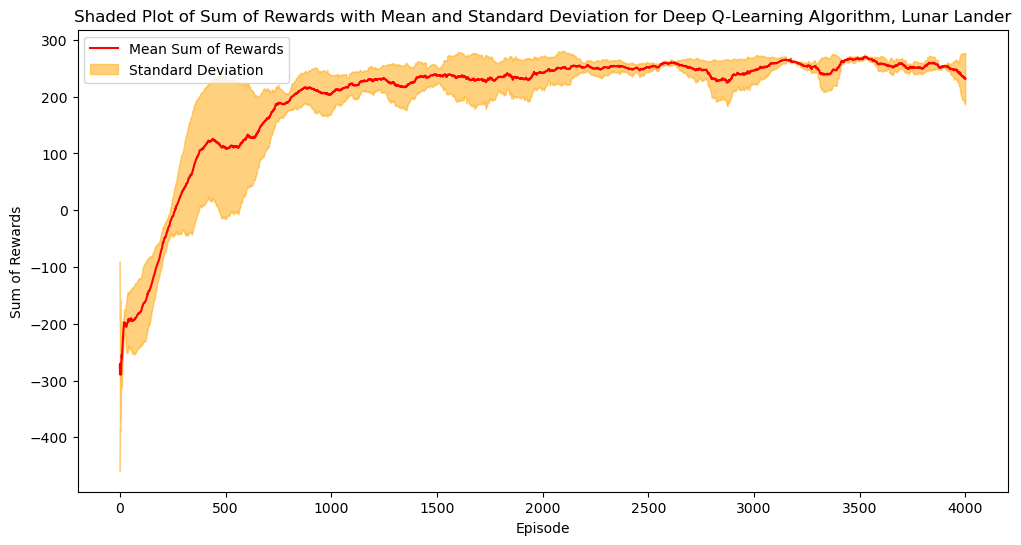

In [12]:
# Step 1: Read Data from CSV
df = pd.read_csv('plots/DQN_LunarLander-v2_reward.csv')

# Step 2: Remove the first row (Episodes, Run 1, Run 2, Run 3) to keep only the rewards data
# df = df.drop(0)

# Step 3: Convert the remaining DataFrame to numeric values
df = df.apply(pd.to_numeric)

# Step 4: Select only the three late columns (Run 1, Run 2, Run 3)
later_columns = df.iloc[:, 1:4]

# Step 5: Calculate Mean and Standard Deviation for the three later columns
mean_values = later_columns.mean(axis=1)
std_values = later_columns.std(axis=1)
print("Standard deviation: ", std_values)
print("Mean: ", mean_values)

# Step 6: Plot the Data
plt.figure(figsize=(12, 6))
plt.plot(mean_values, label='Mean Sum of Rewards', color = "red")
plt.fill_between(mean_values.index, mean_values - std_values, mean_values + std_values, alpha=0.5, label='Standard Deviation', color = "orange")
plt.xlabel('Episode')
plt.ylabel('Sum of Rewards')
plt.title('Shaded Plot of Sum of Rewards with Mean and Standard Deviation for Deep Q-Learning Algorithm, Lunar Lander')
plt.savefig('plots/shaded_plot_DQN_LunarLander.png')
plt.legend()
plt.show()